<div align="center">
<h1> 
Analytics and Application - WS2021/22 <br>
Master of Science WI / IS <br>
Faculty of Management, Economics, and Social Sciences <br>
Department of Information Systems for Sustainable Society University of Cologne </h1>
</div>
    
<hr>

<div align="center"> 
    <b>Instructor </b> Prof. Dr. Wolfgang Ketter <br>
    <b> TA </b> Nastaran Naseri
</div>

<hr>

<div align="center">
<h3> 
Team Assignment - Team 06 <br>
Data Miners CABIB <br>
Isabel Wittmann, Bastian Schneider, Andrej Kotsovolos, Björn Reibke & Carsten Stukenborg </h3>
</div>

<hr>

<div align="center">
<h5> Dataset Chicago 2019 </h5>
</div>

<hr>
    
<div align="center">
<h2> 2. Descriptive Analytics </h2>
</div>

# 2.0 Introduction
Since our data is now clean and ready, we can start to explore insights that are important for the company.

The following will be explored:

Overview: 
- 2.1 Temporal demand patterns and seasonality
    - 2.1.1 Calculation for usage and utilization of bike fleet
    - 2.1.2 Usage of bike fleet  
    - 2.1.3 Utilization of bike fleet
- 2.2 Geographical demand patterns
    - 2.2.1 Top X Stations
    - 2.2.2 Plotting the Top X Stations Geographically
    - 2.2.3 Visualizing Further Geospatial Data
- 2.3 KPIs
    - 2.3.1 Introduction and Data Preparation for the First Two KPIs 
    - 2.3.2 Calculation of the First KPI (Rides Per Bike)
    - 2.3.3 Plotting KPI 1 (Rides Per Unique Bike) with Unique Yearly and Unique Daily Bikes
    - 2.3.4 KPI 2 - Demand and Station Capacity: Implementation of the Concept of Coverage
    - 2.3.5 Investigation of KPI 2 (Demand_Capacity)
    - 2.3.6 Scrutinizing "Problematic" Stations in terms of High Values of KPI 2
    - 2.3.7 Main Conclusions Based on KPI 1 and KPI 2
    - 2.3.8 KPI 3: Duration
    - 2.3.9 KPI 4: Revenue

In [2]:
# Imports: 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime
from datetimerange import DateTimeRange
import os
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from tqdm import tqdm_notebook as tqdmn
import folium
from sklearn.preprocessing import StandardScaler
from calendar import monthrange
from collections import Counter

<h4> Numpy, Pandas, Matplotlib, Seaborn </h4>
Those modules are very common libraries to work with numerical arrays and to ease and improve the process of plotting of data.

<h4> Datetime, Datetimerange </h4>
Those modules provide functionalities to convert and work with time data more easily.

<h4>OS</h4>
This module provides a portable way of using operating system dependent functionality.

<h4>Geopandas</h4>
With GeoPandas, you can work  with geopspatial data in python without the need of a spatial database. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely.

<h4>GeoDataFrama</h4>
A GeoDataFrame object is a pandas.DataFrame that has a column with geometry.

<h4> Shapely Point and Polygon</h4>
Shapely is a Python package for set-theoretic analysis and manipulation of planar features using (via Python’s ctypes module) functions from the well known and widely deployed GEOS library.

<h4>Tqdm_notebook</h4>
Jupyter Notebook progressbar decorator for iterators. Includes a default range iterator printing to stderr.

<h4>Folium</h4>
With folium, you can visualize data on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.<br>
The library has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. folium supports both Image, Video, GeoJSON and TopoJSON overlays.

<h4>StandardScaler</h4>
Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as: z = (x - u) / s, 
where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

<h4>Monthrange</h4>
The monthrange() method is used to get weekday of first day of the month and number of days in month, for the specified year and month.

<h4>Counter</h4>
A Counter is a container that keeps track of how many times equivalent values are added. It can be used to implement the same algorithms for which bag or multiset data structures are commonly used in other languages.
Counter supports three forms of initialization. Its constructor can be called with a sequence of items, a dictionary containing keys and counts, or using keyword arguments mapping string names to counts.

<h4>matplotlib.patches</h4>
Patches are Artists (Abstract base class for objects that render into a FigureCanvas; Typically, all visible elements in a figure are subclasses of Artist) with a face color and an edge color.

Read the required data files. We need the trip and weather data. 

In [3]:
# Read data
divvy_bike_set = pd.read_csv("../data/bike_weather_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])
weather_set = pd.read_csv("../data/weather_clean_interpol.csv", parse_dates=["full_hour_start"])

# 2.1 Temporal Demand Patterns and Seasonality

In the following, the <b>usage</b> and <b>utilization</b> of the bike fleet is visualized. Usage and Utilization were further contrasted with <i>temperature</i> and <i>rain</i> rate. <br>
Four aggregation levels were chosen (<b>monthly</b>, <b>weekly</b>, <b>daily</b> and <b>hourly</b>), where all four are used for usage and monthly and daily were used for utilization. We did not use a weekly and hourly plot for the utilization because repeating patterns were shown, so a monthly and daily plot was sufficient.  

The <b>usage</b> of bike fleet describes how many rentals are started on each month and on each day.

Further, the total number <i>n</i> of available bikes was determined (unique bike ids). 
According to the aggregation level, it was counted how many of the available bikes have been used. Consequently, the statement can be made that <i>x</i> bikes of the total available <i>n</i> bikes have been used. The ratio (<i>x/n</i>) was formed and is called <b>utilization rate</b>. In other words, it is visualized how many unique bikes of the total available bikes have been used at least once on daily or monthly basis. 

## 2.1.1 Calculation for Usage and Utilization of Bike Fleet 

In [4]:
# Insert month and day helper coloumn
weather_set["month"] = weather_set["full_hour_start"].dt.month
weather_set["day"] = weather_set["full_hour_start"].dt.day

In [5]:
# Make copy of data set, and work for calculations with copy
divvy_bike_set_c = divvy_bike_set.copy()

# Add new column with start_time round down to full hour
divvy_bike_set_c["full_hour_start_round_down"] = divvy_bike_set_c["start_time"].dt.floor("H")

# Add new column weekdays (0-6)
divvy_bike_set_c["weekdays"] = list(map(lambda x: x.weekday(), divvy_bike_set_c["start_time"]))

# Group weather set by month and day to calculate the precip rate for each day in each month
weather_group = weather_set.groupby(["month", "day"]).mean()
# 2d array representing the precip rate for each day in each month
precip_daily = []

# Array representing the monthly utilization rate (number of unique bike ids which occur at least once)
utilization_monthly = []
# 2d array: Each subarray represents one month, which contains utilization rate entry for each day
utilization_daily = []

#utilization_hourly = []

# Array representing the fleet usage, given by the number of bike rentals per each month
usage_monthly = []
# 2d array representing the fleet usage, given by number of bike rentals per day for each month
usage_daily = [] 
# 2d array, representing for each month the hourly usage
usage_hourly = []
# 2d array, representing weekly usage for each month
usage_weekly = [0,0,0,0,0,0,0,0,0,0,0,0]

# 2d array: Each subarray represents one month, which containts date entry (year-month-day)
dates = []

# 2d array: Each subarray represents one month. Within each subarray there are the mean max_temp values for each hour
max_temperature_hourly = []
#min_temperature_hourly = []

# Dict storing how often a bike id occurs, length represent the total number of unique bike ids
dict_bikeId_count_total = Counter(divvy_bike_set_c["bike_id"]).items()

# Outer loop through each month
day_counter = 0
for month in range(1,13):
    year = divvy_bike_set_c.iloc[0].start_time.year
    divvy_bike_set_month = divvy_bike_set_c[divvy_bike_set_c["full_hour_start_round_down"].dt.month == month]
    
    # Number of trips of month in question
    usage_monthly.append(len(divvy_bike_set_month))
    
    # Count unique bike ids of month in question
    count = Counter(divvy_bike_set_month["bike_id"]).items()
    utilization_rate_month = len(count) / len(dict_bikeId_count_total)
    utilization_monthly.append(utilization_rate_month)
    
    # Count usage weekly
    count_week = divvy_bike_set_month.groupby(by="weekdays").count()
    usage_weekly[month-1] = [count_week.iloc[0].start_time,count_week.iloc[1].start_time,
                               count_week.iloc[2].start_time,count_week.iloc[3].start_time,
                               count_week.iloc[4].start_time,count_week.iloc[5].start_time,count_week.iloc[6].start_time]
    
    # Save daily utilization, usage and day for specific month in question
    bin_utilization_daily = []
    bin_usage_daily = []
    bin_date_daily = []
    # Cumulative hourly usage for month in question, pre-init with zeros
    # hours:            00   01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17   18   19   20   21   22   23 
    bin_usage_hourly = [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
    
    # Mean temperature for month based on heach hour
    bin_max_temperature_hourly = [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
    #bin_min_temperature_hourly = [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
    
    # precip rate bin for month in question
    bin_precip_daily = []
    
    # Inner loop through each day in month
    for day in range(1, (monthrange(year,month)[1])+1): 
        # Build date as string
        date = str(year)+"-"+str(month)+"-"+str(day)
        # Get dataframe for day in month
        divvy_bike_set_day = divvy_bike_set_month[divvy_bike_set_month["full_hour_start_round_down"].dt.day == day]
        
        # Collect precip rate for month
        #print("Month {}, Day {} with precip {}".format(month,day, weather_group.iloc[day_counter].precip/24))
        bin_precip_daily.append(weather_group.iloc[day_counter].precip)
        
        # Hourly count
        count_hour = divvy_bike_set_day.groupby("full_hour_start_round_down").count()
        temp_hour = divvy_bike_set_day.groupby("full_hour_start").mean()
        for h in range(0,len(count_hour)):
            bin_usage_hourly[count_hour.iloc[h].name.hour] += count_hour.iloc[h].start_time
            bin_max_temperature_hourly[temp_hour.iloc[h].name.hour] += temp_hour.iloc[h].max_temp 
            #bin_min_temperature_hourly[temp_hour.iloc[h].name.hour] += temp_hour.iloc[h].min_temp
        
        # Count unique bike id
        count_day = Counter(divvy_bike_set_day["bike_id"]).items()
        
        # Append date, utilization rate and usage in bins for this month      
        bin_date_daily.append(date)
        utilization_rate_daily = len(count_day)/ len(dict_bikeId_count_total)
        bin_utilization_daily.append(utilization_rate_daily)
        bin_usage_daily.append(len(divvy_bike_set_day))
        
        # Increase day counter
        day_counter = day_counter +1
    
    #Calculate mean of temp hourly for month
    for i in range(0,len(bin_max_temperature_hourly)): 
        #bin_min_temperature_hourly[i] = bin_min_temperature_hourly[i] / (monthrange(year,month)[1])
        bin_max_temperature_hourly[i] = bin_max_temperature_hourly[i] / (monthrange(year,month)[1])
    
   
    
    # Collect all bins
    utilization_daily.append(bin_utilization_daily)
    usage_daily.append(bin_usage_daily)
    usage_hourly.append(bin_usage_hourly)
    dates.append(bin_date_daily)
    max_temperature_hourly.append(bin_max_temperature_hourly)
    precip_daily.append(bin_precip_daily)
    #min_temperature_hourly.append(bin_min_temperature_hourly)

## 2.1.2 Usage of Bike Fleet

### 2.1.2.1 Usage of Bike Fleet - Aggregation Level Monthly
The fleet usage is given by the number of bike rentals.

In [6]:
# Groub by month
weather_monthly = weather_set.groupby("month").mean()

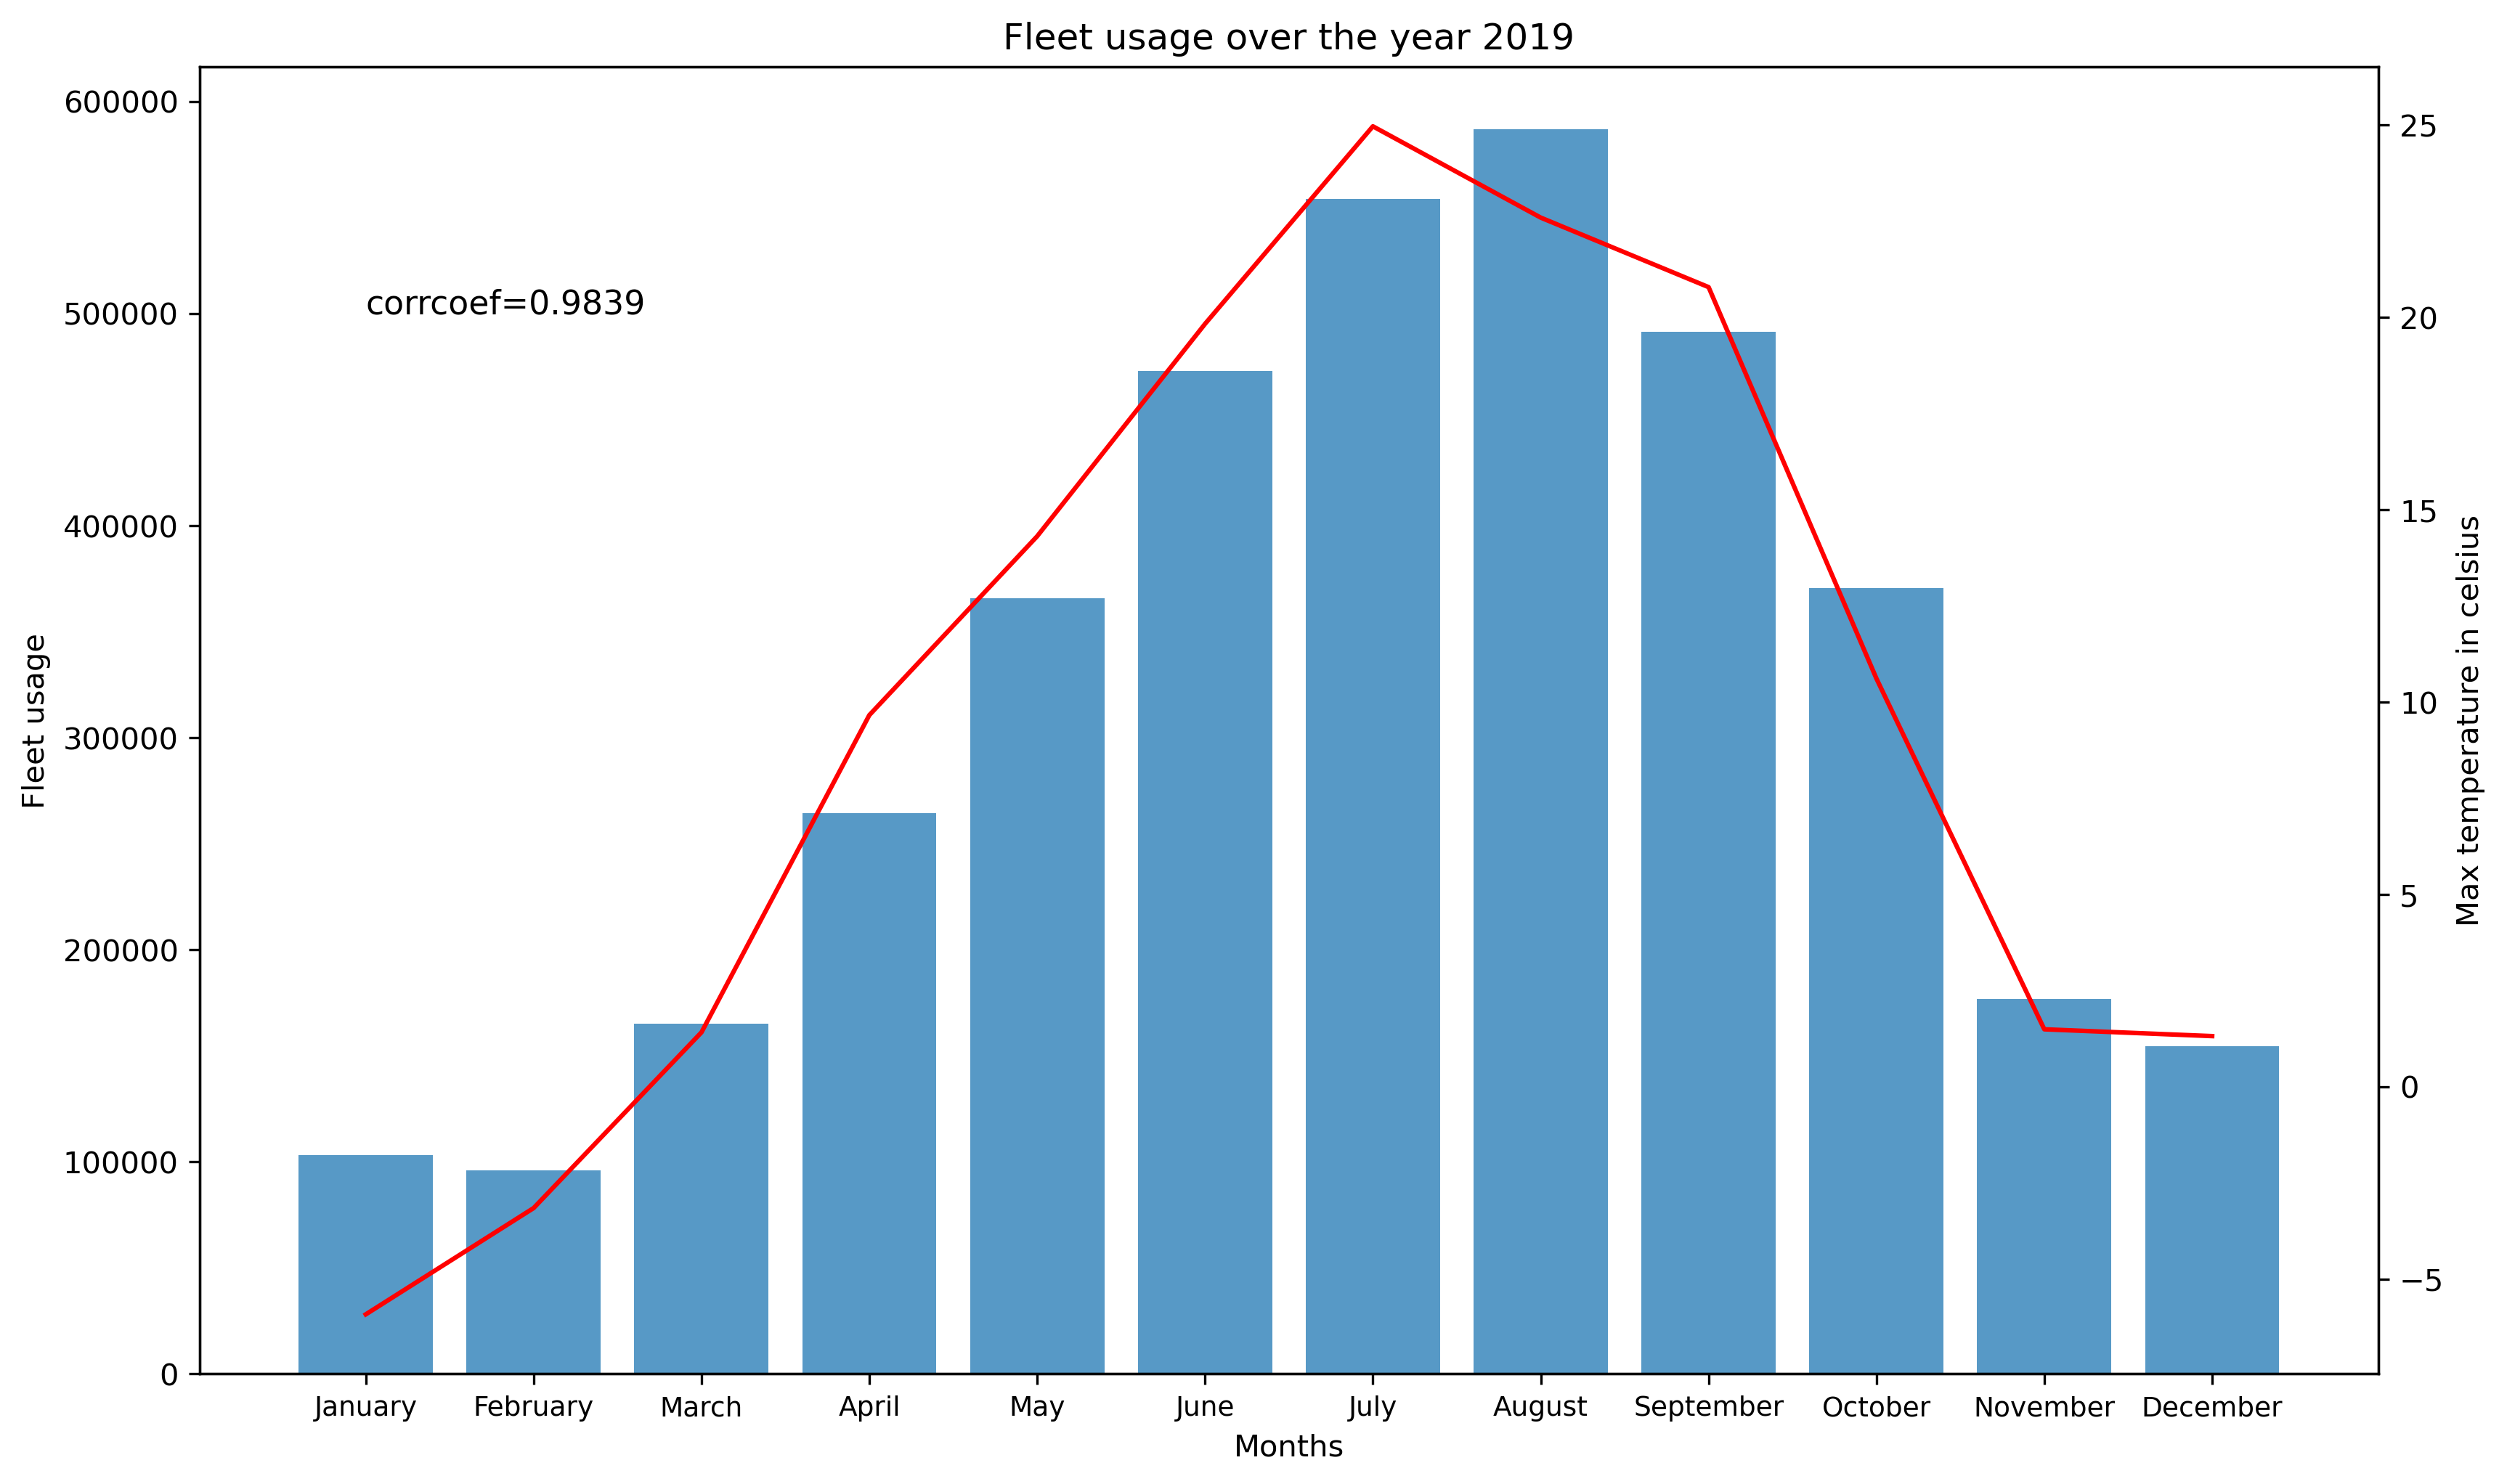

In [7]:
# Plot the monthly usage over the year
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

figure_annual = plt.figure(figsize=(10,6),dpi = 300)
ax = figure_annual.add_axes([0,0,1,1])

# Calculate the position of each barplots on the x-axis
x = (range(len(months)))

ax.bar(x, usage_monthly,alpha=0.75)

plt.sca(ax)
plt.xticks(x, months, fontsize=10, rotation=0)

axe2 = ax.twinx()            
axe2.plot(x,weather_monthly["max_temp"],color="red" )
axe2.set_ylabel("Max temperature in celsius")

ax.set_xlabel("Months")
ax.set_ylabel("Fleet usage")
ax.set_title("Fleet usage over the year 2019")
ax.tick_params(axis='x', which='major', labelsize=9)

corrcoef = np.corrcoef(usage_monthly,weather_monthly["max_temp"])[0][1]
annotation = "corrcoef="+str(round(corrcoef,4))
#style = {size:10, color:'gray'}
ax.text(0,500000,annotation, fontsize=11)
plt.show()

<h4> What patterns can we observe? </h4>
A saisonal pattern can be observed. During the summer months the fleet usage is higher in comparison to the winter months. 
More precisely, in the months of January, February and March, a low usage of the fleet is observed. Here, between 100,000 and 150,000 trips are started per month. This value increases sharply from the month of April and reaches its peak in August with 600,000 trips started. After August, this number drops continuously to the level of January and February.
<br>
If we now correlate these values with the temperature values, we see a similar picture. As the temperature rises, which of course reaches its maximum in the summer months of July and August, the number of trips also increases. The correlation coefficient with above 0.98 confirms this connection.
<br>
<br>
<i>Note:</i> It is important to note that the different number of days of the corresponding months were not taken into account in the figure or were not normalized in the calculations. Consequently, one must be aware that a month such as January with 31 days records slightly higher numbers than the month of February with 28 days. However, this does not change the implication of seasonal usage and could therefore be neglected in this context. 

### 2.1.2.2 Usage of Bike Fleet - Aggregation Level Daily

In [8]:
# Create 12 subplots, each polt represents each month

def plot_bars_monthly(bars,precipRate, yMin, yMax,yStepSize, title, yLabel):
    # 2 subplots for each row
    nrows=6
    ncols=2

    # Create figure and axes
    bar_figure, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize= (30,60))

    # month counter
    month=0

    # Loop through all axes
    for row in range(0,nrows):
        for column in range(0,ncols):
            axe = axes[row][column]

            # Calculate the position of each barplots on the x-axis
            x = (range(len(dates[month])))
            x_pos = [2*i for i in x]

            # Set color blue to weekday and red to weekend
            c = []
            for i in range(0,len(dates[month])): 
                day_number = pd.to_datetime(dates[month][i]).weekday()
                if(day_number == 5 or day_number == 6): 
                    c.append("green")
                else: 
                    c.append("red")

            # plot bars
            axe.bar(x_pos, bars[month], width=0.7, color=c, label=["x","y"])
            
            # plot precip rate
            axe2 = axe.twinx()
            #axe2 = sns.lineplot(x=x_pos ,data=precipRate[month],color="red" )
            axe2.plot(x_pos,precipRate[month], label="Precip rate", color="blue")
            axe2.set_ylim([0.0,1.0])
            axe2.set_ylabel("Precip rate", fontsize=15)

            # Set y-scale from 0 to 1.0
            axe.set_ylim([yMin,yMax])
            
            start, end = axe.get_ylim()
            # Set step size of y axis
            axe.yaxis.set_ticks(np.arange(start, end, yStepSize))

            # Label the x-axis with dates
            plt.sca(axe)
            plt.xticks(x_pos, dates[month], fontsize=10, rotation=90)
            
            # Corr
            corrcoef_matrix = np.corrcoef(bars[month],precipRate[month])
            annotation = "corrcoef="+str(round(corrcoef_matrix[0][1],4))
            axe2.text(38,0.9,annotation, fontsize=12)

            # Label the y-axis and set a title
            axe.set_ylabel(yLabel, fontsize=15)
            axe.set_title(title, fontsize=15)

            red_patch = mpatches.Patch(color='green', label='Weekday')
            green_patch = mpatches.Patch(color='red', label='Weekend')
            blue_patch = mpatches.Patch(color='blue', label='Precip rate')
            plt.legend(handles=[red_patch,green_patch, blue_patch])

            # Increase month counter
            month = month + 1
            plt.grid(True)

    # Show plot
    plt.show()

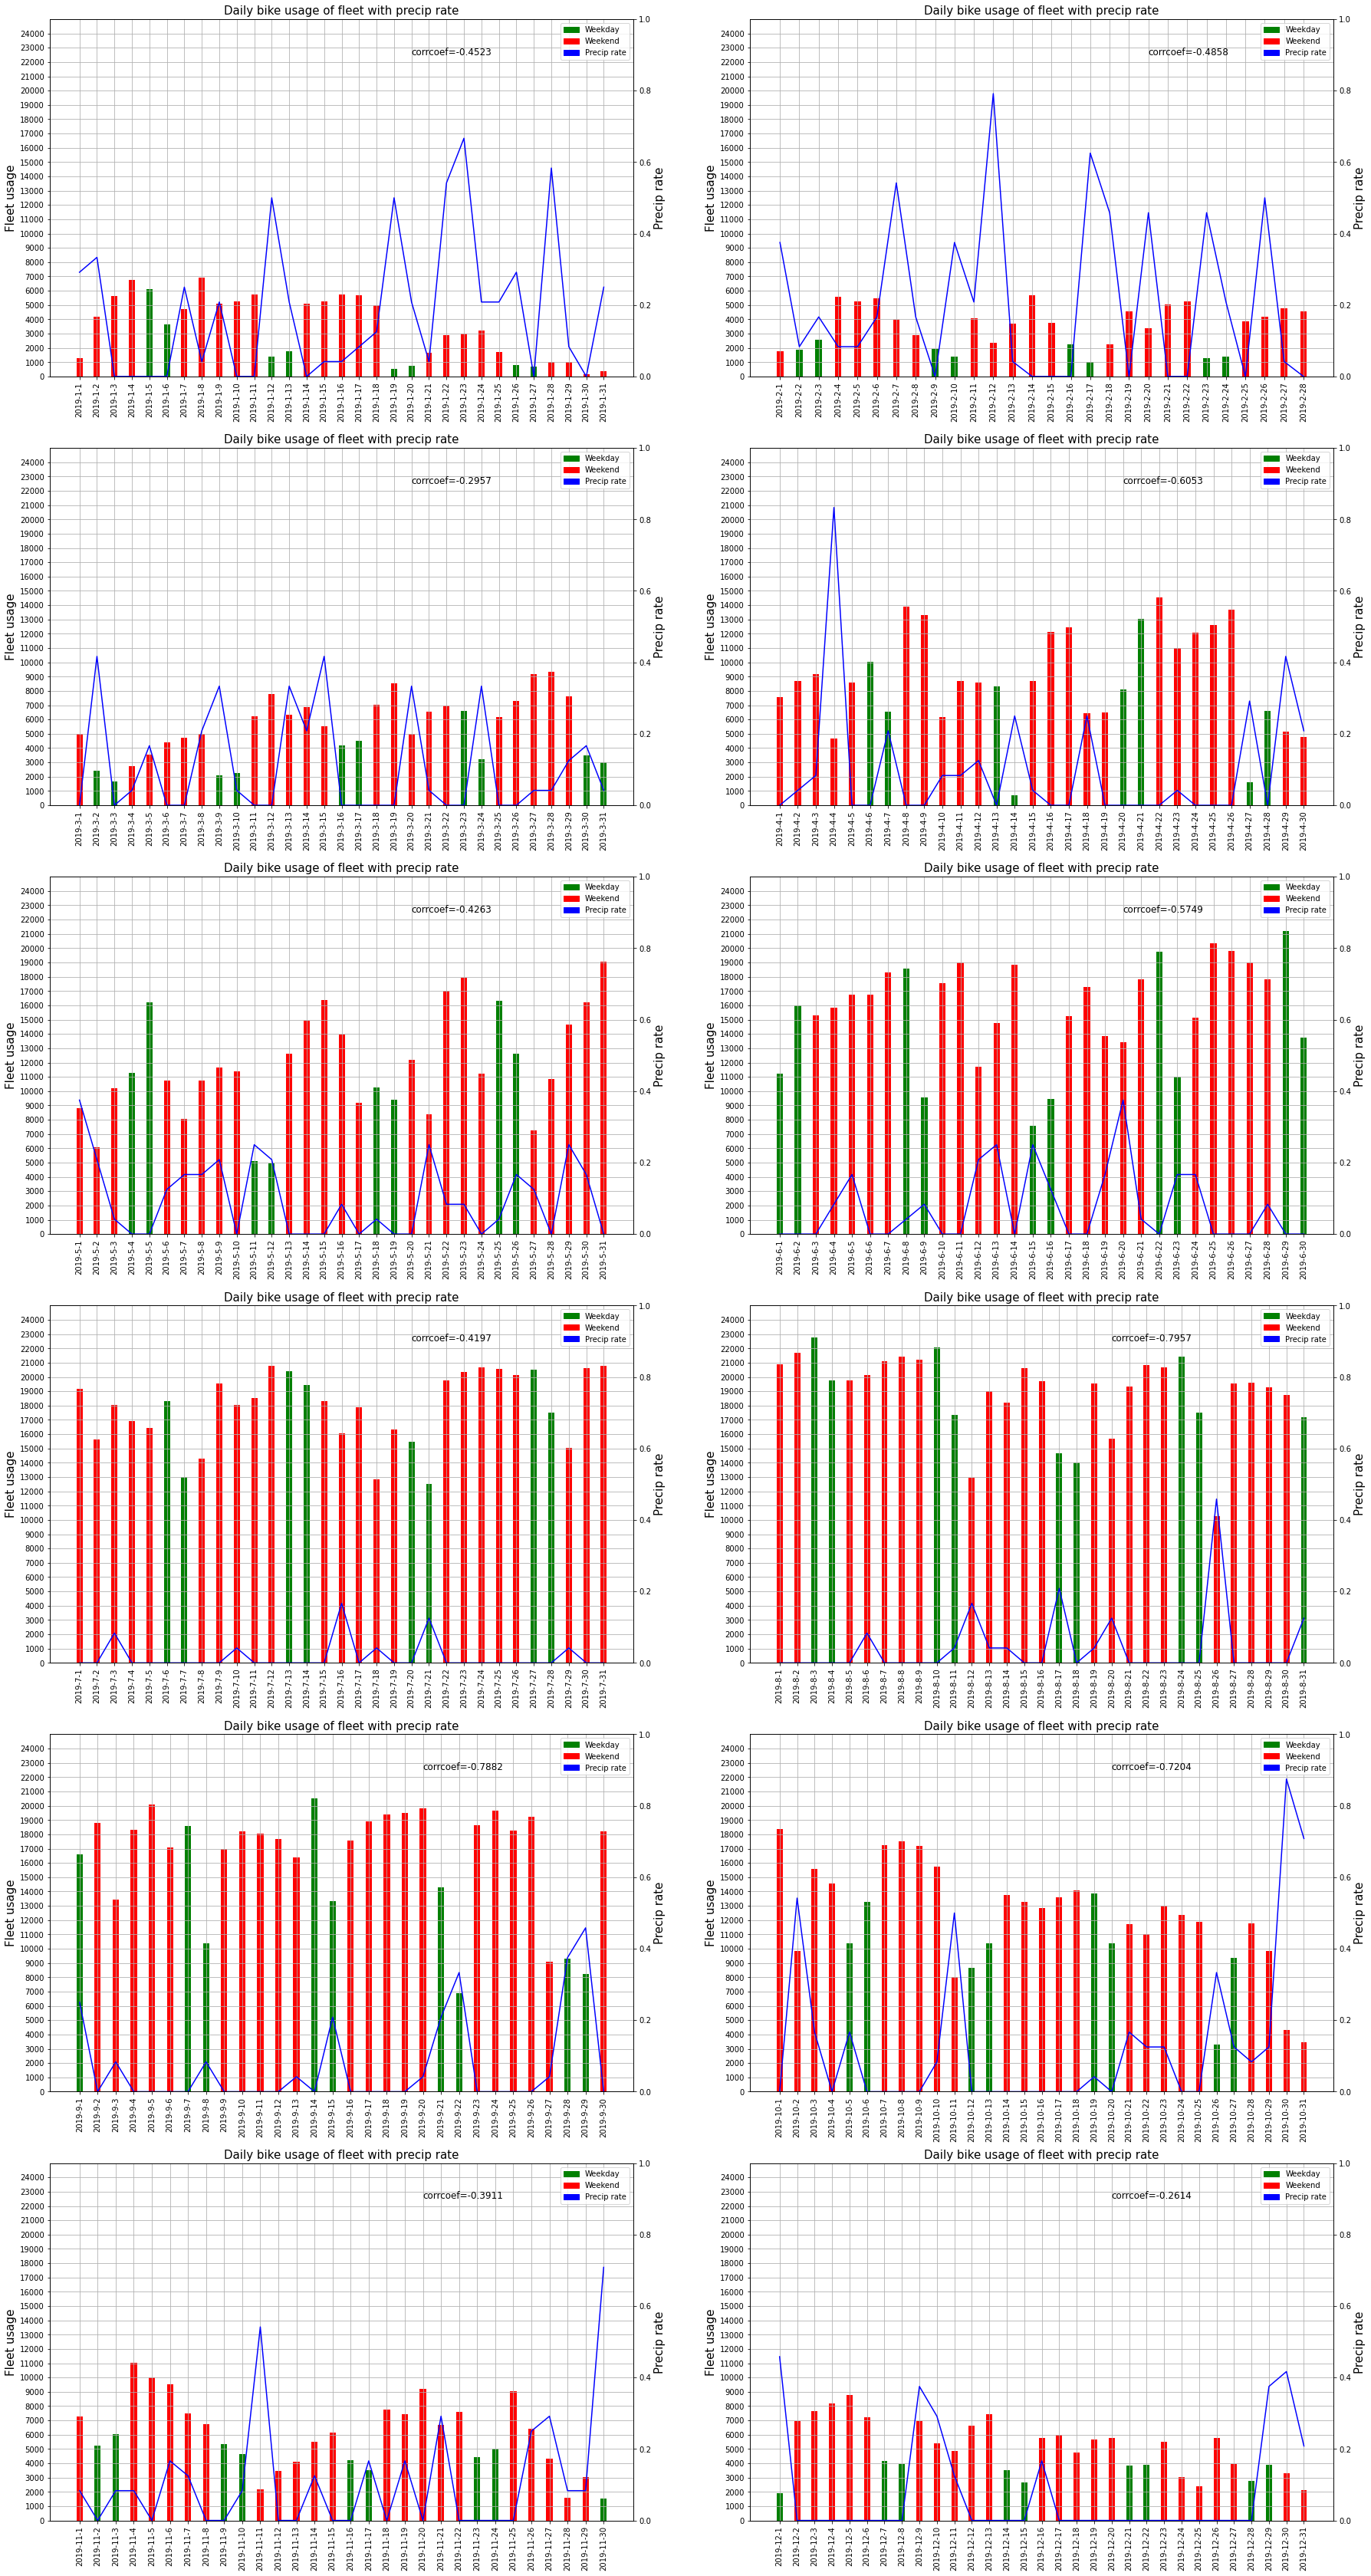

In [9]:
plot_bars_monthly(usage_daily,precip_daily, 0, 25000,1000, "Daily bike usage of fleet with precip rate", "Fleet usage")

<b>Patterns between subplots</b><br>
As seen in the previous figure, these subplots also show seasonal variations across the month. The precip rate is higher throughout the days in the winter months than in the summer months.  
<br>
<b>Patterns within the subplots </b><br>
Various individual patterns are visible: 
- Usage during the week is usually higher than on weekends. However, this pattern does not always apply, so that exceptions can also be found (example 2019-8-3).
- Individual days with very low usage figures stand out. The days 2019-4-14 or 2019-4-27 can be mentioned here as examples. Research revealed that there were heavy snowstorms in Chicago on these days (https://www.weather.gov/lot/2019apr14_snow , https://www.weather.gov/lot/2019apr27_snow), which could explain the low usage.
- High precip rate usually indicate low usage numbers. This can be observed especially well in January. From mid to late January, high rain rates are recorded and the usage figures are correspondingly low. More examples can be found on the following days: 2019-11-11, 2019-10-30 and 2019-9-28/2019-9-29. This observation is clearly supported by the negative correlation coefficients. These show that the higher the rain rate, the lower the usage figures.

### 2.1.2.3 Usage of Bike Fleet - Aggregation Level Weekly
<b> Special comparison between February and August </b>
<br>
In the following, the contrast between summer and winter will be shown again, aggregated on the week with the help of the months February and August. 

In [10]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Aggregated usage for week (Monday - Sunday) for februrar and august
usage_week_comp = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]

# Usage februrar for week
for i in range(0,len(dates[1])): 
    weekday = pd.to_datetime(dates[1][i]).weekday()
    usage_week_comp[0][weekday] = usage_week_comp[0][weekday] + usage_daily[1][i];

# Usage august for week
# Subtract 3, because februrar has 28 days and august 31. Now we can ensure, that each weekday was counted four times.
for i in range(0,len(dates[7])-3): 
    weekday = pd.to_datetime(dates[7][i]).weekday()
    usage_week_comp[1][weekday] = usage_week_comp[1][weekday] + usage_daily[7][i];


usage_week_comp

[[15743, 16304, 17317, 19222, 13629, 7352, 6359],
 [62469, 74377, 78266, 83741, 83246, 80920, 68659]]

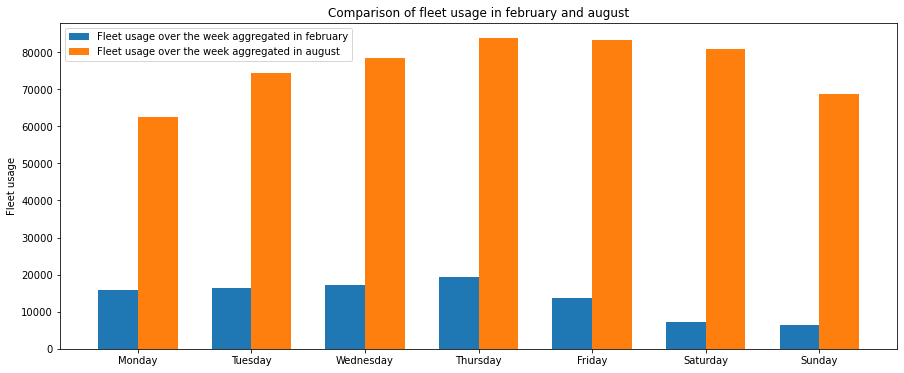

In [11]:
x = np.arange(len(weekdays))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
usage_feb = ax.bar(x - width/2, usage_week_comp[0], width, label='Fleet usage over the week aggregated in february')
usage_aug = ax.bar(x + width/2, usage_week_comp[1], width, label='Fleet usage over the week aggregated in august')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Fleet usage')
ax.set_title('Comparison of fleet usage in february and august')
ax.set_xticks(x)
ax.set_xticklabels(weekdays)
ax.legend()
fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()

The graph shows the contrast between a representative summer month and winter month. In August, the usage figures are always at least 3 times higher. It also shows that in the course of the week, usage increases slightly until Friday. After that on weekends, it decreases again and starts again to rise after Monday. 
The resulting differences between the weekend and the working week are slightly more noticeable in the month of February than in August. One possible theory could be that people rather stay at home on the cold weekends while need to get to work/school etc. during the weekdays.

### 2.1.2.4 Usage of Bike Fleet - Aggregation Level Hourly

In [12]:
# Convert usage_hourly to dataframe         
dict = {
    "jan": usage_hourly[0],
    "feb": usage_hourly[1],
    "mar": usage_hourly[2],
    "apr": usage_hourly[3],
    "may": usage_hourly[4],
    "jun": usage_hourly[5],
    "jul": usage_hourly[6],
    "aug": usage_hourly[7],
    "sep": usage_hourly[8],
    "oct": usage_hourly[9],
    "nov": usage_hourly[10],
    "dec": usage_hourly[11],
}

df_usage_hourly=pd.DataFrame.from_dict(dict)

In [13]:
# Create 12 subplots, each polt represents each month

months_l = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]

def plot_usage_weather(yMin, yMax,yStepSize, title, yLabel):
    # 2 subplots for each row
    nrows=6
    ncols=2
    
    hours = np.arange(0,24,1)

    # Create figure and axes
    bar_figure, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize= (30,60))

    # month counter
    month=1

    # Loop through all axes
    for row in range(0,nrows):
        for column in range(0,ncols):
            axe = axes[row][column]
            
            weather_month = weather_set[weather_set["full_hour_start"].dt.month == month]
            weather_group = weather_month.groupby("hour").mean()

            # plot bars
            if month == 1: 
                u = df_usage_hourly.jan
            elif month == 2: 
                u = df_usage_hourly.feb
            elif month == 3: 
                u = df_usage_hourly.mar
            elif month == 4: 
                u = df_usage_hourly.apr
            elif month == 5: 
                u = df_usage_hourly.may
            elif month == 6: 
                u = df_usage_hourly.jun
            elif month == 7: 
                u = df_usage_hourly.jul
            elif month == 8: 
                u = df_usage_hourly.aug
            elif month == 9: 
                u = df_usage_hourly.sep
            elif month == 10: 
                u = df_usage_hourly.oct
            elif month == 11: 
                u = df_usage_hourly.nov
            elif month == 12: 
                u = df_usage_hourly.dec
            
            # Plot bars
            axe.bar(hours, u, width=0.7, label="usage", color="blue")
            axe.plot(hours, u, label="usage", color="blue", alpha=0.5)

            # Set y-scale from 0 to 1.0
            axe.set_ylim([yMin,yMax])
            
            start, end = axe.get_ylim()
            # Set step size of y axis
            #axe.yaxis.set_ticks(np.arange(start, end, yStepSize))

            # Label the x-axis with dates
            plt.sca(axe)
            plt.xticks(hours)

            # Label the y-axis and set a title
            axe.set_ylabel(yLabel, fontsize=15)
            axe.set_title(title+" "+months_l[month-1], fontsize=15)
            axe.set_xlabel("Hours",fontsize=15)
            
            # Plot line
            axe2 = axe.twinx()
            axe2.plot(hours, weather_group["max_temp"],color="red", label="Max temperature in celsius")
            # Label y-axis for line
            axe2.set_ylabel("Max temperature in celsius",fontsize=15)

            # Create legend
            red_patch = mpatches.Patch(color='red', label='Temperature')
            blue_patch = mpatches.Patch(color='blue', label='Usage')
            plt.legend(handles=[red_patch, blue_patch])

            # Increase month counter
            month = month + 1
            #plt.grid(True)
            
            corrcoef = np.corrcoef(u,weather_group["max_temp"])[0][1]
            annotation = "corrcoef="+str(round(corrcoef,4))
            #style = {size:10, color:'gray'}
            axe.text(0,50000,annotation, fontsize=12)

    # Show plot
    
    plt.show()

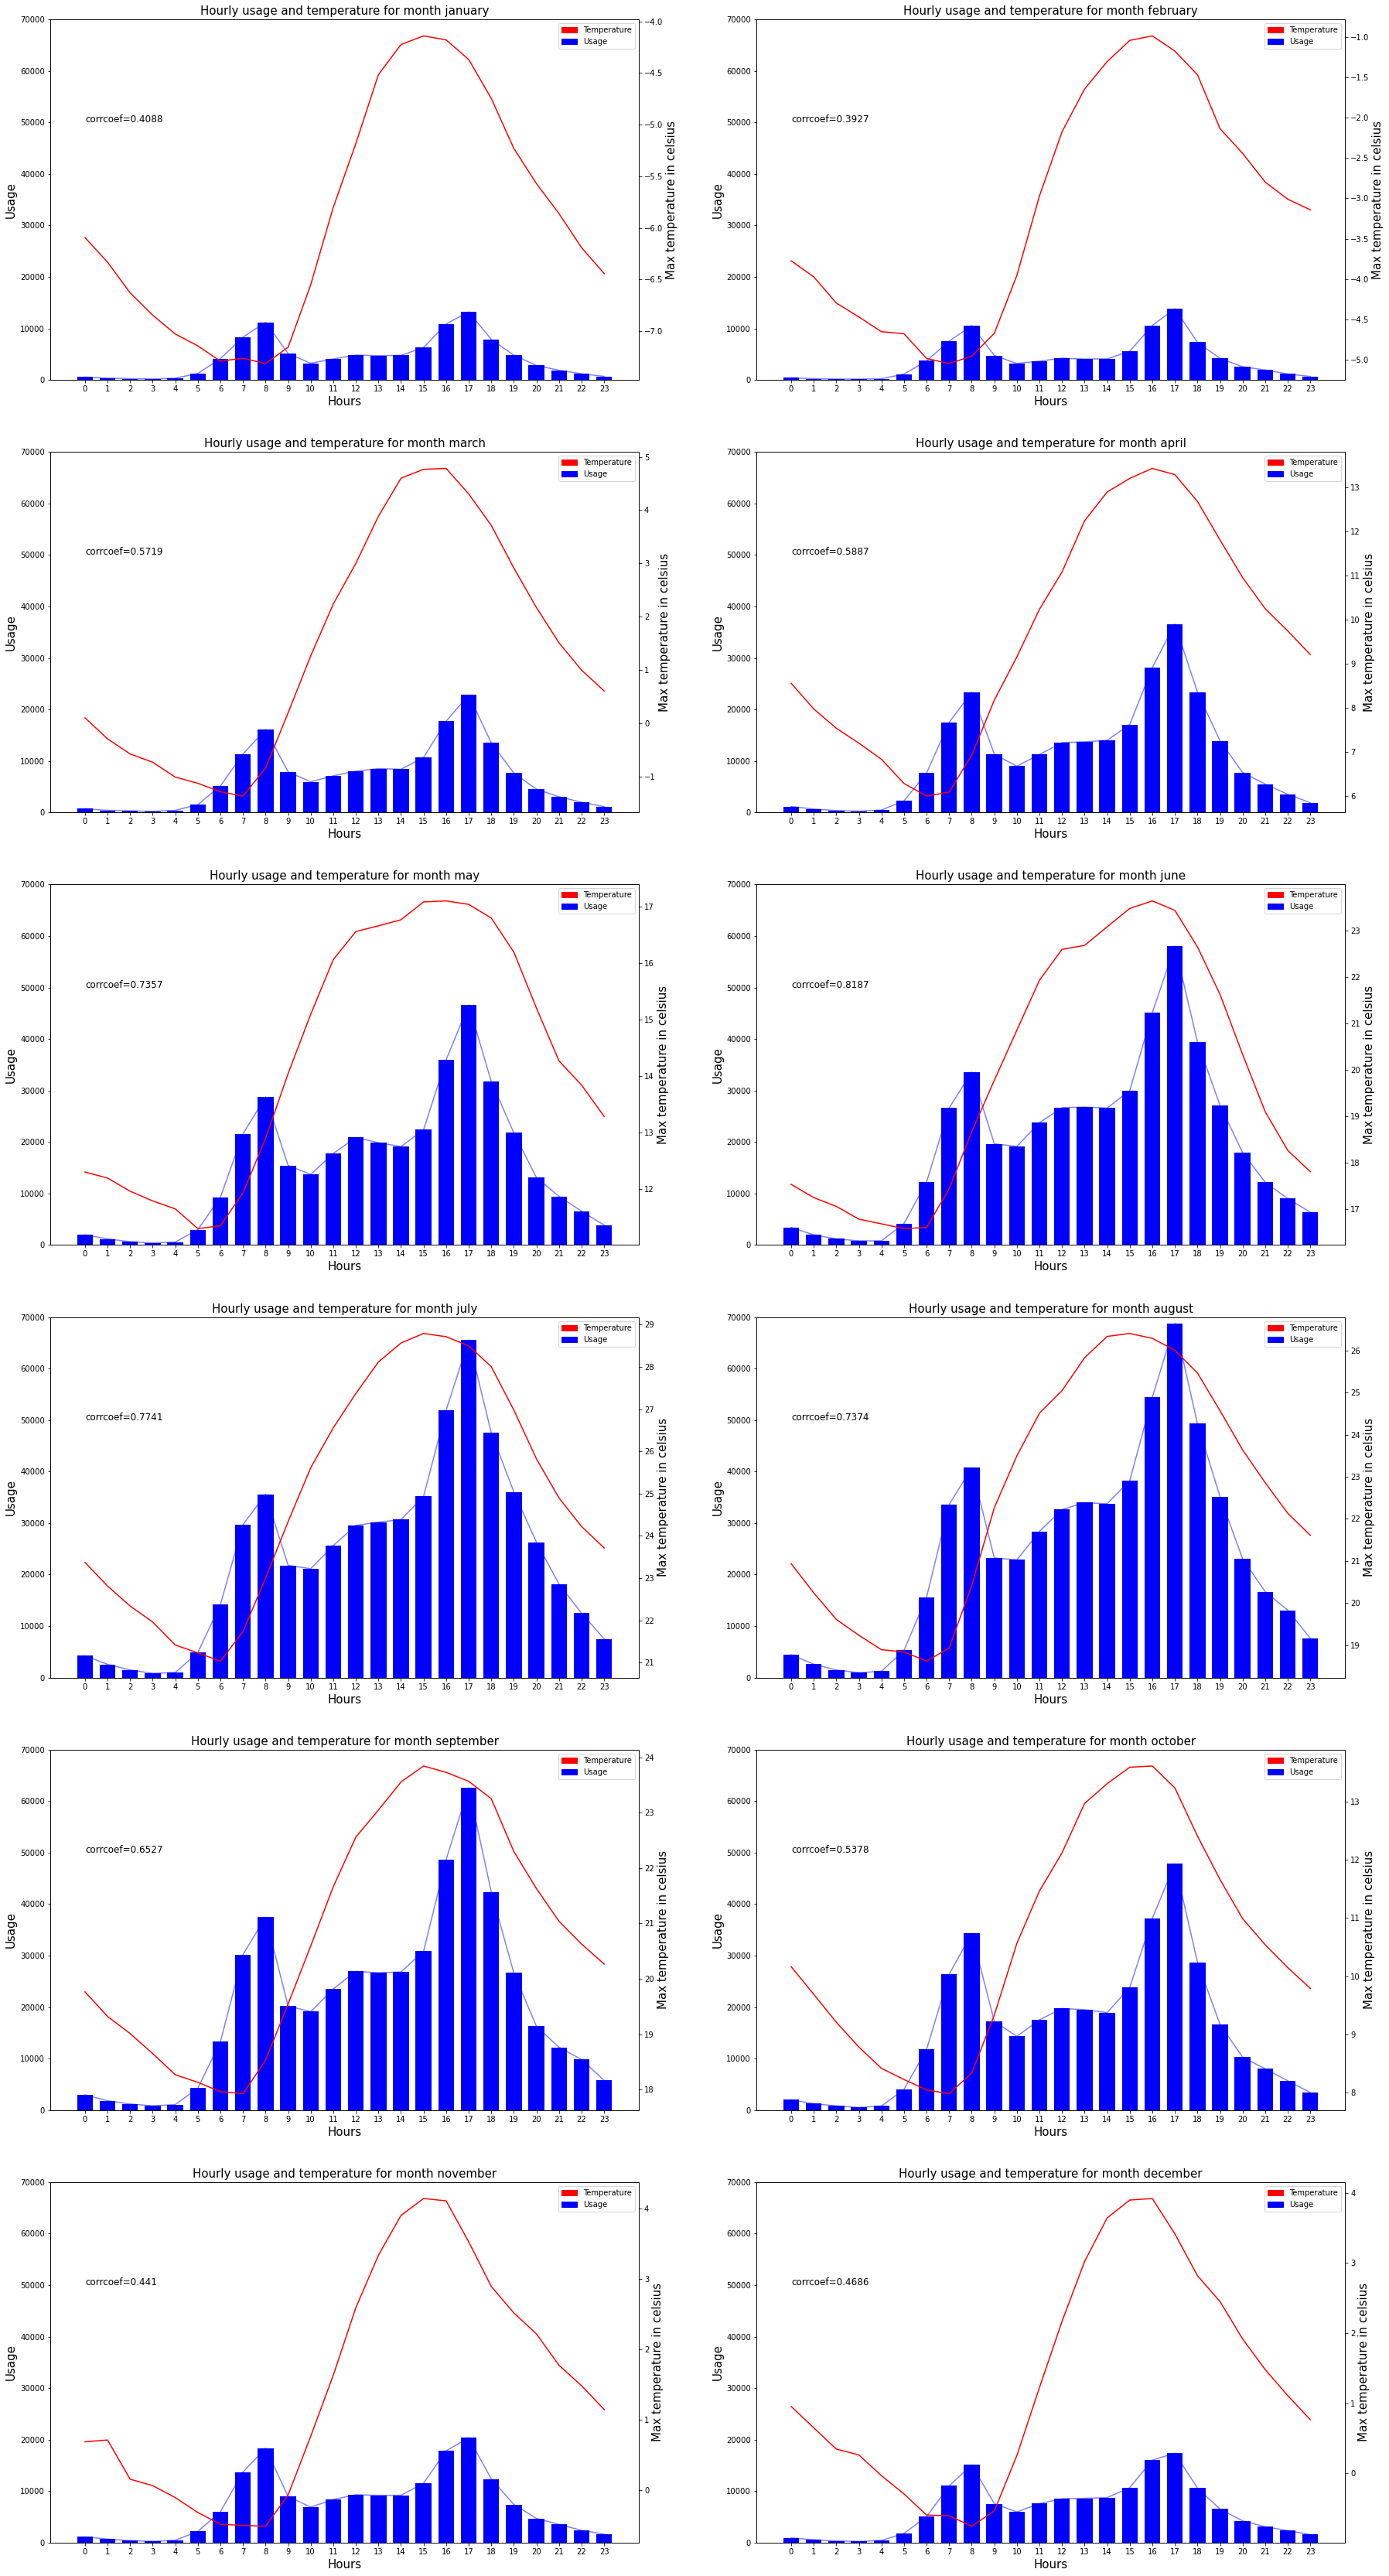

In [14]:
plot_usage_weather(0, 70000,1000, "Hourly usage and temperature for month", "Usage")

<b>Patterns between subplots</b><br>
As mentioned in the previous graphs, the seasonal pattern is also visible here. Therefore, no further explanation is given, since this pattern has already been explained. 
<br>
<br>
<b>Patterns within the subplots </b><br>
It can be observed that most trips start in the early morning and late afternoon hours. The guess is that this is where most people drive to work or drive home from work. 
There is also a positive correlation between the temperature and the hourly usage. The correlation is relativly higher in the summer months and lower in the winter months. It is important to note that usage drops after peak hours around 8 a.m. and remains relatively constant during the noon hours, only rising sharply again when commuters return home around 4 p.m. In this time interval (10 am - 3 pm) the temperature continues to rise constantly. Therefore, in this subsection a lower correlation can be assumed than the total correlation coefficient indicates. 


### 2.1.2.5 Usage of Bike Fleet - Conclusion
In this subsection, we want to summarize the results of the different graphs again using a heat map. 

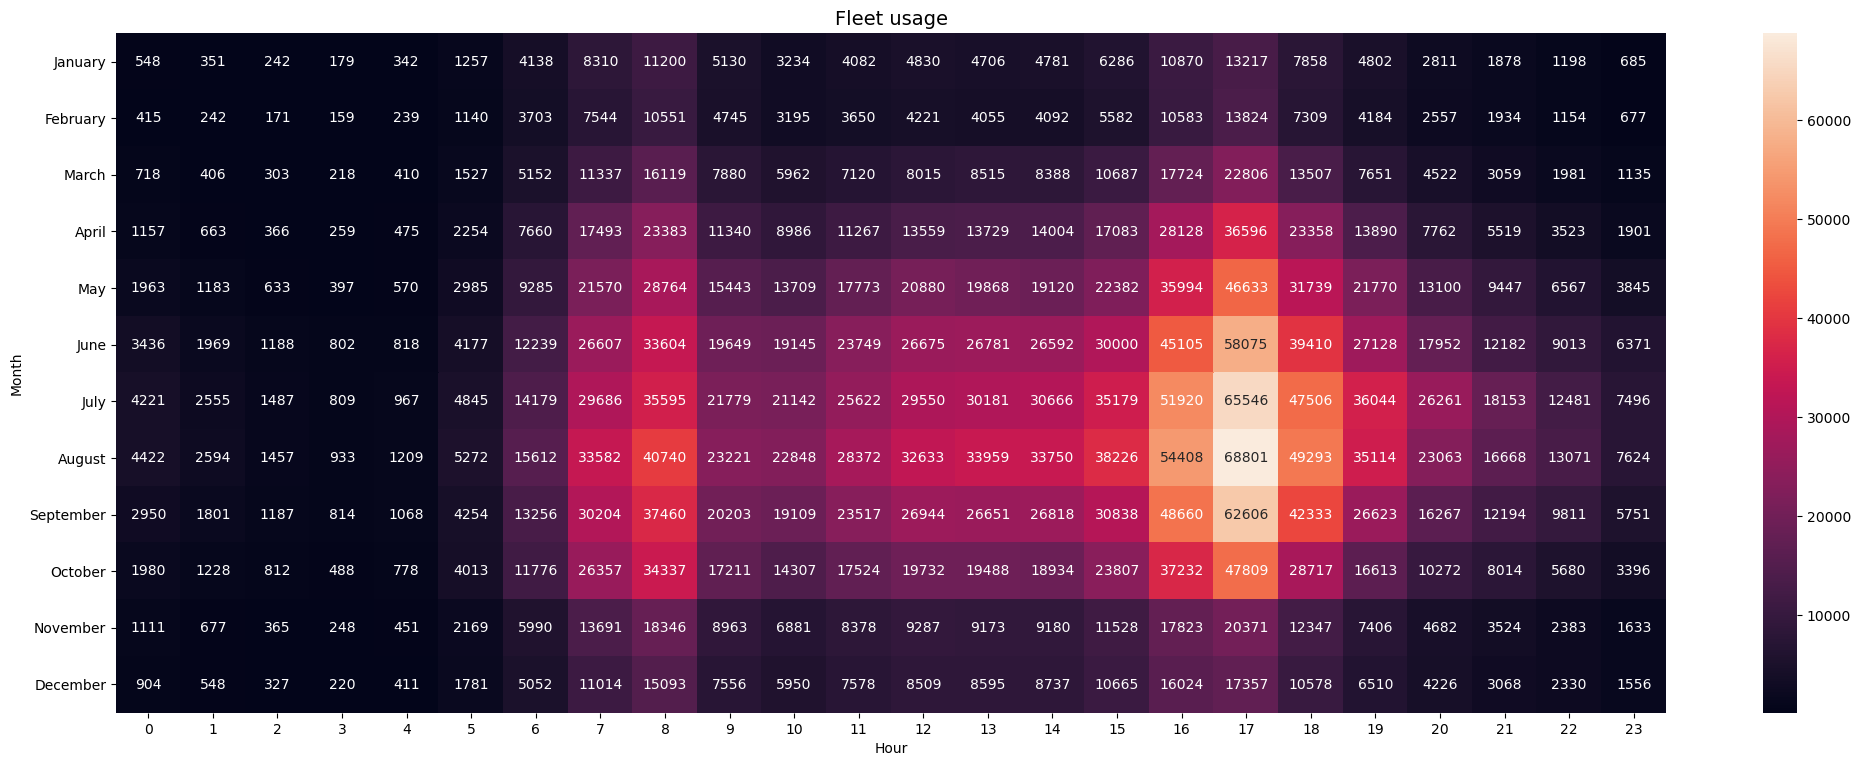

In [15]:
hours = np.arange(0,24,1)
f, ax = plt.subplots(figsize=(25, 9), dpi=100)

ax = sns.heatmap(df_usage_hourly.T, annot=True, fmt="d", ax=ax, xticklabels=hours, yticklabels=months)
ax.axes.set_title("Fleet usage", fontsize=14)
ax.set(xlabel='Hour', ylabel='Month');
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
plt.show()

Patterns that can be derived from usage: 
- Usage is higher in summer than in winter. 
- July and August are the months with the highest usage. 
- January and February are the months with the lowest usage. 
- Usage changes over the course of the day. In the morning hours there is a visible peak as well as in the afternoon. Commuters could be responsible for this. 
- Temperture and precip have an influence on the usage.
- In the case of hourly temperature change, a positive correlation is observed. 

## 2.1.3 Utilization of Bike Fleet

### 2.1.3.1 Utilization of Bike Fleet - Aggregation Level Monthly
<br>
The data set is divided into 12 data sets according to the months. The start time of a rental is used for this purpose. The bike id can of course occur more than once on the month in question (or on the day in question), if the bike has been used more than once on that month (day). However, this fact is not taken into account at this point, since the only purpose is to visualize how many unique bikes of the total available bikes have been used at least once.  

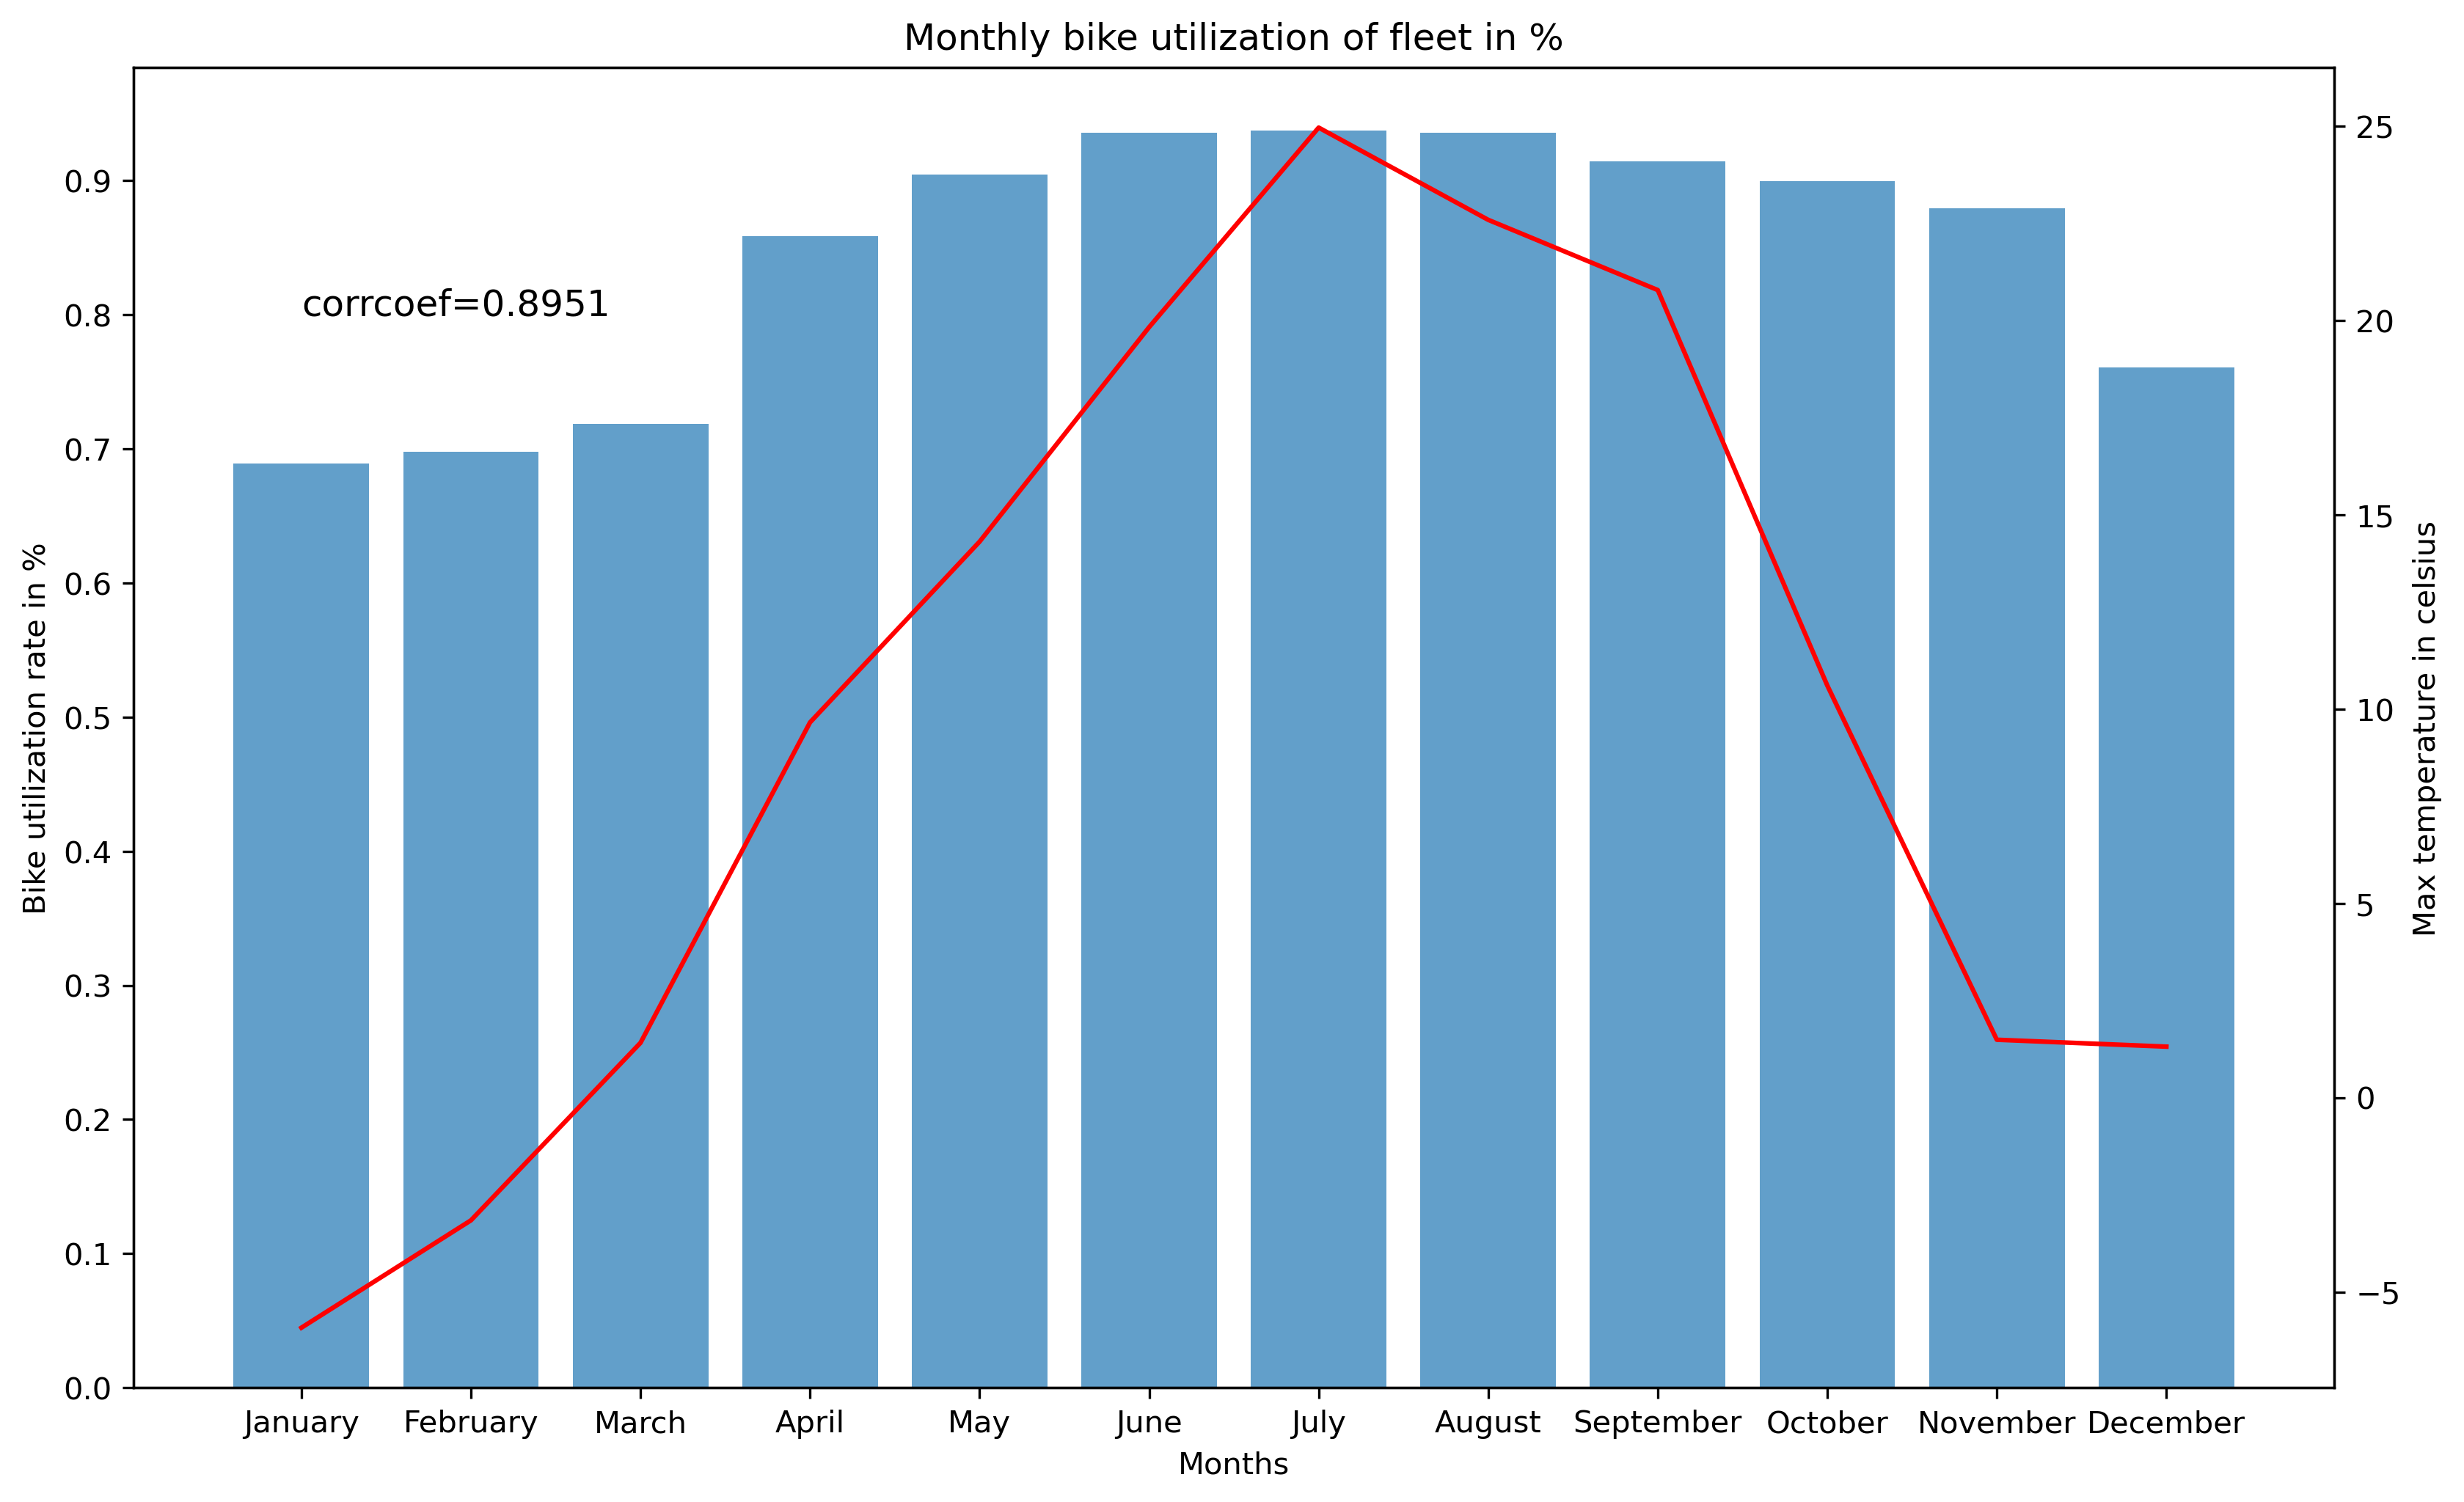

In [16]:
# Plot the utilization rate as histogramm for each month 
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Create a figure (empty work space)
Fig_1 = plt.figure(figsize=(10,6), dpi=300)

# Add axes to the figure
ax_1 = Fig_1.add_axes([0, 0, 1, 1]) #The dimensions [left, bottom, width, height] of the axes

# Plot
ax_1.bar(months, utilization_monthly, alpha=0.7)

# Calculate the position of each barplots on the x-axis
x = (range(len(months)))

# Temperatures
axe_2 = ax_1.twinx()            
axe_2.plot(x,weather_monthly["max_temp"],color="red" )
axe_2.set_ylabel("Max temperature in celsius")

# Adjust step size to 0.1 steps
start, end = ax_1.get_ylim()
ax_1.yaxis.set_ticks(np.arange(start, end, 0.1))

corrcoef = np.corrcoef(utilization_monthly,weather_monthly["max_temp"])[0][1]
annotation = "corrcoef="+str(round(corrcoef,4))
ax_1.text(0,0.8,annotation, fontsize=12)

# Add labels and title
ax_1.set_xlabel('Months') # Use set_ to start method
ax_1.set_ylabel('Bike utilization rate in %')
ax_1.set_title('Monthly bike utilization of fleet in %')
# Show plot
plt.show()

In [17]:
len(dict_bikeId_count_total)*(1-utilization_monthly[6])

376.0

In [18]:
len(dict_bikeId_count_total)*(1-utilization_monthly[0])

1870.0000000000002

The bar plot shows seasonal utilization of bike fleet. During the winter months of December, January, February and March about 70 percent of all available bikes are used. The utilization rate jumps to ~85 percent in April and then rises steadily to its peak months. The peak months are June, July and August with an utilization rate of above 90 percent. It then starts falling until it reaches the 70 percent level of the winter months again. 
<br>
Taking the opposite perspective, many available bicycles are not used. In the summer months, about 10 percent of the bicycles, 376 in absolute numbers, are unused. 
In the winter months, this figure rises to about 30 percent or 1870 in absolute numbers. These numbers are surprising that there are so many unused bikes available. 
<br>
As with usage, a positive correlation with temperature data can be seen. An increase/decrease in temperature also leads to an increase/decrease in utilization rate.

### 2.1.3.2 Utilization of Bike Fleet - Aggregation Level Daily

The used bikes for each day in each month are counted. If a bike id is listed on the corresponding day in the month, the counter is increased by one. 

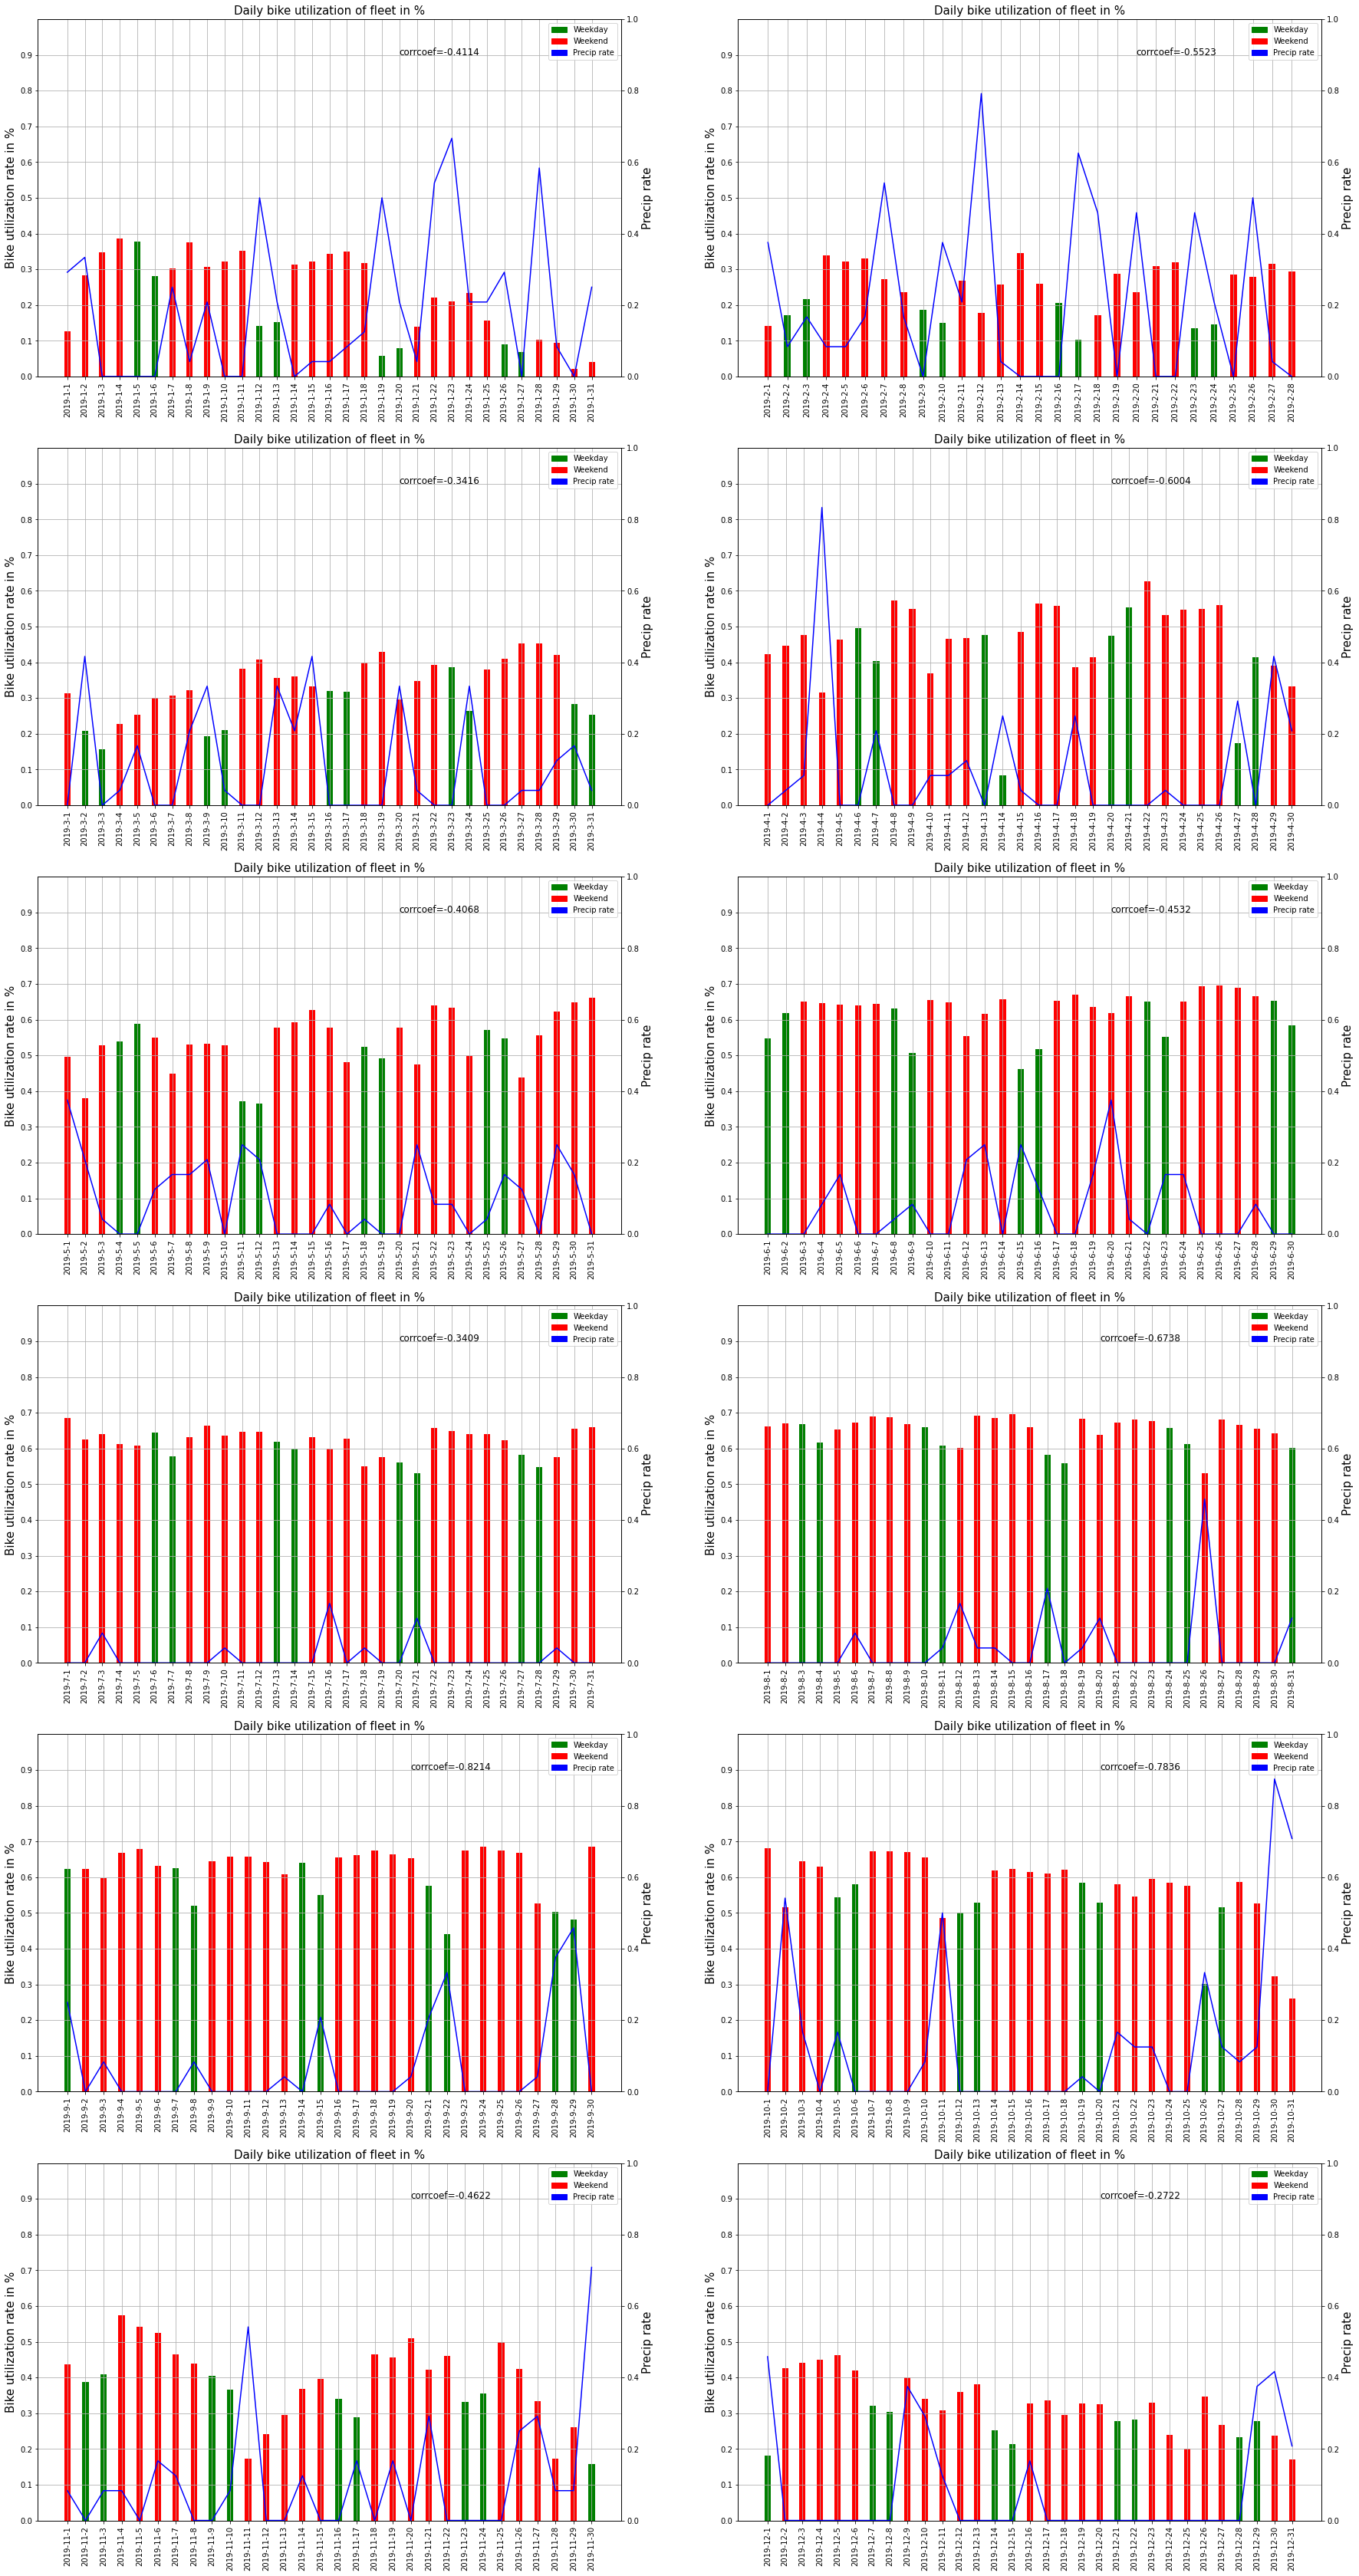

In [19]:
plot_bars_monthly(utilization_daily,precip_daily, 0, 1.0, 0.1, "Daily bike utilization of fleet in %", "Bike utilization rate in %")

<b>Patterns between subplots</b><br>
The subplots also show seasonal utilization across months. Interestingly, in the summer months, daily utilization is close to the level of monthly utilization in the winter months (both 70 percent). This illustrates well the difference in utilization of bike fleet between winter and summer.
<br>
<br>
<b>Patterns within the subplots </b><br>
- Utilization within the week is higher than on weekends (see red and green bars for one month). This difference is particularly evident in the winter months. In the summer months, weekend days almost reach the level of working days. A clear pattern within the working days (for example, Tuesday always records higher utilization than Thursday) is difficult to identify and is therefore not formulated as a statement.
- As with usage, high rainfall rates indicate low utilization rates. This can be observed especially well in January. From mid to late January, high rain rates are recorded and the utilization figures are correspondingly low. More examples can be found on the following days: 2019-11-11, 2019-10-30 and 2019-9-28/2019-9-29. This observation is here as well clearly supported by the negative correlation coefficients. These show that the higher the rain rate, the lower the utilization rate figures.

# 2.2 Geographical Demand Patterns

In the following section, the so called "geographical demand patterns" will be illustrated and investigated. 
The term here refers to the fact that certain metrics such as the number of starting rides will be plotted on a map of Chicago, so that not only the sheer numbers are investigated but also, whether a particular geographical pattern can be derived.

<h2> 2.2.1 Top X Stations </h2>

We begin the description of geographical demand patterns by analysing the top X stations. First, the top 15 stations for starting and ending rentals and the sum of those two are represented. Afterwards, the distribution of stations and their number of interactions are visualized.

<h3> Top 15 Starting, Ending and Sum of Interaction Stations </h3>

First, we just look at the top 15 stations over the year for starting and ending a trip and the sum of that. **We defined interactions as the sum of starting and ending rentals**.

In [20]:
# First compute top 15 starting stations
# Group by the station name and then take the size into a new column counter
annual_top_start = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
# Sort the values descendingly
annual_top_15_start = annual_top_start.sort_values("counter", ascending=False).head(15)
# Sort the top 15 ascendingly for visualization purposes
annual_top_15_start = annual_top_15_start.sort_values("counter")

# Compute top 15 ending stations
annual_top_end = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
annual_top_15_end = annual_top_end.sort_values("counter", ascending=False).head(15)
annual_top_15_end = annual_top_15_end.sort_values("counter")

For the sum of start and end interactions, we create two methods, one for the top X and one for the bottom X stations. These are used in the next section to represent the stations on the map.

In [21]:
# Method for retrieving the top x interaction stations
# Compute sum of start and end, append all values of ending rentals to starting rentals 
# and then group by the station name and sum the counter values. Then sort and take the first x values.
def top_X_interaction_stations(x):
    
    start_interactions = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
    end_interactions = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
    both = start_interactions.append(end_interactions)
    both_sum = both.groupby(both.index.values).sum()
    top_X_interaction_stations = both_sum.sort_values("counter", ascending=False).head(x)
    top_X_interaction_stations = top_X_interaction_stations.sort_values("counter")
    
    return top_X_interaction_stations

In [22]:
# Method for retrieving the bottom x interaction stations
# Compute sum of start and end, append all values of ending rentals to starting rentals 
# and then group by the station name and sum the counter values. Then sort and take the last x values.
def bottom_X_interaction_stations(x):
    
    start_interactions = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
    end_interactions = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
    both = start_interactions.append(end_interactions)
    both_sum = both.groupby(both.index.values).sum()
    bottom_X_interaction_stations = both_sum.sort_values("counter", ascending=False).tail(x)
    bottom_X_interaction_stations = bottom_X_interaction_stations.sort_values("counter")
    
    return bottom_X_interaction_stations

In [23]:
both_sum_top_15 = top_X_interaction_stations(15)

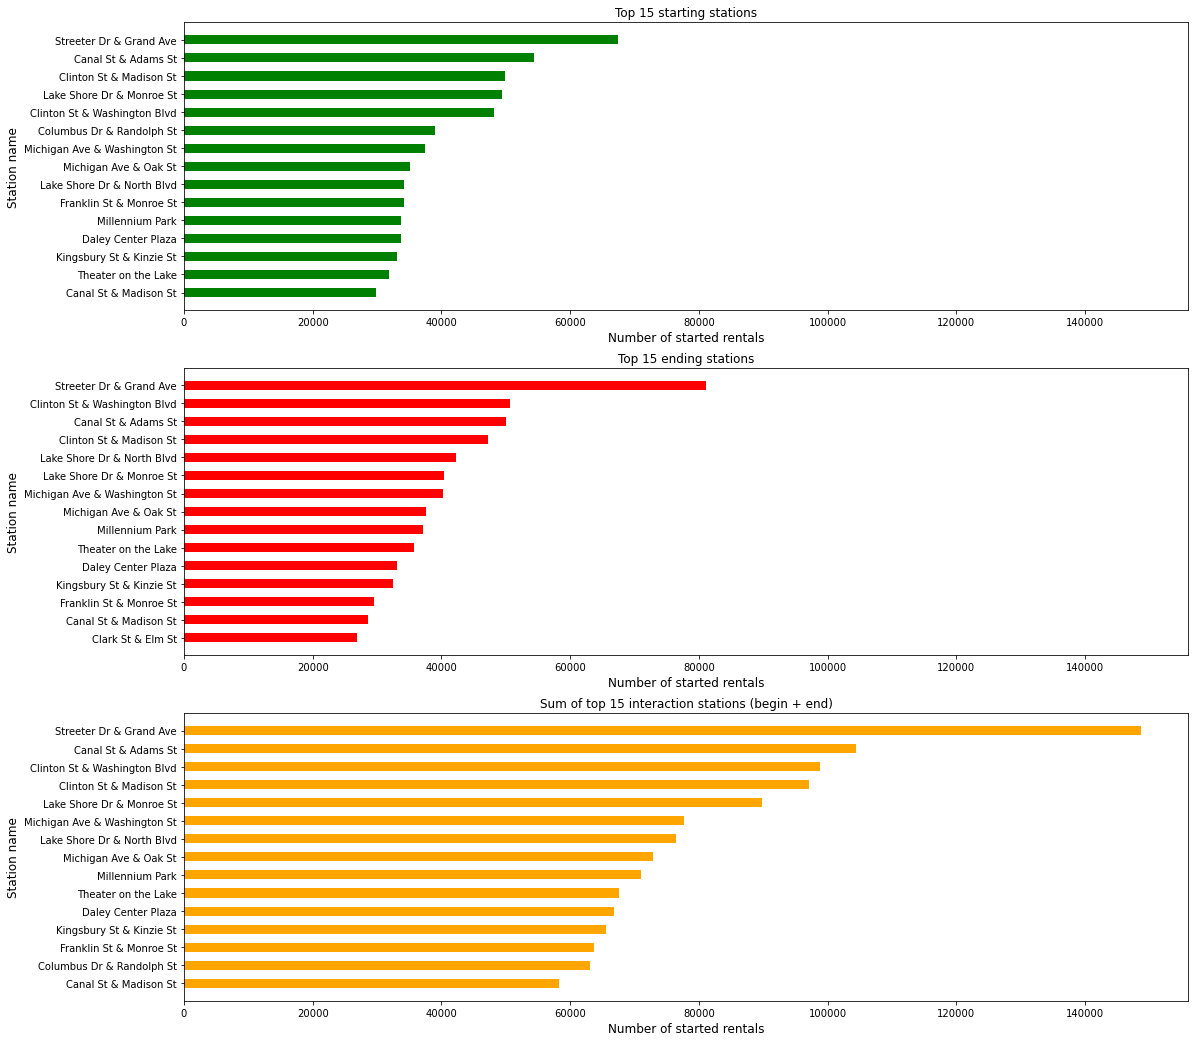

In [24]:
# Plot the data
width = 0.5
labels = annual_top_15_start.index.values

fig, ax = plt.subplots(3,1,figsize=(18,18))

ax[0].barh(labels, annual_top_15_start["counter"], width ,align="center",color="green")
ax[0].set_xlabel('Number of started rentals', fontsize=12)
ax[0].set_ylabel('Station name', fontsize = 12)
ax[0].set_title('Top 15 starting stations')
ax[0].sharex(ax[2])

labels = annual_top_15_end.index.values

ax[1].barh(labels, annual_top_15_end["counter"], width ,align="center",color="red")
ax[1].set_xlabel('Number of started rentals', fontsize=12)
ax[1].set_ylabel('Station name', fontsize = 12)
ax[1].set_title('Top 15 ending stations')
ax[1].sharex(ax[2])

labels = both_sum_top_15.index.values

ax[2].barh(labels, both_sum_top_15["counter"], width ,align="center",color="orange")
#ax[2].set_yticks(y, labels=labels)
ax[2].set_xlabel('Number of started rentals', fontsize=12)
ax[2].set_ylabel('Station name', fontsize = 12)
ax[2].set_title('Sum of top 15 interaction stations (begin + end)')

plt.show()

The station "**Streeter Dr & Grand Ave**" is by far the most used station for starting and ending a bike trip. As can be seen in the third plot, the first five stations have a significant lead compared to the place 6 to 15. As a **dashboard user these stations can be seen as most important and should be monitored carefully to avoid longer maintenance**.

<h3> Distribution of Station Interactions </h3>

As we only concentrate thus far on the top 15 stations, we know want to see the **whole distribution of interactions on all stations**. For that we plot the data for the interactions on each station as a histogram. For the selection of bins, we use the Freedman-Diaconis rule (https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule)

In [25]:
# Compute the top interaction stations, like in the top_X_interaction_stations method, but here we need all stations
start_interactions = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
end_interactions = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
both = start_interactions.append(end_interactions)
both_sum = both.groupby(both.index.values).sum()

# Now compute the Freedman-Diaconis rule
q25, q75 = np.percentile(both_sum, [25, 75])
bin_width = 2 * (q75 - q25) * len(both_sum) ** (-1/3)
number_bins = round((both_sum.max() - both_sum.min()) / bin_width)
print("Freedman–Diaconis number of bins:", number_bins)

Freedman–Diaconis number of bins: counter    41.0
dtype: float64


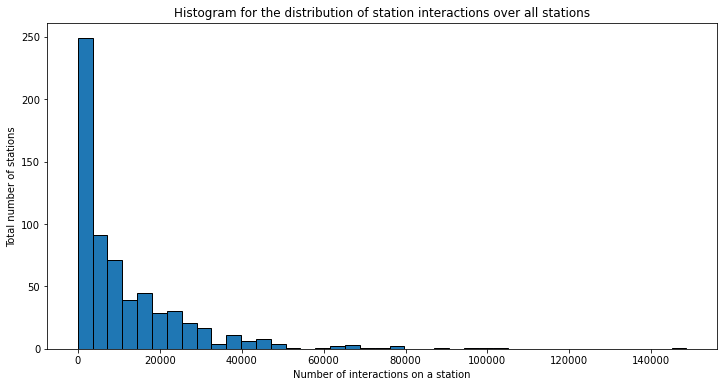

In [26]:
plt.figure(figsize=(12,6))
plt.hist(both_sum, bins=41,edgecolor='k')
plt.ylabel("Total number of stations",fontsize=10)
plt.xlabel("Number of interactions on a station",fontsize=10)
plt.title("Histogram for the distribution of station interactions over all stations",fontsize=12);

A **highly skewed distribution** can be seen. It is visible that the majority of stations only have between 0 and 20.000 interactions, with the most stations even only having a maximum of 4.000 interactions, and thus not being so popular. After 50.000 interactions the number decreases nearly to zero which means that there are only a few stations with large numbers of interactions and many with lower numbers of interactions.

This pattern is also supported through the **mean of nearly 12.000 interactions and the standard deviation of approximately 16.000. Also the 0.75-quantile is really meaningful, stating that 75% of all stations have 16.850 or less interactions**. 

In [27]:
both_sum.describe()

counter
count     641.000000
mean    11857.744150
std     15957.696847
min         2.000000
25%      1356.000000
50%      6277.000000
75%     16850.000000
max    148586.000000

**These stations with lower interaction counts still account for 30% of all interactions across all stations, stating that also the smaller stations are vital for daily business.**

In [28]:
_0_75_quantile = both_sum[both_sum["counter"] <= 16850]
sum_0_75_quantile = _0_75_quantile["counter"].sum()

total_sum_of_interactions = both_sum["counter"].sum()

percentage = sum_0_75_quantile/total_sum_of_interactions
percentage

0.30895243588384086

<h3> Top 5 Stations Hourly </h3>

We conclude this demand pattern by additonally showing the top 5 stations on each hour. These stations could be used in a dashboard on an hourly basis to show the user on which stations the most interactions occur and consequently which stations should be looked at the most.

In [29]:
# Add a new column which only has the full hour of a bike trips (measured on the start time)
divvy_bike_set_hrl = divvy_bike_set.reset_index().set_index('full_hour_start')
divvy_bike_set_hrl["full_hour"] = divvy_bike_set_hrl.index.hour

In [30]:
# We create a function to retrieve the top X start stations on each hour
def top_X_start_stations_hourly(x):
    
    # First, we count each entry (bike rental) for each hour on each station.
    # Therefore, group by the full hour and station name, then transform it to a dataframe and add column counter
    divvy_bike_set_hourly_station_grouped = divvy_bike_set_hrl.groupby(["full_hour","start_station_name"]).size().to_frame('counter')

    # Next, we need to group again by the counter and then by the full hour to then retrieve the top 5 values
    divvy_bike_set_hourly_station_grouped = divvy_bike_set_hourly_station_grouped['counter'].groupby('full_hour', group_keys=False)
    top_X_start_stations_hourly = divvy_bike_set_hourly_station_grouped.apply(lambda y: y.sort_values(ascending=False).head(x))
    return top_X_start_stations_hourly

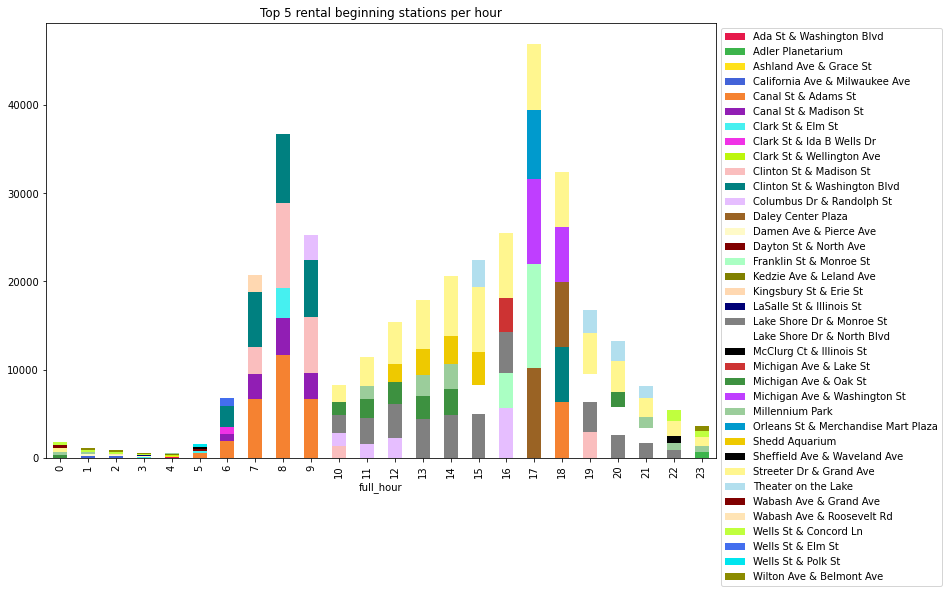

In [31]:
# Now, we call the function for the top 5 start stations and the plot it
top_X_start_stations_hourly = top_X_start_stations_hourly(5)
# We need more colours for all the different stations, taken from https://www.webucator.com/article/python-color-constants-module/
cl =['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000', '#CD3333','#3D9140','#BF3EFF','#9BCD9B','#009ACD','#EEC900','#030303','#FFF68F','#B2DFEE','#800000','#FFE4B5','#C0FF3E','#436EEE','#00E5EE','#8B8B00']
# Plot the data with the legend outside
top_X_start_stations_hourly.unstack().plot(kind='bar', color=cl, stacked=True, figsize=(12,8), title="Top 5 rental beginning stations per hour").legend(bbox_to_anchor=(1.0, 1.0))

In [32]:
# Now, we do the exact same thing for the top X stopped by stations per hour
def top_X_ending_stations_hourly(x):

    divvy_bike_set_hourly_station_end_grouped = divvy_bike_set_hrl.groupby(["full_hour","end_station_name"]).size().to_frame('counter')
    divvy_bike_set_hourly_station_end_grouped = divvy_bike_set_hourly_station_end_grouped['counter'].groupby('full_hour', group_keys=False)
    top_X_ending_stations_hourly = divvy_bike_set_hourly_station_end_grouped.apply(lambda y: y.sort_values(ascending=False).head(x))
    return top_X_ending_stations_hourly

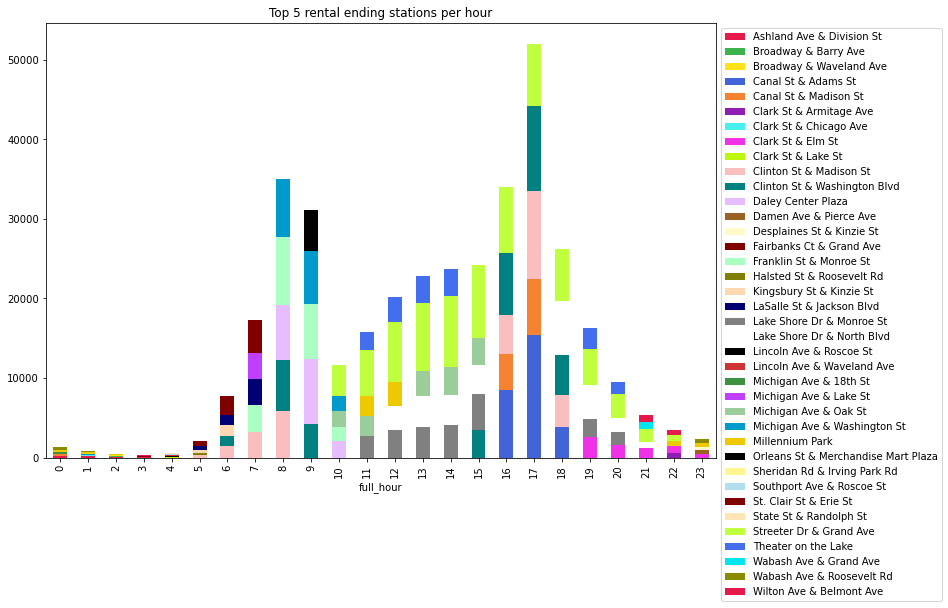

In [33]:
# Now, we call the function for the top 5 ending stations and the plot it
top_X_ending_stations_hourly = top_X_ending_stations_hourly(5)
# Plot the data with the legend outside
cl =['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000', '#CD3333','#3D9140','#BF3EFF','#9BCD9B','#009ACD','#EEC900','#030303','#FFF68F','#B2DFEE','#800000','#FFE4B5','#C0FF3E','#436EEE','#00E5EE','#8B8B00']
top_X_ending_stations_hourly.unstack().plot(kind='bar', color=cl, stacked=True, figsize=(12,8), title="Top 5 rental ending stations per hour").legend(bbox_to_anchor=(1.0, 1.0))

**Before moving on to the geographical visualization of the top X stations, we again finish by summarizing the main observations:** <br>

- Few stations have a high amount of interactions
- The top 25% make up 78% of all interactions
- The majority of stations have a lower amount of interactions but are still vital for daily business
- The top hourly stations vary heavily while some stations are representend more often


<h2> 2.2.2 Plotting the Top X Stations Geographically </h2>

Firstly, the stations are ranked according to the 50 highest and 50 lowest stations in terms of the number of rides as described above. They are subsequently plotted on a map of Chicago, to be able to scrutinize, which regions exhibit high traffic and which do not. A specific function is written to yield the respective list of stations, which is then merged with the location data. 

In [34]:
#Now, we want to map the top x stations in terms of their interactions (Basti - Formulierung) and define a function accordingly

def top_X_interaction_stations(x):
    
    start_interactions = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
    end_interactions = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
    both = start_interactions.append(end_interactions)
    both_sum = both.groupby(both.index.values).sum()
    top_X_interaction_stations = both_sum.sort_values("counter", ascending=False).head(x)
    top_X_interaction_stations = top_X_interaction_stations.sort_values("counter")
    #In order to yield the coordinates, we merge the result on the locations data
    top_X_interaction_stations.reset_index(inplace = True)
    top_X_interaction_stations.rename(columns = {"index": "Station Name"}, inplace = True)
    top_X_interaction_stations = top_X_interaction_stations.merge(locations, on = "Station Name")[["ID", "Station Name", "counter", "Latitude", "Longitude"]]
    top_X_interaction_stations["Top"] = list(map(lambda x: True, top_X_interaction_stations["Station Name"])) 
    return top_X_interaction_stations

In [35]:
#Now, we want to map the bottom x stations in terms of their interactions (Basti - Formulierung) and define a function accordingly

def bottom_X_interaction_stations(x):
    
    start_interactions = divvy_bike_set.groupby("start_station_name").size().to_frame('counter')
    end_interactions = divvy_bike_set.groupby("end_station_name").size().to_frame('counter')
    both = start_interactions.append(end_interactions)
    both_sum = both.groupby(both.index.values).sum()
    bottom_X_interaction_stations = both_sum.sort_values("counter", ascending=False).tail(x)
    bottom_X_interaction_stations = bottom_X_interaction_stations.sort_values("counter")
    #In order to yield the coordinates, we merge the result on the locations data
    bottom_X_interaction_stations.reset_index(inplace = True)
    bottom_X_interaction_stations.rename(columns = {"index": "Station Name"}, inplace = True)
    bottom_X_interaction_stations = bottom_X_interaction_stations.merge(locations, on = "Station Name")[["ID", "Station Name", "counter", "Latitude", "Longitude"]]
    bottom_X_interaction_stations["Bottom"] = list(map(lambda x: True, bottom_X_interaction_stations["Station Name"])) 
    
    return bottom_X_interaction_stations

In [36]:
#We now select the top and bottom 50 stations, as well as all stations. The latter is done in order to be able to plot 
#all counter values for every station later on
#We also read in the pure location data to have a clean source
locations = pd.read_csv("../data/Divvy_Bicycle_Stations-2.csv")
top_stations = top_X_interaction_stations(50)
bottom_stations = bottom_X_interaction_stations(50)
all_stations = top_X_interaction_stations(len(locations))[["ID", "counter"]]
#We save the IDs of the rspective stations to mark them in the list of stations
top_IDs = top_stations["ID"]
bottom_IDs = bottom_stations["ID"]




In [37]:
#We now add a column for each bottom and top values, whcih contains True if the respective station is to be sorted in the repsective category
locations_rank = locations
locations_rank["rank_top"] = list(map(lambda x: True if x in top_IDs.values else False, locations_rank["ID"]))
locations_rank["rank_bottom"] = list(map(lambda x: True if x in bottom_IDs.values else False, locations_rank["ID"]))
locations.head()

ID                  Station Name  Total Docks  Docks in Service  \
0  373      Kedzie Ave & Chicago Ave           11                11   
1  186          Ogden Ave & Race Ave           15                15   
2  102    Stony Island Ave & 67th St           11                11   
3  438  Central Park Ave & Ogden Ave           15                15   
4  656  Damen Ave & Walnut (Lake) St           15                15   

       Status   Latitude  Longitude                                  Location  \
0  In Service  41.895465 -87.706128          (41.89546530305, -87.7061278837)   
1  In Service  41.891795 -87.658751                   (41.891795, -87.658751)   
2  In Service  41.773458 -87.585340          (41.77345849948, -87.5853397391)   
3  In Service  41.854064 -87.715117  (41.854063503874464, -87.71511733531952)   
4  In Service  41.885951 -87.677009                   (41.885951, -87.677009)   

   rank_top  rank_bottom  
0     False        False  
1     False        False  
2     False        False  
3     False        False  
4     False        False

In [38]:
#Create the geometry points to use the in the geopanda plot function
geometry = [Point(xy) for xy  in zip(locations_rank["Longitude"], locations_rank["Latitude"])]

#Set the coordinates to standard 
crs = {'init':'EPSG:4326'}

#create a geopanda dataframe with defined coordinates and geometry
locations_geo = geopandas.GeoDataFrame(locations_rank, crs = crs, geometry = geometry)
locations_geo = locations_geo.merge(all_stations, on = "ID")
locations_geo.head()

/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ID                  Station Name  Total Docks  Docks in Service  \
0  373      Kedzie Ave & Chicago Ave           11                11   
1  186          Ogden Ave & Race Ave           15                15   
2  102    Stony Island Ave & 67th St           11                11   
3  438  Central Park Ave & Ogden Ave           15                15   
4  648        Carpenter St & 63rd St            7                 7   

       Status   Latitude  Longitude                                  Location  \
0  In Service  41.895465 -87.706128          (41.89546530305, -87.7061278837)   
1  In Service  41.891795 -87.658751                   (41.891795, -87.658751)   
2  In Service  41.773458 -87.585340          (41.77345849948, -87.5853397391)   
3  In Service  41.854064 -87.715117  (41.854063503874464, -87.71511733531952)   
4  In Service  41.779870 -87.650919                    (41.77987, -87.650919)   

   rank_top  rank_bottom                    geometry  counter  
0     False        False  POINT (-87.70613 41.89547)     1520  
1     False        False  POINT (-87.65875 41.89180)    16534  
2     False        False  POINT (-87.58534 41.77346)      371  
3     False        False  POINT (-87.71512 41.85406)      429  
4     False         True  POINT (-87.65092 41.77987)       34

<h3> Mapping of the Top X stations </h3>

The most visitied stations in terms of the above calculated measures are plotted in red, the least ones in blue. All other stations are added in light black. It is evident that the most utilized stations are found in the very center of Chicago, whilst the least utilized ones are scattered mostly around the outskirts.


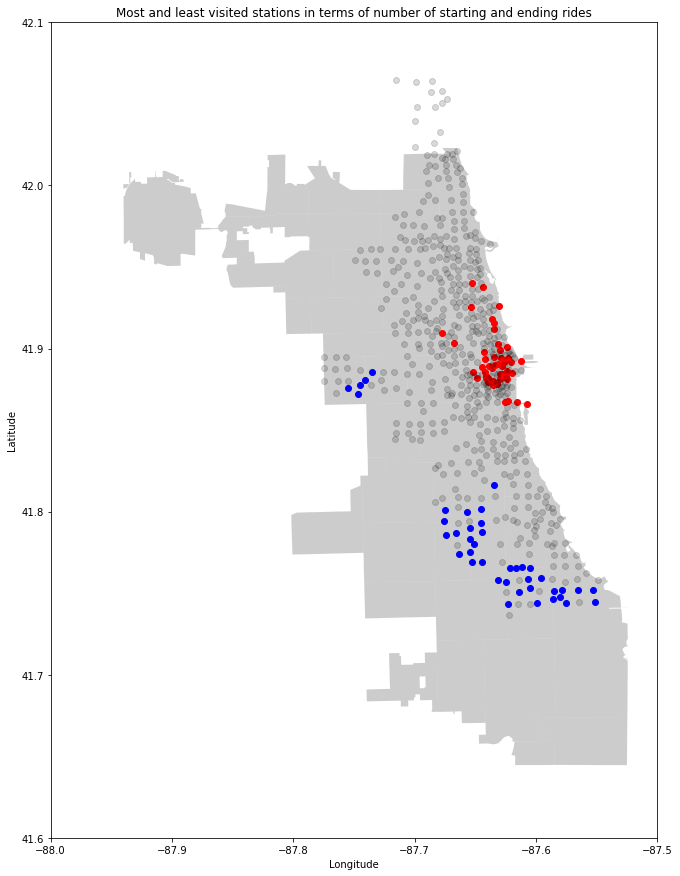

In [39]:
#Now, plot the data for the top stations in red, the bottom stations in blue and all other stations in light black

#Read the location data

csw = pd.read_csv("./../data/bike_weather_location_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])

#read the first map of Chicago

chic = geopandas.read_file('./../data/GeoData/geo_export_47a238d3-5bf0-4900-bed9-7bd4e1bc537b.shp')

#Read the bikeroute map of chicago
chic_bikeroutes = geopandas.read_file('./../data/GeoData/geo_export_d8ceb39a-8ca1-49cb-83d5-ee64ef451b05.shp')

locations_geo_top = locations_geo[locations_geo["rank_top"] == True]
locations_geo_bottom = locations_geo[locations_geo["rank_bottom"] == True]
locations_geo_neither = locations_geo[(locations_geo["rank_bottom"] == False) & (locations_geo["rank_top"] == False)]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
locations_geo_top.plot(ax = ax, color = "red")
locations_geo_bottom.plot(ax = ax, color = "blue")
locations_geo_neither.plot(ax = ax, color = "black", alpha = 0.15)
plt.title("Most and least visited stations in terms of number of starting and ending rides")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h3> Mapping the number of starting and ending rides </h3>
Whilst in the plot above, the 50 most and least utilized stations were mapped, now the values themselves are plotted, after they have been logarithmized. A clear three-ring-structure arises: The centre of Chicago is most heavily visited, while the outskirts (meaning areas not directly in the centre of Chicago) are least often frequented. In between, mediocre values are present, creating an "intermediary" ring. 


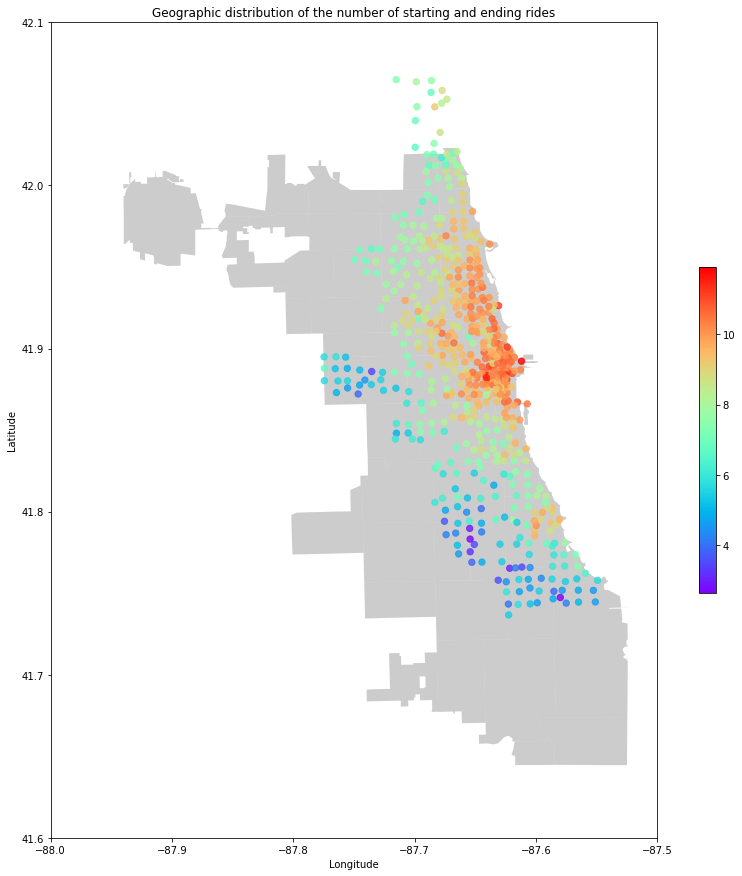

In [40]:
#Now, we plot the stations according to their counter value, which has been logarithmized

locations_geo["counter_log"] = np.log(locations_geo["counter"])

fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
#geo_df.plot(ax=ax, alpha = .1)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
locations_geo.plot(column = 'counter_log', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.4}, alpha = 0.8, 
            markersize = 40)
plt.title("Geographic distribution of the number of starting and ending rides")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h2> 2.2.3 Visualizing Further Geospatial Data </h2>
In the following section, some of the riding data is plotted on a schematic map of Chicago. In order to do that, the location data together with ride and weather data is loaded and a sample of 10000 data points is collected, to maintain computability. 


<h3> Plotting the number of rides </h3>
In the following plot, each dot represents one ride that has been started at that location. With the parameter alpha, more dense areas are emphasized. It can be easily seen that most of the rides start in the center of Chicago and along the coast, whilst moving to the outskirts of the city decreases the density of rides. The data can thus be clustered into three areas: The core of the city, with the most dense network, then the surroundings of that core that are still centrally located in Chicago and lastly, the outskirts are, where only minor amounts of rides are started. 


In [41]:
#Read the location data

cwl = pd.read_csv("./../data/bike_weather_location_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])

#csw = pd.read_csv("./../data/bike_weather_location_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])

#read the first map of Chicago

chic = geopandas.read_file('./../data/GeoData/geo_export_47a238d3-5bf0-4900-bed9-7bd4e1bc537b.shp')

#Read the bikeroute map of chicago
chic_bikeroutes = geopandas.read_file('./../data/GeoData/geo_export_d8ceb39a-8ca1-49cb-83d5-ee64ef451b05.shp')

#Sample a data of 10000 to yield a reasonable dataset
cwl_sample = cwl.sample(10000)

#Create the geometry points to use the in the geopanda plot function
geometry = [Point(xy) for xy  in zip(cwl_sample["Start_Longitude"], cwl_sample["Start_Latitude"])]

#Set the coordinates to standard 
crs = {'init':'EPSG:4326'}

#create a geopanda dataframe with defined coordinates and geometry
geo_df = geopandas.GeoDataFrame(cwl_sample, crs = crs, geometry = geometry)


/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


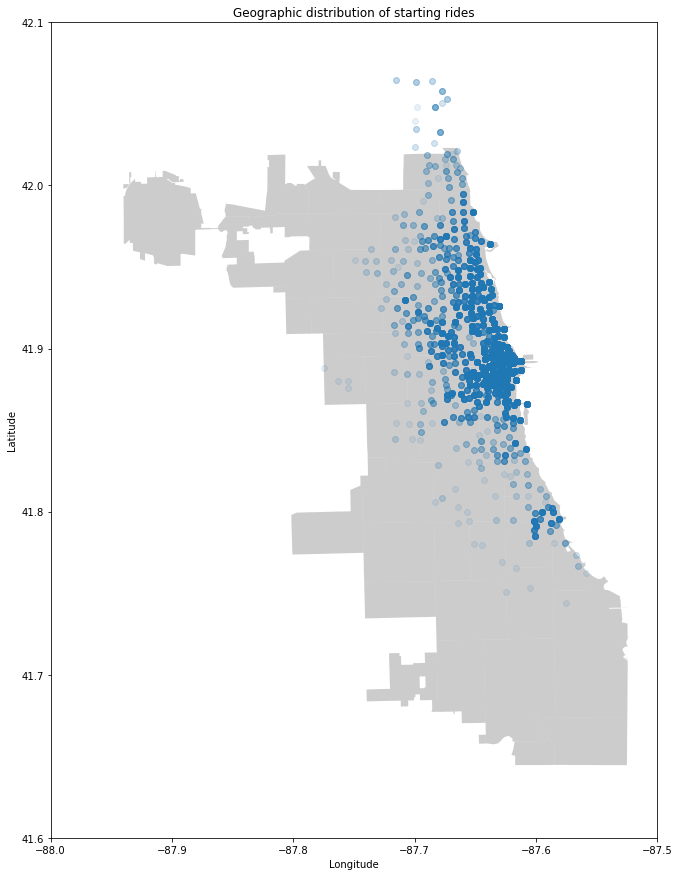

In [42]:
#scatter the usage incidents
fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
geo_df.plot(ax=ax, alpha = .1)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
plt.title("Geographic distribution of starting rides")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h3> Investigation of the location data of each individual station </h3>
In the next section, we will depict each station as one point and illustrate how many rides started there. In order to do that, we group the rides per station and merge them back with the location data to yield longitude and latitude for each station.


In [43]:
#Group all rows and selected columns by Start Station count in order to scrutinize how often certain stations were
#used as starting point

cwl_sample = cwl

loc = locations.rename(columns = {"ID": "start_station_id"})

amount = cwl_sample[["start_station_id", "start_station_name"]]

amount_group = amount.groupby("start_station_id").count()
amount_group.reset_index(inplace = True)

#cwl_small = cwl_sample[["start_station_id", "Start_Latitude", "End_Latitude", "Start_Longitude", "End_Longitude",  "Location"]]

amount_group = pd.merge(loc, amount_group, on='start_station_id')

#amount_group = amount_group.drop(["Station Name", "Total Docks", "Docks in Service", "Status"], axis = 1)

amount_group.head(10)

start_station_id                  Station Name  Total Docks  \
0               373      Kedzie Ave & Chicago Ave           11   
1               186          Ogden Ave & Race Ave           15   
2               102    Stony Island Ave & 67th St           11   
3               438  Central Park Ave & Ogden Ave           15   
4               656  Damen Ave & Walnut (Lake) St           15   
5               648        Carpenter St & 63rd St            7   
6               658      Leavitt St & Division St           15   
7                35       Streeter Dr & Grand Ave           47   
8               632         Clark St & Newport St           15   
9               643                    Smith Park           15   

   Docks in Service      Status   Latitude  Longitude  \
0                11  In Service  41.895465 -87.706128   
1                15  In Service  41.891795 -87.658751   
2                11  In Service  41.773458 -87.585340   
3                15  In Service  41.854064 -87.715117   
4                15  In Service  41.885951 -87.677009   
5                 7  In Service  41.779870 -87.650919   
6                15  In Service  41.902997 -87.683825   
7                47  In Service  41.892278 -87.612043   
8                15  In Service  41.944540 -87.654678   
9                15  In Service  41.892048 -87.689397   

                                   Location  rank_top  rank_bottom  \
0          (41.89546530305, -87.7061278837)     False        False   
1                   (41.891795, -87.658751)     False        False   
2          (41.77345849948, -87.5853397391)     False        False   
3  (41.854063503874464, -87.71511733531952)     False        False   
4                   (41.885951, -87.677009)     False        False   
5                    (41.77987, -87.650919)     False         True   
6                   (41.902997, -87.683825)     False        False   
7                   (41.892278, -87.612043)      True        False   
8                    (41.94454, -87.654678)     False        False   
9                   (41.892048, -87.689397)     False        False   

                     geometry  start_station_name  
0  POINT (-87.70613 41.89547)                 661  
1  POINT (-87.65875 41.89180)                7956  
2  POINT (-87.58534 41.77346)                 177  
3  POINT (-87.71512 41.85406)                 232  
4  POINT (-87.67701 41.88595)                1844  
5  POINT (-87.65092 41.77987)                  13  
6  POINT (-87.68382 41.90300)                2566  
7  POINT (-87.61204 41.89228)               67216  
8  POINT (-87.65468 41.94454)                8857  
9  POINT (-87.68940 41.89205)                1011

In [44]:
#Here, we rename our count column accordingly and create another geo dataframe to plot
amount_group.rename(columns = {"start_station_name": "count"}, inplace = True)
geometry2 = [Point(xy) for xy  in zip(amount_group["Longitude"], amount_group["Latitude"])]

geo_group_df = geopandas.GeoDataFrame(amount_group, crs = crs, geometry = geometry2)
geo_group_df.head()

/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


start_station_id                  Station Name  Total Docks  \
0               373      Kedzie Ave & Chicago Ave           11   
1               186          Ogden Ave & Race Ave           15   
2               102    Stony Island Ave & 67th St           11   
3               438  Central Park Ave & Ogden Ave           15   
4               656  Damen Ave & Walnut (Lake) St           15   

   Docks in Service      Status   Latitude  Longitude  \
0                11  In Service  41.895465 -87.706128   
1                15  In Service  41.891795 -87.658751   
2                11  In Service  41.773458 -87.585340   
3                15  In Service  41.854064 -87.715117   
4                15  In Service  41.885951 -87.677009   

                                   Location  rank_top  rank_bottom  \
0          (41.89546530305, -87.7061278837)     False        False   
1                   (41.891795, -87.658751)     False        False   
2          (41.77345849948, -87.5853397391)     False        False   
3  (41.854063503874464, -87.71511733531952)     False        False   
4                   (41.885951, -87.677009)     False        False   

                     geometry  count  
0  POINT (-87.70613 41.89547)    661  
1  POINT (-87.65875 41.89180)   7956  
2  POINT (-87.58534 41.77346)    177  
3  POINT (-87.71512 41.85406)    232  
4  POINT (-87.67701 41.88595)   1844

<h3> Plotting the (logarithmic) number of rides starting at each station </h3>
It can be clearly seen that the station in the centre of Chicago exhibit the by far highest number of starting rides (pay attention that the scale is logarithmic). Then again, a second "belt" around the core city can be drawn that exhibits less numbers of rides, whilst the "blue" outskirts exhibit the lowest number of rides. 


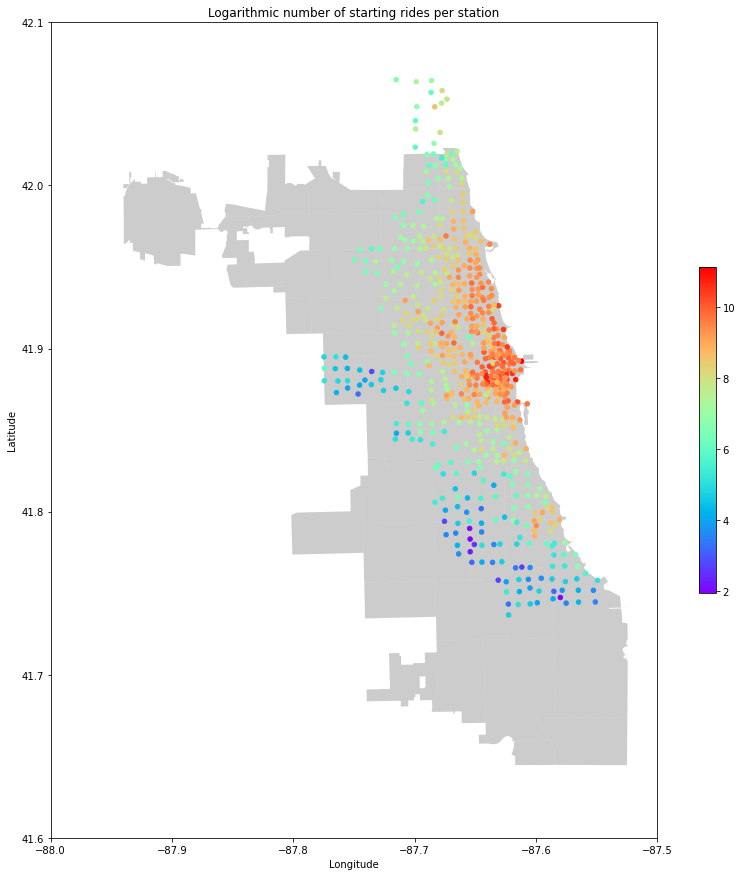

In [45]:
#Map the unique stations on the Chicago map and create a heatmap based on the logarithmic number of usages per station

geo_group_df["log_count"] = np.log(geo_group_df["count"])

fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
#geo_df.plot(ax=ax, alpha = .1)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
geo_group_df.plot(column = 'log_count', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.4}, 
            markersize = 20)
plt.title("Logarithmic number of starting rides per station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2.3 Key Performance Indicators (KPIs)

<h2> 2.3.1 Introduction and Data Preparation for the First Two KPIs </h2>
In the following section, two KPIs, along with geospatial data, will be analysed. The first KPI scrutinizes the number of trips per unique bicycle. The definition of "unique bicycle" comprises two versions: Firstly, all unique bicycles used in the entire year and secondly, all unique bicycles used in one day. The latter one is the more important one, because we argue, that not all bikes might be usable throughout the entire year and calculating daily active bikes gives a better representation of reality. The KPI is derived from the Article "Impacts of 4th generation bike-sharing Case study city of Delft" by Sven Boor (Impacts of 4th generation bike-sharing - TU Delft Repositorieshttps://repository.tudelft.nl › OBJ › download), although we adapted the KPI by also calculating hourly values, not only daily ones, in order to fulfill the task. 
One has to bear in mind that this KPI is closely related to the revenue-KPI (which follows further down below), as both are based on the number of trips (usages) per day/per hour. The only difference is, that they are measured with distinct scalars. Thus, they exhibit a rather similar behavior when put in juxtaposition. Especially in the prooject repot, we will also refer to this first KPI as "RPUG", meanging Rides Per Unique Bike.

The second KPI takes into account not only usages, but also station capacity. The latter metric is derived from the locations dataset, that is additionally available on the divvy website. The source for the capacity of each individual station is the "Docks in Service" column. We assume that this number indicates how many bikes can be stationed in one place, at most. The information on the website does not speak against this assumption. We will also refer to this KPI 2 as "Demand-Capacity". 

It is important to notice that since our year of investigation, 2019, stations were added to the divvy system. However, they use an incrementing number system, which means that every new station is assigned with an incremented id. Thus, the ID per station does not change for existing stations. This allows us to make use of the data without having to take into account that in the meantime, stations have been added. 



In [46]:
#Read in data for KPIs
data_ = pd.read_csv("../data/bike_weather_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])
data_.head()

start_time            end_time  start_station_id  end_station_id  \
0 2019-01-01 00:04:37 2019-01-01 00:11:07               199              84   
1 2019-01-01 00:08:13 2019-01-01 00:15:34                44             624   
2 2019-01-01 00:13:23 2019-01-01 00:27:12                15             644   
3 2019-01-01 00:13:45 2019-01-01 00:43:28               123             176   
4 2019-01-01 00:14:52 2019-01-01 00:20:56               173              35   

                    start_station_name                end_station_name  \
0               Wabash Ave & Grand Ave       Milwaukee Ave & Grand Ave   
1               State St & Randolph St  Dearborn St & Van Buren St (*)   
2                 Racine Ave & 18th St   Western Ave & Fillmore St (*)   
3       California Ave & Milwaukee Ave               Clark St & Elm St   
4  Mies van der Rohe Way & Chicago Ave         Streeter Dr & Grand Ave   

   bike_id   user_type    duration_time  duration_sec  duration_min  \
0     2167  Subscriber  0 days 00:06:30         390.0      6.500000   
1     4386  Subscriber  0 days 00:07:21         441.0      7.350000   
2     1524  Subscriber  0 days 00:13:49         829.0     13.816667   
3      252  Subscriber  0 days 00:29:43        1783.0     29.716667   
4     1170  Subscriber  0 days 00:06:04         364.0      6.066667   

   duration_hour  weekday_start full_hour_start       full_hour_end  max_temp  \
0       0.108333           True      2019-01-01 2019-01-01 00:00:00       1.1   
1       0.122500           True      2019-01-01 2019-01-01 00:00:00       1.1   
2       0.230278           True      2019-01-01 2019-01-01 00:00:00       1.1   
3       0.495278           True      2019-01-01 2019-01-01 01:00:00       1.1   
4       0.101111           True      2019-01-01 2019-01-01 00:00:00       1.1   

   precip  hour  interpol  Quarter  
0     1.0     0     False        1  
1     1.0     0     False        1  
2     1.0     0     False        1  
3     1.0     0     False        1  
4     1.0     0     False        1

In [47]:
#Add the rounded days to calculate the KPIs also on a daily basis
data_["Start_day"] = data_["start_time"].dt.round('D')
len(data_["Start_day"].unique())

366

In [48]:
#As we only investigate 365 days, clean the rounded data by removing values from 2020:
data_["invalid"] = list(map(lambda x: x == datetime.datetime.strptime("2020-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), data_["Start_day"]))
data_ = data_[data_["invalid"] == False]
len(data_["Start_day"].unique())

365

In [49]:
data_.head()

start_time            end_time  start_station_id  end_station_id  \
0 2019-01-01 00:04:37 2019-01-01 00:11:07               199              84   
1 2019-01-01 00:08:13 2019-01-01 00:15:34                44             624   
2 2019-01-01 00:13:23 2019-01-01 00:27:12                15             644   
3 2019-01-01 00:13:45 2019-01-01 00:43:28               123             176   
4 2019-01-01 00:14:52 2019-01-01 00:20:56               173              35   

                    start_station_name                end_station_name  \
0               Wabash Ave & Grand Ave       Milwaukee Ave & Grand Ave   
1               State St & Randolph St  Dearborn St & Van Buren St (*)   
2                 Racine Ave & 18th St   Western Ave & Fillmore St (*)   
3       California Ave & Milwaukee Ave               Clark St & Elm St   
4  Mies van der Rohe Way & Chicago Ave         Streeter Dr & Grand Ave   

   bike_id   user_type    duration_time  duration_sec  ...  weekday_start  \
0     2167  Subscriber  0 days 00:06:30         390.0  ...           True   
1     4386  Subscriber  0 days 00:07:21         441.0  ...           True   
2     1524  Subscriber  0 days 00:13:49         829.0  ...           True   
3      252  Subscriber  0 days 00:29:43        1783.0  ...           True   
4     1170  Subscriber  0 days 00:06:04         364.0  ...           True   

   full_hour_start       full_hour_end max_temp precip  hour  interpol  \
0       2019-01-01 2019-01-01 00:00:00      1.1    1.0     0     False   
1       2019-01-01 2019-01-01 00:00:00      1.1    1.0     0     False   
2       2019-01-01 2019-01-01 00:00:00      1.1    1.0     0     False   
3       2019-01-01 2019-01-01 01:00:00      1.1    1.0     0     False   
4       2019-01-01 2019-01-01 00:00:00      1.1    1.0     0     False   

   Quarter  Start_day  invalid  
0        1 2019-01-01    False  
1        1 2019-01-01    False  
2        1 2019-01-01    False  
3        1 2019-01-01    False  
4        1 2019-01-01    False  

[5 rows x 22 columns]

<h2> 2.3.2 Calculation of the First KPI (Rides Per Unique Bike, RPUB) </h2>
In this section, the first KPI, KPI 1, is calculated in two versions. First of all, the number of usages (counted in terms of starting times, representing individual rides) is calculated on a daily basis. Then, the number of unique bicycles is calculated in terms of how many unique bikes were active (that is, were used) on each single day and throughout the entire year. The reason why we distinguish between those two versions is the following: The above cited Paper by Boor (2019) measures the number of unique bikes per year, that is, he investigates how many individual bikes are available in one entire year. To compare our KPI 1 with his benchmarks, we select a similar approach. However, we argue that not every bike is available every day throughout the year. Hence, we decided to develop another version of KPI 1 on a daily unique bicycle basis, that means we investigate how many unique bikes are available per day.

In [50]:
#Average daily number of trips 

usage_perday = data_.groupby("Start_day").count()

In [51]:
#Now, calculate how many bikes were active each day:
bike_perday = data_.groupby("Start_day").nunique()[["bike_id"]]
bike_perday.reset_index(inplace = True)


In [52]:
#Rename the columns
bike_perday.rename(columns = {"bike_id" : "unique_bike_id"}, inplace = True)

In [53]:
#To have both versions in one table, we merge them
usage_perday = usage_perday.merge(bike_perday, on = "Start_day")
usage_perday.head()
    

Start_day  start_time  end_time  start_station_id  end_station_id  \
0 2019-01-01         444       444               444             444   
1 2019-01-02        2672      2672              2672            2672   
2 2019-01-03        4397      4397              4397            4397   
3 2019-01-04        5888      5888              5888            5888   
4 2019-01-05        5896      5896              5896            5896   

   start_station_name  end_station_name  bike_id  user_type  duration_time  \
0                 444               444      444        444            444   
1                2672              2672     2672       2672           2672   
2                4397              4397     4397       4397           4397   
3                5888              5888     5888       5888           5888   
4                5896              5896     5896       5896           5896   

   ...  weekday_start  full_hour_start  full_hour_end  max_temp  precip  hour  \
0  ...            444              444            444       444     444   444   
1  ...           2672             2672           2672      2672    2672  2672   
2  ...           4397             4397           4397      4397    4397  4397   
3  ...           5888             5888           5888      5888    5888  5888   
4  ...           5896             5896           5896      5896    5896  5896   

   interpol  Quarter  invalid  unique_bike_id  
0       444      444      444             359  
1      2672     2672     2672            1386  
2      4397     4397     4397            1847  
3      5888     5888     5888            2216  
4      5896     5896     5896            2320  

[5 rows x 23 columns]

<h3> Taking into account basic weather data </h3>
To be able to also take into account some of the weather data, two metrics are developed. Firstly, if more than half of all rides on one day started during rain (precip = 1), then the day is counted as "rainday". Secondly, if the average temperature was above ten degrees, the day was counted as "warmday". 


In [54]:
#In order to also take into account mean weather data, apply groupby in terms of mean()
raindaygroup = data_.groupby("Start_day").mean()

In [55]:
#If more than half of the trips started in one day were started during rainy weather, count those days as rainy
#If the average max Temperature was higher than 10 degrees, count that day as warm day

raindaygroup["Rainday"] = list(map(lambda x: True if x >= 0.5 else False, raindaygroup["precip"]))
raindaygroup["Warmday"] = list(map(lambda x: True if x >= 10 else False, raindaygroup["max_temp"]))

In [56]:
raindaygroup.head()

start_station_id  end_station_id      bike_id  duration_sec  \
Start_day                                                                 
2019-01-01        205.227477      217.563063  3326.659910    755.979730   
2019-01-02        207.279566      187.664296  3507.366018    661.480165   
2019-01-03        191.278144      191.044803  3403.886741    636.980896   
2019-01-04        191.153363      187.961447  3403.318784    729.338485   
2019-01-05        196.535109      206.954885  3359.139417    872.798338   

            duration_min  duration_hour  weekday_start  max_temp    precip  \
Start_day                                                                    
2019-01-01     12.599662       0.209994       1.000000 -1.007320  0.175676   
2019-01-02     11.024669       0.183744       1.000000 -2.144760  0.577470   
2019-01-03     10.616348       0.176939       1.000000 -2.719195  0.116898   
2019-01-04     12.155641       0.202594       1.000000  1.781776  0.000000   
2019-01-05     14.546639       0.242444       0.752374  5.859583  0.000000   

                 hour  interpol  Quarter  invalid  Rainday  Warmday  
Start_day                                                            
2019-01-01   7.159910  0.096847      1.0      0.0    False    False  
2019-01-02  10.868638  0.104042      1.0      0.0     True    False  
2019-01-03  12.956334  0.174665      1.0      0.0    False    False  
2019-01-04  13.572860  0.000000      1.0      0.0    False    False  
2019-01-05  14.868555  0.000000      1.0      0.0    False    False

In [57]:
#Reset Index to be able to slice
raindaygroup.reset_index(inplace = True)

In [58]:
#Slice only the desired information
rdg = raindaygroup[["Start_day", "Rainday", "Warmday", "max_temp"]]

<h3> Calculating concrete KPI 1 values </h3>
Now, the concrete values for the KPI 1 (Rides per bike) with yearly unique bikes and daily unique bikes are calculated. Firstly, there are 6017 unique bikes per year. Thus, the number of rides per day is divided by 6017 to yield the average number of daily trips per unique (yearly) bike. 
Secondly, the version of the KPI 1 is calculated, based on the number of daily trips, divided by the number of unique daily bikes. 


In [59]:
#Measure number of unique bikes active in the year 2019 -> 6017
len(data_["bike_id"].unique())

6017

In [60]:
#Thus, the first KPI measured daily is calculated as follows
usage_perday["Per_bike"] = usage_perday["bike_id"]/6017

In [61]:
#We can also calculate the kpi based on unique bikes active per day
usage_perday["Per_bike_daily"] = usage_perday["bike_id"]/usage_perday["unique_bike_id"]


In [62]:
#Reset Index to be able to slice
usage_perday.reset_index(inplace = True)

In [63]:
#Merge the usage data and the desired weather data
usage_perday_weather = pd.merge(usage_perday, rdg, on='Start_day')
usage_perday_weather.head()

index  Start_day  start_time  end_time  start_station_id  end_station_id  \
0      0 2019-01-01         444       444               444             444   
1      1 2019-01-02        2672      2672              2672            2672   
2      2 2019-01-03        4397      4397              4397            4397   
3      3 2019-01-04        5888      5888              5888            5888   
4      4 2019-01-05        5896      5896              5896            5896   

   start_station_name  end_station_name  bike_id  user_type  ...  hour  \
0                 444               444      444        444  ...   444   
1                2672              2672     2672       2672  ...  2672   
2                4397              4397     4397       4397  ...  4397   
3                5888              5888     5888       5888  ...  5888   
4                5896              5896     5896       5896  ...  5896   

   interpol  Quarter  invalid  unique_bike_id  Per_bike  Per_bike_daily  \
0       444      444      444             359  0.073791        1.236769   
1      2672     2672     2672            1386  0.444075        1.927850   
2      4397     4397     4397            1847  0.730763        2.380617   
3      5888     5888     5888            2216  0.978561        2.657040   
4      5896     5896     5896            2320  0.979890        2.541379   

   Rainday  Warmday  max_temp_y  
0    False    False   -1.007320  
1     True    False   -2.144760  
2    False    False   -2.719195  
3    False    False    1.781776  
4    False    False    5.859583  

[5 rows x 29 columns]

<h3> Creating the KPI 1 (Rides per bike) Table </h3>
Here, the KPI 1 table is created by dropping unnecessary columns. Only the KPI 1 and the respective weather categorizations remain in the table. 


In [64]:
#Create the first KPI table by extracting the relevant columns
kpi1 = usage_perday_weather[["Start_day", "Per_bike", "Rainday", "Warmday", "max_temp_y", "Per_bike_daily"]]
kpi1.head()

Start_day  Per_bike  Rainday  Warmday  max_temp_y  Per_bike_daily
0 2019-01-01  0.073791    False    False   -1.007320        1.236769
1 2019-01-02  0.444075     True    False   -2.144760        1.927850
2 2019-01-03  0.730763    False    False   -2.719195        2.380617
3 2019-01-04  0.978561    False    False    1.781776        2.657040
4 2019-01-05  0.979890    False    False    5.859583        2.541379

In [65]:
#Rename columns
kpi1 = kpi1.rename(columns = {"Start_day": "Day_Index", "Per_bike": "KPI", "max_temp_y": "Avg_max_temp", "Per_bike_daily": "KPI_daily"})

<h2> 2.3.3 Plotting KPI 1 (Rides Per Unique Bike) with Unique Yearly and Unique Daily Bikes </h2>

<h3> Plotting the yearly development of KPI 1 with unique yearly bikes </h3>
In the following, the KPI 1 (Rides per bike) is plotted that divides the daily usages by the unique number of yearly bikes (6017). 
Overall, a clear seasonality can be exhibited. The graph heavily fluctuates over the year, especially during the spring and autumn months, which might be due to higher weather fluctuations in these time periods. 
During January February, March and December, the KPI varies between slightly over 0 and just over 1. This means, that on average, a bike performs only one trip per day in those months. This figure rises sharply during the summer months, peaking in August at around 3.5, meaning that a single bikes performs on average 3 and a half trips per day in August. 
According to the paper by Boor (2019), the target should be 4-8 trips per bike. As one can easily see, the divyy system does not come anywhere near this target. However, this might be due to the fact that averaging the number of bikes over an entire year does not represent the reality properly. 
Thus, looking at the number of unique daily bikes will be equally important. 


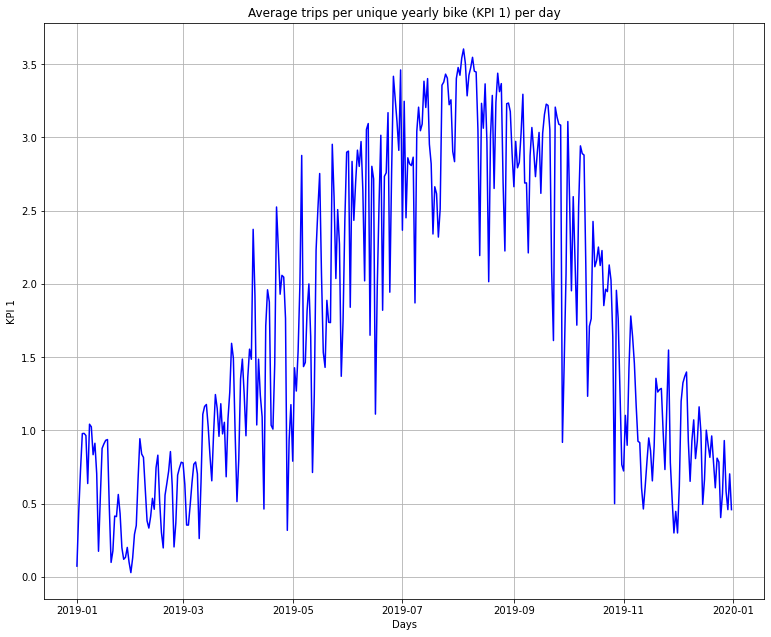

In [182]:
#Plot the kpi1 development per day over the year 2019
figure = plt.figure(figsize = (10, 8))
ax1 = figure.add_axes([0,0,1,1])
ax1.plot(kpi1["Day_Index"], kpi1["KPI"], color = "blue")
ax1.set_title("Average trips per unique yearly bike (KPI 1) per day")
ax1.set_ylabel("KPI 1")
ax1.set_xlabel("Days")
plt.grid(True)
plt.show()

<h3> Taking into account the weather - Boxplot </h3>
In the first boxplot, the data (KPI 1 with unique yearly bikes) is split in terms of whether the day was rainy and whether it was warm. It becomes clear that the variance of the KPI 1 on a rainday is significantly smaller than on a non-rainy day. This might be due to the fact that regardless of the temperature or other aspects that might influence usage, people will refrain from using the bike, leading to less fluctuation in terms of the KPI 1. As to expect, the KPI 1 is much higher on warm days. 


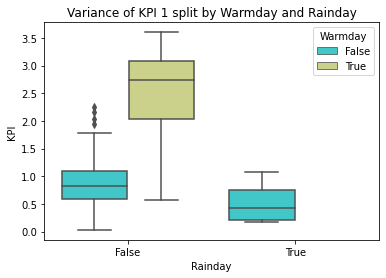

In [67]:
#Check the variance split by Warmday and Rainday
sns.boxplot(x="Rainday",y="KPI",data=kpi1,palette="rainbow", hue = "Warmday")
plt.title("Variance of KPI 1 split by Warmday and Rainday")
plt.show()

<h3> Taking into account the weather - Jointplot </h3>
A linear positive correlation between the average maximum daily temperature and the KPI 1 (thus, bike usage) can be exhibited. However, the histogram of KPI 1 values is comparably equally distributed, being slightly skewed towards low values. 


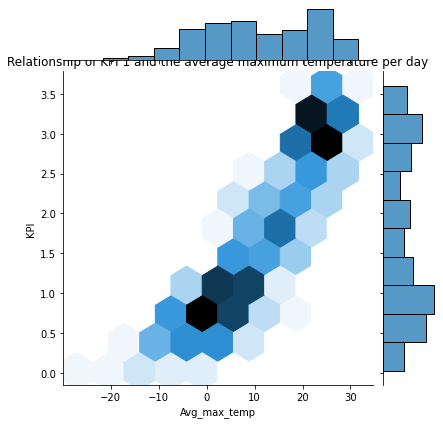

In [68]:
#Scrutinize the relationship between temperature and KPI1
sns.jointplot(x="Avg_max_temp",y="KPI",
            data=kpi1,kind="hex") 
plt.title("Relationship of KPI 1 and the average maximum temperature per day")
plt.show()

<h3> Plotting KPI 1 (Rides per Unique Bike) with Unique Daily Bikes </h3>

<h3> Plotting the yearly development - Unique daily bikes </h3>
Now, the same illustration as above was selected, however this time, the number of rides is divided by the number of unique bikes per day. Obviously, the same pattern as above can be observed. Interestingly, however, the KPI 1 now peaks at around 5, which perfectly lies within the target interval defined by Boor (2019). However, during most of the spring/autumn/winter months, the KPI 1 still lies below the lower intervall target of 4. Together with the KPI 1 measured by using the entire number of unique bikes over one year, a possible conclusion might be that the number of bikes is either too high or the bikes are inadequately stationed, resulting in a too low number of rides per bike. 


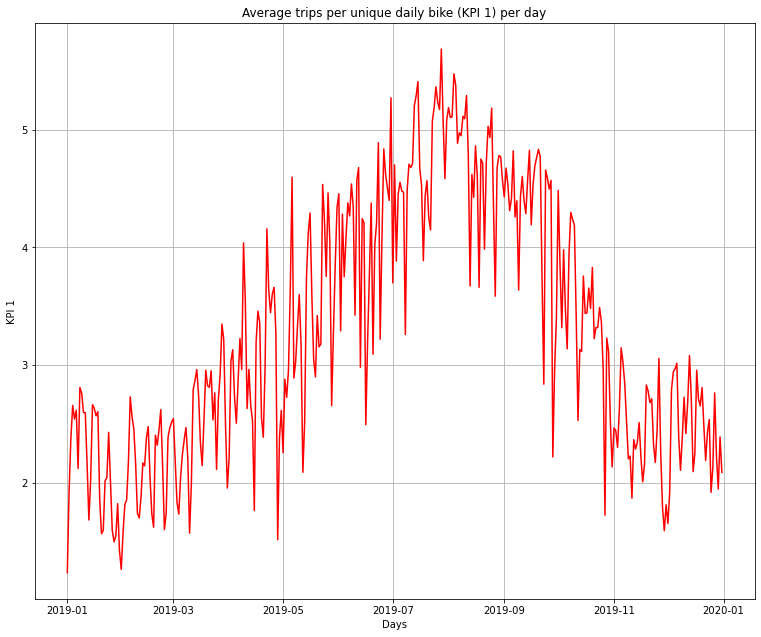

In [183]:
#Plot the kpi1_month development per day over the year 2019
figure = plt.figure(figsize = (10, 8))
ax1 = figure.add_axes([0,0,1,1])
ax1.plot(kpi1["Day_Index"], kpi1["KPI_daily"], color = "red")
ax1.set_title("Average trips per unique daily bike (KPI 1) per day")
ax1.set_ylabel("KPI 1")
ax1.set_xlabel("Days")
plt.grid(True)
plt.show()

<h3> Calculating KPI 1 with unique daily bikes - on an hourly basis </h3>
In this section, the exact calculation steps as above are conducted, however this time by grouping per hour in order to comply with the task. Bear in mind that this makes it difficult to interpret the absolute values of this representation and the ones discussed above. As the task explicitly states that the focus of the KPIs should be layed on the hourly values, more plots have been created exclusively for the hourly representation. 
Moreover, as the KPI 1 values above seemed to be more reasonable for the calculation using unique bikes per day, this KPI 1 will be used exclusively for the hourly representations. 


In [70]:
#Count the number of starting rides per day and hour
data_.groupby(["full_hour_start", "Start_day"]).count()

start_time  end_time  start_station_id  \
full_hour_start     Start_day                                            
2019-01-01 00:00:00 2019-01-01          23        23                23   
2019-01-01 01:00:00 2019-01-01          42        42                42   
2019-01-01 02:00:00 2019-01-01          41        41                41   
2019-01-01 03:00:00 2019-01-01          29        29                29   
2019-01-01 04:00:00 2019-01-01          14        14                14   
...                                    ...       ...               ...   
2019-12-31 08:00:00 2019-12-31         148       148               148   
2019-12-31 09:00:00 2019-12-31         152       152               152   
2019-12-31 10:00:00 2019-12-31          96        96                96   
2019-12-31 11:00:00 2019-12-31         102       102               102   
2019-12-31 12:00:00 2019-12-31          82        82                82   

                                end_station_id  start_station_name  \
full_hour_start     Start_day                                        
2019-01-01 00:00:00 2019-01-01              23                  23   
2019-01-01 01:00:00 2019-01-01              42                  42   
2019-01-01 02:00:00 2019-01-01              41                  41   
2019-01-01 03:00:00 2019-01-01              29                  29   
2019-01-01 04:00:00 2019-01-01              14                  14   
...                                        ...                 ...   
2019-12-31 08:00:00 2019-12-31             148                 148   
2019-12-31 09:00:00 2019-12-31             152                 152   
2019-12-31 10:00:00 2019-12-31              96                  96   
2019-12-31 11:00:00 2019-12-31             102                 102   
2019-12-31 12:00:00 2019-12-31              82                  82   

                                end_station_name  bike_id  user_type  \
full_hour_start     Start_day                                          
2019-01-01 00:00:00 2019-01-01                23       23         23   
2019-01-01 01:00:00 2019-01-01                42       42         42   
2019-01-01 02:00:00 2019-01-01                41       41         41   
2019-01-01 03:00:00 2019-01-01                29       29         29   
2019-01-01 04:00:00 2019-01-01                14       14         14   
...                                          ...      ...        ...   
2019-12-31 08:00:00 2019-12-31               148      148        148   
2019-12-31 09:00:00 2019-12-31               152      152        152   
2019-12-31 10:00:00 2019-12-31                96       96         96   
2019-12-31 11:00:00 2019-12-31               102      102        102   
2019-12-31 12:00:00 2019-12-31                82       82         82   

                                duration_time  duration_sec  duration_min  \
full_hour_start     Start_day                                               
2019-01-01 00:00:00 2019-01-01             23            23            23   
2019-01-01 01:00:00 2019-01-01             42            42            42   
2019-01-01 02:00:00 2019-01-01             41            41            41   
2019-01-01 03:00:00 2019-01-01             29            29            29   
2019-01-01 04:00:00 2019-01-01             14            14            14   
...                                       ...           ...           ...   
2019-12-31 08:00:00 2019-12-31            148           148           148   
2019-12-31 09:00:00 2019-12-31            152           152           152   
2019-12-31 10:00:00 2019-12-31             96            96            96   
2019-12-31 11:00:00 2019-12-31            102           102           102   
2019-12-31 12:00:00 2019-12-31             82            82            82   

                                duration_hour  weekday_start  full_hour_end  \
full_hour_start     Start_day                                                 
2019-01-01 00:00:00 2019-01-01             23             23 

In [71]:
#Now repeat the above steps to yield the hourly KPI1
usage_perhour = data_.groupby(["full_hour_start", "Start_day"]).count()
usage_perhour.reset_index(inplace = True)

usage_perhour = usage_perhour.merge(bike_perday, on = "Start_day")

rainhourgroup = data_.groupby("full_hour_start").mean()

rainhourgroup["Rainday"] = list(map(lambda x: True if x >= 0.5 else False, rainhourgroup["precip"]))
rainhourgroup["Warmday"] = list(map(lambda x: True if x >= 10 else False, rainhourgroup["max_temp"]))

rainhourgroup.reset_index(inplace = True)

rhg = rainhourgroup[["full_hour_start", "Rainday", "Warmday", "max_temp"]]

usage_perhour["Per_bike"] = usage_perhour["bike_id"]/6017
usage_perhour["Per_unique_daily_bike"] = usage_perhour["bike_id"]/usage_perhour["unique_bike_id"]

usage_perhour.head()

usage_perhour.reset_index(inplace = True)

usage_perhour_weather = pd.merge(usage_perhour, rhg, on='full_hour_start')

kpi1_h = usage_perhour_weather[["full_hour_start", "Per_bike", "Rainday", "Warmday", "max_temp_y", "Per_unique_daily_bike"]]

kpi1_h = kpi1_h.rename(columns = {"full_hour_start": "Hour_Index", "Per_bike": "KPI", "max_temp_y": "Avg_max_temp", "Rainday": "Rainhour", "Warmday": "Warmhour", "Per_unique_daily_bike": "KPI_unique"})

kpi1_h.head()

Hour_Index       KPI  Rainhour  Warmhour  Avg_max_temp  KPI_unique
0 2019-01-01 00:00:00  0.003823      True     False          1.10    0.064067
1 2019-01-01 01:00:00  0.006980     False     False          1.10    0.116992
2 2019-01-01 02:00:00  0.006814     False     False          1.10    0.114206
3 2019-01-01 03:00:00  0.004820     False     False          0.55    0.080780
4 2019-01-01 04:00:00  0.002327     False     False          0.00    0.038997

<h3> Taking into account the weather - Boxplot </h3>
Interestingly, compared to the same plot earlier, the differences between rainy and non rainy hours are significantly lower in this plot. This is most likely due to the fact that entire days being counted as "rainday" exhibited potentially much more rain over the day than just one rainy hour, which reduces the influence of the rain on bike utilization. 


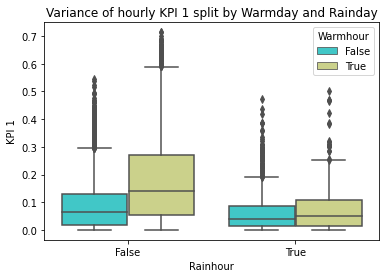

In [72]:
#Illustrate hourly variance
sns.boxplot(x="Rainhour",y="KPI_unique",data=kpi1_h,palette="rainbow", hue = "Warmhour")
plt.title("Variance of hourly KPI 1 split by Warmday and Rainday")
plt.ylabel("KPI 1")
plt.show()

<h3> Taking into account the weather - Jointplot </h3>
The jointplot again indicates a positive correlation between maximum hourly temperature and the KPI. 


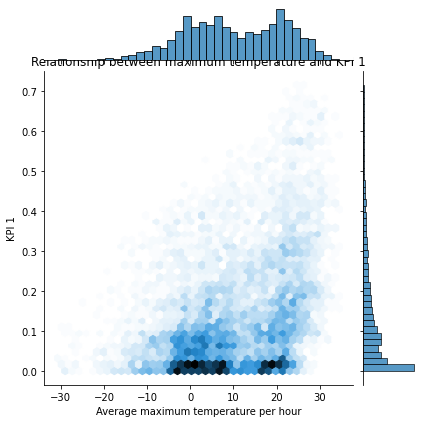

In [73]:
#Illustrate bivariate relationship for hourly values
sns.jointplot(x="Avg_max_temp",y="KPI_unique",
            data=kpi1_h,kind="hex", ) #kind: "scatter", "reg", "resid", "kde", "hex"
plt.ylabel("KPI 1")
plt.xlabel("Average maximum temperature per hour")
plt.title("Relationship between maximum temperature and KPI 1")
plt.show()

<h3> Preparation for more thorough investigations </h3>
Here, columns representing month, day and hour are added, to be able to scrutinize the data on those levels of aggregation. 


In [74]:
#Now, add the month and the weekday to be able to group the values accordingly
kpi1_h["Month"] = list(map(lambda x: x.month, kpi1_h["Hour_Index"]))
kpi1_h["Day"] = list(map(lambda x: x.weekday(), kpi1_h["Hour_Index"]))
kpi1_h["Hour"] = list(map(lambda x: x.hour, kpi1_h["Hour_Index"]))

In [75]:
#Now, create a multiindex grouped by Month and day and reset the index to be able to mask the data
kpi1_h_md = kpi1_h.groupby(["Month", "Day", "Hour"]).mean()
kpi1_h_md.reset_index(inplace = True)
kpi1_h_md.head()

Month  Day  Hour       KPI  Rainhour  Warmhour  Avg_max_temp  KPI_unique
0      1    0     0  0.001787      0.25       0.0     -6.650000    0.010111
1      1    0     1  0.000997      0.25       0.0     -6.400000    0.005897
2      1    0     2  0.000831      0.25       0.0     -6.100000    0.003665
3      1    0     3  0.000665      0.00       0.0     -4.433333    0.002595
4      1    0     4  0.001053      0.00       0.0     -4.416667    0.004869

<h3> Average hourly KPI 1 per month </h3>
In this plot, the hourly KPI 1 (based on daily unique bikes) was aggregated per month. Again, the seasonal pattern can be clearly obtained. During January, February, November and December, the values are equally low. From March to July and August, they take off, peaking in July at just below 0.2, meaning that on average in August, one bike performs 0.2 trips per hour. The value in December is slightly higher than in November, maybe due to Christmas holidays that offer certain activities, such as Christmas markets or generally visiting one's family, which might in part be conducted by bike. It is, however, difficult to assess this metric, as we do not have a reference value, like above. 


In [76]:
#To be able to investigate monthly averages, group by month
kpi1_h_permonth = kpi1_h_md.groupby("Month").mean()
kpi1_h_permonth.reset_index(inplace = True)

In [77]:
#Also, we want to take into account the weather data, so we group it by months and max temp
# Insert month and day helper coloumn
cwl["month"] = cwl["full_hour_start"].dt.month
cwl["day"] = cwl["full_hour_start"].dt.day

cwl_month = cwl.groupby("month").mean()
cwl_month.reset_index(inplace = True)
cwl_month.head()

month  start_station_id  end_station_id      bike_id  duration_sec  \
0      1        197.852260      197.299833  3400.637947    695.940869   
1      2        197.350430      197.977293  3464.760980    653.512854   
2      3        199.500229      200.536165  3426.014969    780.309600   
3      4        200.276700      201.245982  3416.881047   1001.661743   
4      5        200.692318      201.509084  3406.290071   1100.206943   

   duration_min  duration_hour  weekday_start   max_temp    precip       hour  \
0     11.599014       0.193317       0.913391  -1.500688  0.134320  13.591697   
1     10.891881       0.181531       0.923025  -2.118704  0.144349  13.715787   
2     13.005160       0.216753       0.885484   4.154640  0.051204  13.921323   
3     16.694362       0.278239       0.893362  13.042624  0.042507  14.160210   
4     18.336782       0.305613       0.882043  17.185964  0.029968  14.328465   

   interpol  Quarter  Total Docks  Docks in Service  Start_Latitude  \
0  0.141516      1.0    24.442643         24.442163       41.896820   
1  0.149623      1.0    24.359946         24.359599       41.895607   
2  0.072410      1.0    24.377457         24.375998       41.898402   
3  0.071538      2.0    24.669900         24.667504       41.898588   
4  0.116771      2.0    24.671530         24.667230       41.899363   

   Start_Longitude  End_Latitude  End_Longitude        day  
0       -87.643457     41.896991     -87.643648  12.118400  
1       -87.643347     41.895824     -87.643683  14.866526  
2       -87.643973     41.898985     -87.644337  17.754804  
3       -87.642975     41.899464     -87.643390  15.496720  
4       -87.642636     41.900207     -87.643043  17.210714

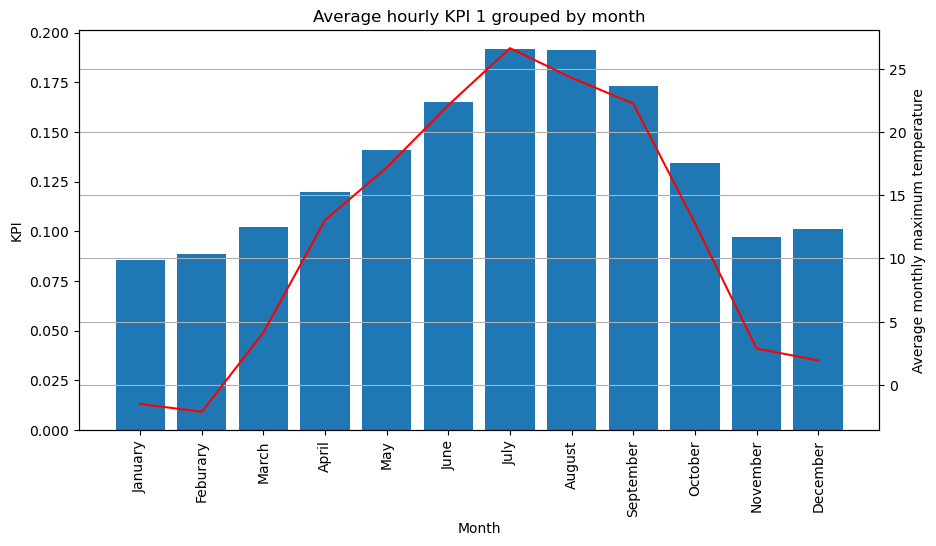

In [78]:
#Now, plot the months against the KPI1 values averaged by month, together with the temperature data
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_axes([0,0,1,1])

ax.bar(kpi1_h_permonth["Month"], kpi1_h_permonth["KPI_unique"])

plt.sca(ax)
plt.xticks(np.arange(1,13), ["January", "Feburary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], fontsize=10, rotation=90)

ax2 = ax.twinx()            
ax2.plot(cwl_month["month"],cwl_month["max_temp"],color="red" )

ax.set_title("Average hourly KPI 1 grouped by month")
ax.set_xlabel("Month")
ax.set_ylabel("KPI")
ax2.set_ylabel("Average monthly maximum temperature")

plt.grid(True)
plt.show()

<h3> Average KPI 1 per hour </h3>
In the subsequent plot, the KPI 1 with daily unqiue bikes is aggregated per hour over the entire year. It can be clearly seen that between 0 and 5 o' clock, the usage is very low, because the majority of people is sleeping. At around 6, the figure rises, most likely due to beginning commuting activity. The KPI 1 reaches a first peak at around 9, where most likely commuter traffic also peaks. Throughout the noon hours, the KPI 1 declines again - probably, because most of the people do not leave their workplace that early. The figure again peaks at around 17 o'clock, when the commuting activity is the highest. Interestingly, at 5 o'clock, the KPI 1 stands at around 0.4, which is more than twice as high than the average monthly value in July, the most "active" month. A bike at that time performs around 0.4 rides per hour. Thus, commuting activity has a tremendous impact on the utilization of the divyy system, much more than monthly seasonality. 


In [79]:
#To be able to investigate hourly averages, group by hour
kpi1_h_perhour = kpi1_h_md.groupby("Hour").mean()
kpi1_h_perhour.reset_index(inplace = True)

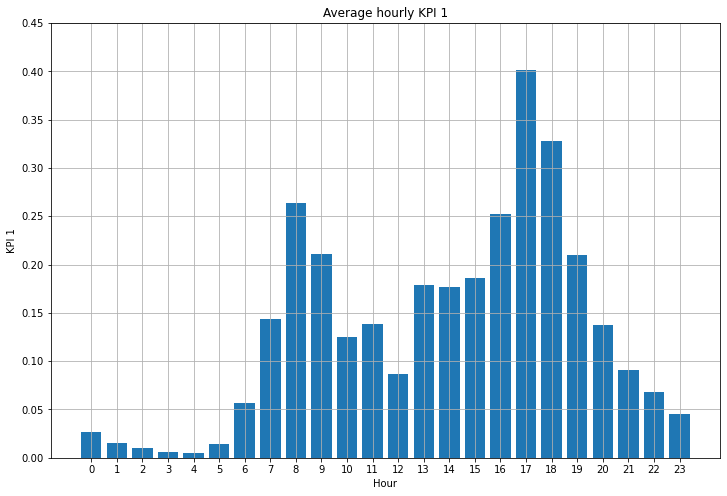

In [80]:
#Now, plot the months against the KPI1 values averaged by hour
fig1 = plt.figure(figsize = (12,8))
plt.bar(kpi1_h_perhour["Hour"], kpi1_h_perhour["KPI_unique"])
plt.title("Average hourly KPI 1")
plt.xlabel("Hour")
plt.ylabel("KPI 1")
plt.xticks(np.arange(0,24), fontsize=10)
plt.yticks(np.arange(0,0.5,0.05))

plt.grid(True)
plt.show()

In [81]:
kpi1_h.head()

Hour_Index       KPI  Rainhour  Warmhour  Avg_max_temp  KPI_unique  \
0 2019-01-01 00:00:00  0.003823      True     False          1.10    0.064067   
1 2019-01-01 01:00:00  0.006980     False     False          1.10    0.116992   
2 2019-01-01 02:00:00  0.006814     False     False          1.10    0.114206   
3 2019-01-01 03:00:00  0.004820     False     False          0.55    0.080780   
4 2019-01-01 04:00:00  0.002327     False     False          0.00    0.038997   

   Month  Day  Hour  
0      1    1     0  
1      1    1     1  
2      1    1     2  
3      1    1     3  
4      1    1     4

<h3> Average KPI 1 per hour - comparing Winter and Summer </h3>
As it would be impractical to calculate the above representation for each month respectively, it was decided to choose "representation" months, that represent the winter (December, January, February) and the Summer (June, July, August). 
In the graph, blue bars represent the summer values and the orange ones the winter values. The patterns (mainly due to commuter traffic) are very similar in both times of the year, however, as to expect, the hourly values are much higher. Interestingly, while during winter, the decline of the bar during noon is significant, it is much less present in the figure for summer. This can me most likely attributed to the fact that during the warm summer months, more people use their bike to perform leisure activities or shop for groceries, whilst during winter, if a bike is used, it is used for necessary transport, i.e., getting to work. The highest difference between summer and winter is exhibited at 17 o'clock. Again, this might be due to the fact that in summer, people use the bikes not only to get home from work, but also to shop for groceries, exercise etc. 


In [82]:
#We now want to compute a similar representation, however now split into three months respresenting the summer and three months representing the winter
kpi1_h_winter = kpi1_h[(kpi1_h["Month"] == 12) | (kpi1_h["Month"] == 1) | (kpi1_h["Month"] == 2)]
kpi1_h_summer = kpi1_h[(kpi1_h["Month"] == 6) | (kpi1_h["Month"] == 7) | (kpi1_h["Month"] == 8)]

In [83]:
#Now, we group the average KPI per Hour
kpi1_h_summer_g = kpi1_h_summer.groupby("Hour").mean()
kpi1_h_winter_g = kpi1_h_winter.groupby("Hour").mean()

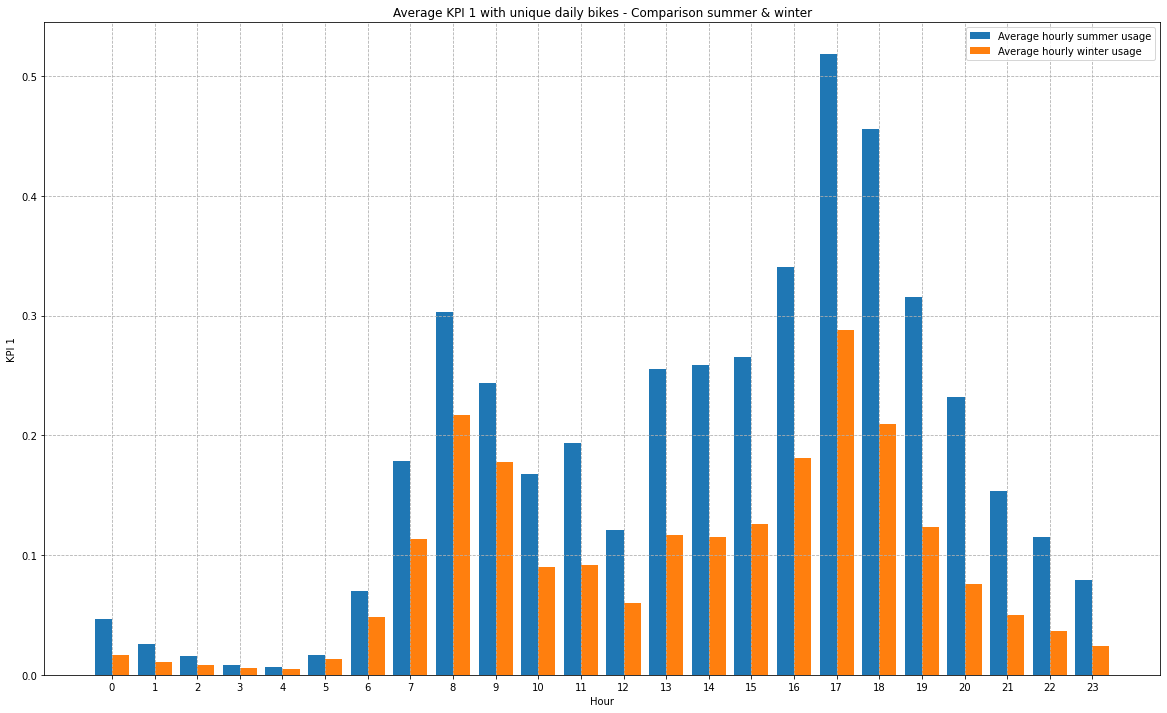

In [84]:
#Plot the aforementioned data sets
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots()

ax1.bar(x+width/2, kpi1_h_summer_g["KPI_unique"], width, label='Average hourly summer usage',align="center")

ax1.bar(x+3*width/2, kpi1_h_winter_g["KPI_unique"], width, label='Average hourly winter usage',align="center")



fig.set_figwidth(20)
fig.set_figheight(12)
plt.xlabel("Hour")
plt.ylabel("KPI 1")
plt.title("Average KPI 1 with unique daily bikes - Comparison summer & winter")
plt.grid(linestyle='--')
plt.xticks(x + width,x)
plt.legend()
        
plt.show()

<h3> Average KPI 1 per hour - comparing Weekend and Weekdays </h3>
Now, a similar figure as above is developed, however this time comparing weekend and weekday values. 
It is clear that while the weekday values exhibit the aforementioned "commuter pattern", the weekend values peek around noon, because most of the people will be exercising, riding for fun etc. during that time. Generally, the weekend KPI values are not higher or lower than the weekday ones, except for the situation during noon and at around 9/17 o' clock. Thus, it can again be reasoned that commuting is a significant driver of the divyy bike system. 


In [85]:
#We now want to compute a comparison of the KPI putting weekend and weekdays in juxtaposition
kpi1_h_weekend = kpi1_h[(kpi1_h["Day"] == 5) | (kpi1_h["Day"] == 6)]
kpi1_h_weekday = kpi1_h[(kpi1_h["Day"] == 0) | (kpi1_h["Day"] == 1) | (kpi1_h["Day"] == 2) | (kpi1_h["Day"] == 3) | (kpi1_h["Day"] == 4) | (kpi1_h["Day"] == 5)]

In [86]:
#Now, we group the average KPI per Hour
kpi1_h_weekend_g = kpi1_h_weekend.groupby("Hour").mean()
kpi1_h_weekday_g = kpi1_h_weekday.groupby("Hour").mean()

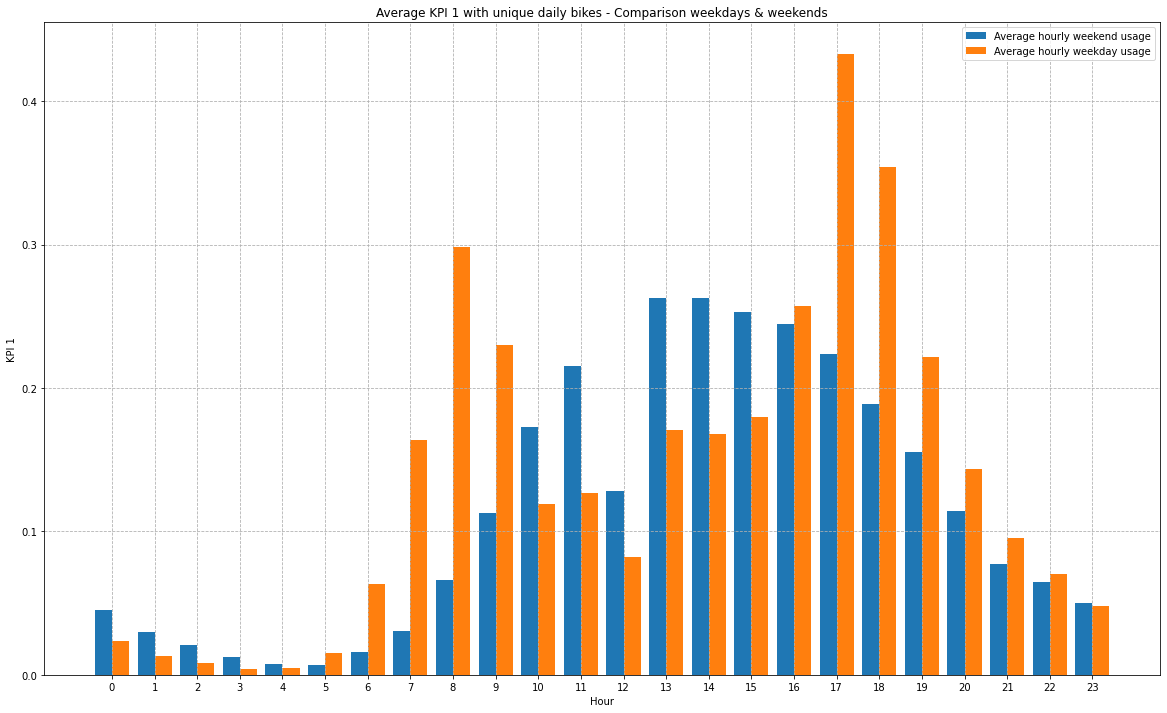

In [87]:
#Plot the data sets
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots()

ax1.bar(x+width/2, kpi1_h_weekend_g["KPI_unique"], width, label='Average hourly weekend usage',align="center")

ax1.bar(x+3*width/2, kpi1_h_weekday_g["KPI_unique"], width, label='Average hourly weekday usage',align="center")



fig.set_figwidth(20)
fig.set_figheight(12)
plt.xlabel("Hour")
plt.ylabel("KPI 1")
plt.title("Average KPI 1 with unique daily bikes - Comparison weekdays & weekends")
plt.grid(linestyle='--')
plt.xticks(x + width,x)
plt.legend()
        
plt.show()

<h2> 2.3.4 KPI 2 - Demand-Capacity: Implementation of the Concept of Coverage </h2>
The task requires to implement a KPI related to "coverage". We interpret this in a way that the KPI should investigate, whether the distribution and the number of stations is sufficient.
Thus, a second KPI (KPI 2) will be developed, based not only on the number of rides in a certain time period, but also based on the capacity of the respective stations. Therefore, the dataset containing station data is also taken into account. The goal here is to scrutinize, which stations are equipped with insufficient capacities, where they are stationed and to what degree the capacity is being exceeded. This is our concrete definition/implementation of the concept "coverage".
This is done in two steps. Firstly, the data that unites bike data, weather data and station data is split and grouped by start hour, start station and start hour, end station, respectively, counting the number of trips. Secondly, both dataframes are merged on their index, that is on the start hour end the station id. By that, we yield those trips that started and ended at one station in the same hour. Therefore, the "counted" number as a result of the groupby-operation now describes, how many rides started and ended per hour per station. 
As the KPI 2 combines capacity and demand, we will also call it Demand-Capacity.


In [88]:
#Read in location data
cwl = pd.read_csv("./../data/bike_weather_location_clean.csv", parse_dates=["start_time", "end_time", "full_hour_start", "full_hour_end"])

In [89]:
cwl.head()

start_time            end_time  start_station_id  end_station_id  \
0 2019-01-01 00:04:37 2019-01-01 00:11:07               199              84   
1 2019-01-01 17:11:21 2019-01-01 18:18:35               199              84   
2 2019-01-03 15:55:41 2019-01-03 16:04:47               199              84   
3 2019-01-03 16:20:43 2019-01-03 16:29:15               199              84   
4 2019-01-04 06:27:21 2019-01-04 06:36:31               199              84   

       start_station_name           end_station_name  bike_id   user_type  \
0  Wabash Ave & Grand Ave  Milwaukee Ave & Grand Ave     2167  Subscriber   
1  Wabash Ave & Grand Ave  Milwaukee Ave & Grand Ave     3335  Subscriber   
2  Wabash Ave & Grand Ave  Milwaukee Ave & Grand Ave     1156  Subscriber   
3  Wabash Ave & Grand Ave  Milwaukee Ave & Grand Ave     6110  Subscriber   
4  Wabash Ave & Grand Ave  Milwaukee Ave & Grand Ave     1013  Subscriber   

     duration_time  duration_sec  ...  Quarter            Station Name  \
0  0 days 00:06:30         390.0  ...        1  Wabash Ave & Grand Ave   
1  0 days 01:07:14        4034.0  ...        1  Wabash Ave & Grand Ave   
2  0 days 00:09:06         546.0  ...        1  Wabash Ave & Grand Ave   
3  0 days 00:08:32         512.0  ...        1  Wabash Ave & Grand Ave   
4  0 days 00:09:10         550.0  ...        1  Wabash Ave & Grand Ave   

   Total Docks Docks in Service      Status  Start_Latitude  Start_Longitude  \
0           31               31  In Service       41.891466       -87.626761   
1           31               31  In Service       41.891466       -87.626761   
2           31               31  In Service       41.891466       -87.626761   
3           31               31  In Service       41.891466       -87.626761   
4           31               31  In Service       41.891466       -87.626761   

                  Location  End_Latitude  End_Longitude  
0  (41.891466, -87.626761)     41.891578     -87.648384  
1  (41.891466, -87.626761)     41.891578     -87.648384  
2  (41.891466, -87.626761)     41.891578     -87.648384  
3  (41.891466, -87.626761)     41.891578     -87.648384  
4  (41.891466, -87.626761)     41.891578     -87.648384  

[5 rows x 29 columns]

In [90]:
#No, we group the data by starting hour and the respective stations that were the starting point for each usage
cwl_s = cwl.groupby(["full_hour_start", "start_station_id"]).count()
#Do the same for the usages that ended in the respective hour
cwl_e = cwl.groupby(["full_hour_start", "end_station_id"]).count()

In [91]:
#As we just want the count-data, it is sufficient to select a random column, in this case Docks in Service (could've taken any other column)
#ATTENTION: Although the columns only indicate the day, the split is based upon hours - this is a display error
cwl_start = cwl_s[["Docks in Service"]]
cwl_end = cwl_e[["Docks in Service"]]

cwl_start.head()

Docks in Service
full_hour_start start_station_id                  
2019-01-01      15                               1
                35                               3
                44                               1
                47                               1
                85                               1

In [92]:
#To be able to merge both tables, we rename the index of the end-Table
cwl_end.rename_axis(["full_hour_start", "start_station_id"], inplace = True)

In [93]:
#No, we merge both tables based on the Multi-Index
kpi2_ = pd.merge(cwl_start, cwl_end, left_index=True, right_index=True)
kpi2_.head()

Docks in Service_x  Docks in Service_y
full_hour_start     start_station_id                                        
2019-01-01 00:00:00 35                                 3                   2
2019-01-01 01:00:00 66                                 1                   1
                    240                                2                   1
                    313                                1                   2
                    520                                1                   1

In [94]:
#We reset the index and rename the columns
kpi2_.reset_index(inplace = True)
kpi2_.rename(columns = {"start_station_id": "Station_id", "full_hour_start": "Hour", "Docks in Service_x": "Incoming", "Docks in Service_y": "Outgoing"}, inplace = True)

In [95]:
kpi2_.head()

Hour  Station_id  Incoming  Outgoing
0 2019-01-01 00:00:00          35         3         2
1 2019-01-01 01:00:00          66         1         1
2 2019-01-01 01:00:00         240         2         1
3 2019-01-01 01:00:00         313         1         2
4 2019-01-01 01:00:00         520         1         1

<h3> KPI 2 - Combining capacity and activity </h3>
Now, the location data is merged with the above described "activity" data (Trips starting and ending at the same station for each hour) to yield the capacity of each station, to be able to calculate the KPI eventually. 


In [96]:
#We also read in the pure location data to have a clean source
locations = pd.read_csv("../data/Divvy_Bicycle_Stations-2.csv")

In [97]:
#Now, we want to know the capacity of each station and thus refer to our location data
capacity = locations[["ID", "Docks in Service"]]

capacity.rename(columns = {"ID": "Station_id"}, inplace = True)


/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [98]:
#Now we merge the capacity data on our incoming/outgoing data
kpi2 = pd.merge(kpi2_, capacity, on = "Station_id")
kpi2.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service
0 2019-01-01 00:00:00          35         3         2                47
1 2019-01-01 19:00:00          35         2         6                47
2 2019-01-02 17:00:00          35         2         2                47
3 2019-01-02 21:00:00          35         1         1                47
4 2019-01-03 13:00:00          35         2         7                47

<h3> Final Calculation of KPI 2 (Demand-Capacity) </h3>
Now, the KPI 2 can be calculated by dividing the number of starting and ending trips per hour through the capacity (number of docks) of the respective station. There are two versions, how this calculation could be implemented. Firstly, one could calculate the absolute difference between rides starting and ending in each station and divide this value by the station's capacity. However, imagine a station where in one hour, 20 bikes arrive and 20 bikes leave. The KPI would then yield 0, although the station might have experienced a problematic capacity load throughout that hour. Thus, a different version of the KPI is developed, measuring the maximum of both the number of arriving and departing rides per station. Therefore, in the above mentioned example, the KPI would yield 20 over the capacity of the station, which would represent the situation more realistically. This KPI-version is stored in the column "Demand_Capacity".
Additionally, a category is developed. Category 0 is assigned if the KPI 2 value lies between 0 and 0.25, 1 is assigned if the values is between 0.25 and 0.75 and 2 is assigned if the value lies above 0.75. 


In [99]:
#If in one hour 20 bikes would arrive at a station and 20 would leave, the KPI would indicate,
#that the utilization fpr this station in the respective hour would be 0.
#Thus, another measure needs to be taken that counts the maximum of arriving/leaving bikes
kpi2["maximum"] = list(map(lambda x,y: max(x,y), kpi2["Outgoing"], kpi2["Incoming"]))

In [100]:
#Relate the max to the capacity of the station
kpi2["Demand_Capacity"] = kpi2["maximum"]/kpi2["Docks in Service"]

In [101]:
kpi2.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service  \
0 2019-01-01 00:00:00          35         3         2                47   
1 2019-01-01 19:00:00          35         2         6                47   
2 2019-01-02 17:00:00          35         2         2                47   
3 2019-01-02 21:00:00          35         1         1                47   
4 2019-01-03 13:00:00          35         2         7                47   

   maximum  Demand_Capacity  
0        3         0.063830  
1        6         0.127660  
2        2         0.042553  
3        1         0.021277  
4        7         0.148936

In [102]:
#Export KPI 2 as csv to be able to import it later on in the clustering part
kpi2.to_csv("../data/kpi2.csv")

<h2> 2.3.5 Investigation of KPI 2 (Demand-Capacity) </h2>


<h3> KPI 2 Category Countplot </h3>
Having a look at the plots counting the number of occurrences of each category for KPI 2, it becomes clear that the vast majority of the hours lies within category 0 and 1, thus, the vast majority of stations most of the time does not exhibit capacity overload. However, especially looking at the Demand_Capacity version, there are hours that exhibit problematic capacity utilization. Those will be investigated more thoroughly later.

In [103]:
#Now, we categorize the values accoridng to the percentage of the max capacity

kpi2["Demand_cat"] = list(map(lambda x: 0 if x < 0.25 else 1 if 0.25 <= x < 0.75 else 2 if x >= 0.75 else -1, kpi2["Demand_Capacity"]))

In [104]:
kpi2.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service  \
0 2019-01-01 00:00:00          35         3         2                47   
1 2019-01-01 19:00:00          35         2         6                47   
2 2019-01-02 17:00:00          35         2         2                47   
3 2019-01-02 21:00:00          35         1         1                47   
4 2019-01-03 13:00:00          35         2         7                47   

   maximum  Demand_Capacity  Demand_cat  
0        3         0.063830           0  
1        6         0.127660           0  
2        2         0.042553           0  
3        1         0.021277           0  
4        7         0.148936           0

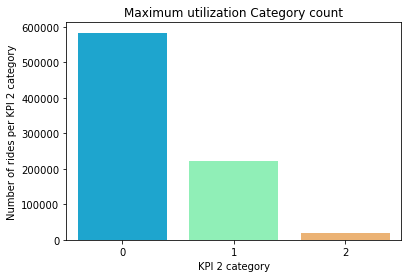

In [105]:
#Count the number of usages in each utilization_max category
sns.countplot(x="Demand_cat",data=kpi2,palette="rainbow")
plt.title("Maximum utilization Category count")
plt.xlabel("KPI 2 category")
plt.ylabel("Number of rides per KPI 2 category")
plt.show()

<h3> Preparation to plot KPI 2 per hour per month </h3>
As with the first KPI, the second, capacity-related KPI 2, will also be depicted on a monthly basis. Therefore, the month, day and hour columns are added. 


In [106]:
#Now, we add the hour, month and the day in order to be able to group the data accordingly
kpi2["Day"] = list(map(lambda x: x.weekday(), kpi2["Hour"]))
kpi2["Month"] = list(map(lambda x: x.month, kpi2["Hour"]))
kpi2["Hour_num"] = list(map(lambda x: x.hour, kpi2["Hour"]))
kpi2.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service  \
0 2019-01-01 00:00:00          35         3         2                47   
1 2019-01-01 19:00:00          35         2         6                47   
2 2019-01-02 17:00:00          35         2         2                47   
3 2019-01-02 21:00:00          35         1         1                47   
4 2019-01-03 13:00:00          35         2         7                47   

   maximum  Demand_Capacity  Demand_cat  Day  Month  Hour_num  
0        3         0.063830           0    1      1         0  
1        6         0.127660           0    1      1        19  
2        2         0.042553           0    2      1        17  
3        1         0.021277           0    2      1        21  
4        7         0.148936           0    3      1        13

In [107]:
#To be able to plot the data by monthly average values, we group by month
kpi2_month = kpi2.groupby("Month").mean()
kpi2_month.reset_index(inplace = True)
kpi2_month.head()

Month  Station_id  Incoming  Outgoing  Docks in Service   maximum  \
0      1  194.479359  2.375913  2.391593         23.613330  3.151397   
1      2  190.851751  2.257324  2.239082         23.705141  2.950149   
2      3  200.784083  2.523944  2.519110         23.104136  3.337175   
3      4  211.978466  3.201296  3.219501         22.525529  4.253687   
4      5  216.152879  3.552117  3.565857         22.229819  4.694562   

   Demand_Capacity  Demand_cat       Day   Hour_num  
0         0.134157    0.125476  2.738211  13.889568  
1         0.124520    0.101887  2.525409  14.006515  
2         0.145203    0.149549  2.891053  14.195842  
3         0.187714    0.252826  2.609702  14.414025  
4         0.209887    0.311716  2.982868  14.491261

<h3> Plot of KPI 2 per hour per month </h3> 
The same seasonality of the KPI 2 can be contemplated as with the first KPI 1, since both KPIs heavily rely on the number of rides. It is important to notice, that even in the most "active" month, August, the KPI 2 never exceeds 0.3. Thus, the capacity of the system is generally very well balanced over the year. Again, a clear correlation with the temperature can be exhibited.


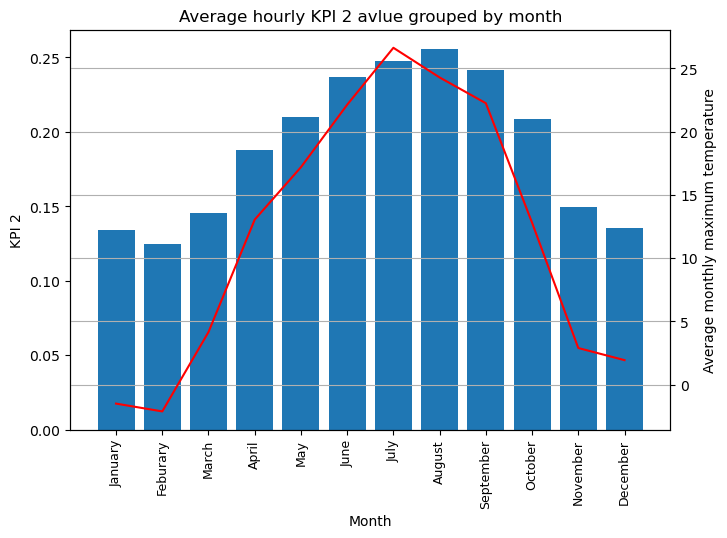

In [108]:
#Now, we plot the average hourly KPI (max) per month, together with the temperature data
fig = plt.figure(figsize=(6,4),dpi = 100)
ax = fig.add_axes([0,0,1,1])

ax.bar(kpi2_month["Month"], kpi2_month["Demand_Capacity"])

plt.sca(ax)
plt.xticks(np.arange(1,13), ["January", "Feburary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], fontsize = 9, rotation=90)

ax2 = ax.twinx()            
ax2.plot(cwl_month["month"],cwl_month["max_temp"],color="red" )

ax.set_title("Average hourly KPI 2 avlue grouped by month")
ax.set_xlabel("Month")
ax.set_ylabel("KPI 2")
ax2.set_ylabel("Average monthly maximum temperature")

plt.grid(True)
plt.show()

<h3> Plot of KPI 2 averaged per hour </h3>
Plotting the KPI 2 (Demand-Capacity) grouped by hour over the year 2019, we can again exhibit the above introduced "commuter pattern". Again, 17 o'clock stands out significantly, exceeding an average value of 0.3. This means, that on average, during 17 o'clock, 30% of all station's capacity is used. Keep in mind, however, that there might be significant differences between each station and that this metric only measures the performance of the entire system. 
It is important to notice that we measure the KPI 2 based on the number of conducted trips. Usually, the utilization of the stations is maximized when the least trips are conducted, which would normally be the case during the night. However, with KPI 2, we measure the activity of starting/ending trips per station, which reaches a low point during night. 


In [109]:
#In order to calculate hourly values, we group by hour
kpi2_hour = kpi2.groupby("Hour_num").mean()
kpi2_hour.reset_index(inplace = True)

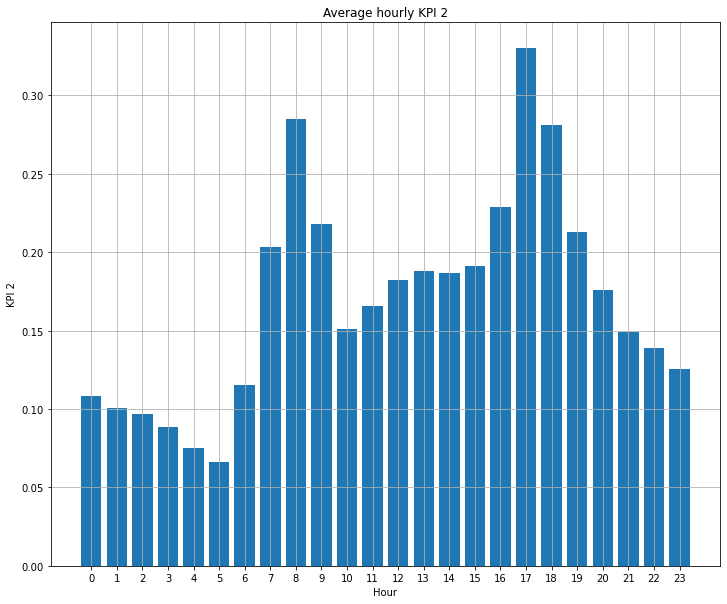

In [110]:
#Now, we plot the average hourly KPI (max) over the year
fig1 = plt.figure(figsize = (12,10))
plt.bar(kpi2_hour["Hour_num"], kpi2_hour["Demand_Capacity"])
plt.title("Average hourly KPI 2")
plt.xlabel("Hour")
plt.ylabel("KPI 2")
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(0,0.35,0.05))

plt.grid(True)
plt.show()

<h3> Average KPI 2 per hour - comparing Winter and Summer </h3>
In the following section, the same representations are developed for KPI 2 as for the first one. Blue bars represent the three summer months, orange bars represent the three winter months. While the same patterns as for the first KPI can be explored, it is of particular interest that the maximum value is again found to be during summer at 17 pm, with nearly 0.4. That means that during this time, nearly half of the capacity of all stations (regardless of wether they are in the center or not) is made use of. 


In [111]:
#We now want to compute a similar representation, however now split into three months respresenting the summer and three months representing the winter
kpi2_h_winter = kpi2[(kpi2["Month"] == 12) | (kpi2["Month"] == 1) | (kpi2["Month"] == 2)]
kpi2_h_summer = kpi2[(kpi2["Month"] == 6) | (kpi2["Month"] == 7) | (kpi2["Month"] == 8)]


In [112]:
#Now, we group the average KPI per Hour
kpi2_h_summer_g = kpi2_h_summer.groupby("Hour_num").mean()
kpi2_h_winter_g = kpi2_h_winter.groupby("Hour_num").mean()

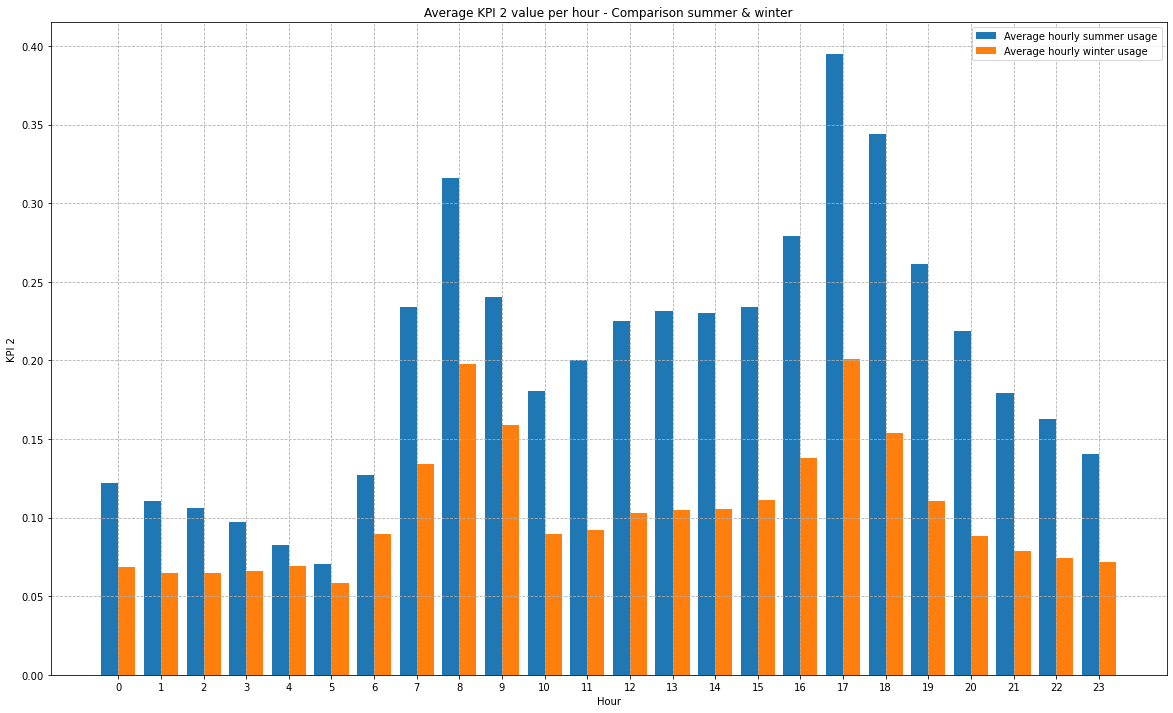

In [113]:
#Plot the four aforementioned data sets
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots()

ax1.bar(x+width/2, kpi2_h_summer_g["Demand_Capacity"], width, label='Average hourly summer usage',align="center")

ax1.bar(x+3*width/2, kpi2_h_winter_g["Demand_Capacity"], width, label='Average hourly winter usage',align="center")



fig.set_figwidth(20)
fig.set_figheight(12)
plt.xlabel("Hour")
plt.ylabel("KPI 2")
plt.title("Average KPI 2 value per hour - Comparison summer & winter")
plt.grid(linestyle='--')
plt.xticks(x + width,x)
plt.legend()
        
plt.show()

<h3> Average KPI 2 per hour - Comparing weekdays and weekends </h3>
The same patterns can be observed as compared to KPI 1. Again, the drop of the figure after the morning commuting time, during noon, is only exhibited during weekdays. Interestingly, the values peak at 5 pm at just below 0.35, whilst the maximum was around 04 during summer. Thus, the season has a higher influence on the KPI 2 than time alone. 


In [114]:
#We now want to compute a comparison of the KPI putting weekend and weekdays in juxtaposition
kpi2_h_weekend = kpi2[(kpi2["Day"] == 5) | (kpi2["Day"] == 6)]
kpi2_h_weekday = kpi2[(kpi2["Day"] == 0) | (kpi2["Day"] == 1) | (kpi2["Day"] == 2) | (kpi2["Day"] == 3) | (kpi2["Day"] == 4) | (kpi2["Day"] == 5)]




In [115]:
#Now, we group the average KPI per Hour
kpi2_h_weekend_g = kpi2_h_weekend.groupby("Hour_num").mean()
kpi2_h_weekday_g = kpi2_h_weekday.groupby("Hour_num").mean()

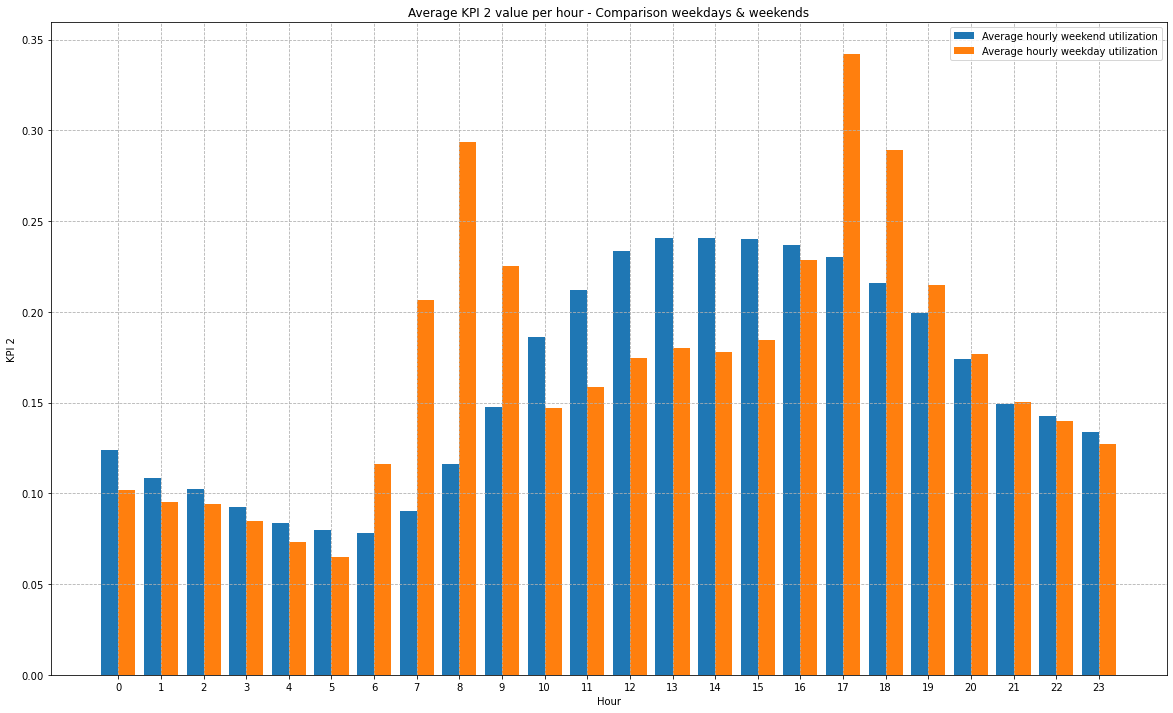

In [116]:
#Plot the data sets
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots()

ax1.bar(x+width/2, kpi2_h_weekend_g["Demand_Capacity"], width, label='Average hourly weekend utilization',align="center")

ax1.bar(x+3*width/2, kpi2_h_weekday_g["Demand_Capacity"], width, label='Average hourly weekday utilization',align="center")



fig.set_figwidth(20)
fig.set_figheight(12)
plt.xlabel("Hour")
plt.ylabel("KPI 2")
plt.title("Average KPI 2 value per hour - Comparison weekdays & weekends")
plt.grid(linestyle='--')
plt.xticks(x + width,x)
plt.legend()
        
plt.show()

<h2> 2.3.6 Scrutinizing "Problematic" Stations in terms of High Values of KPI 2 </h2>
In order to investigate stations that exhibit problematic behavior in terms of the KPI 2, it was decided to extract those stations, that at one point (i.e., hour) in time exhibited a KPI 2 value  greater or equal than one, i.e., Demand-Capacity >=1. Those stations are considered "problematic" or "dangerous", as their capacity is exceeded in our way of measurement in terms of demand. 
However, it can be seen that many of the yielded 150 stations only rarely exhibit such high KPI 2 values. In order to obtain a clear picture, we limit the data frame to the 20 most "problematic" Stations, that is, the stations that exceeded a KPI 2 value of 1 most often.
We aggregate the KPI 2 values for those 20 stations on a daily level to be able to scatter them properly. Additionally, the standard deviation of each daily KPI 2 was calculated. 


In [117]:
#We now want to investigate Stations that exhibit utilizations that are above or equal to 1, thus, that could
#potentially need an amplification in terms of capacity
kpi2_prob = kpi2[kpi2["Demand_Capacity"] >= 1]

In [118]:
#There are 150 unique stations that fullfill this requirement
len(kpi2_prob["Station_id"].unique())

150

In [119]:
#We call those stations dangerous, as their capacity might be too low
#We group them by Station id to investigate on station level and count, how many trips have been made from/to
#those stations that fullfill the criteria described above
#We then select the 20 most "problematic" stations as they exhibit the highest number of problematic capacity occasions
kpi2_dangerous_ = kpi2_prob.groupby("Station_id").count().sort_values("Hour", ascending = False)[:20]
kpi2_dangerous_.reset_index(inplace = True)

In [120]:
#We now merge those 20 stations with our originial KPI data to yield the kpi values only for those 20 stations
kpi2_dangerous_id = kpi2_dangerous_["Station_id"]
kpi2_dangerous = kpi2.merge(kpi2_dangerous_id, on ="Station_id")
kpi2_dangerous.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service  \
0 2019-01-01 00:00:00          35         3         2                47   
1 2019-01-01 19:00:00          35         2         6                47   
2 2019-01-02 17:00:00          35         2         2                47   
3 2019-01-02 21:00:00          35         1         1                47   
4 2019-01-03 13:00:00          35         2         7                47   

   maximum  Demand_Capacity  Demand_cat  Day  Month  Hour_num  
0        3         0.063830           0    1      1         0  
1        6         0.127660           0    1      1        19  
2        2         0.042553           0    2      1        17  
3        1         0.021277           0    2      1        21  
4        7         0.148936           0    3      1        13

In [121]:
#We now want to inivestigate the KPI based on daily (not weekday) values, so we round the time to days in a new column
kpi2_dangerous["Day_round"] = list(map(lambda x: x.round("D"), kpi2_dangerous["Hour"]))

In [122]:
#Now,we group the problematic station KPIs per day and calculate mean and standard deviation
kpi2_dangerous_day = kpi2_dangerous.groupby("Day_round").mean()
kpi2_dangerous_day_std = kpi2_dangerous.groupby("Day_round").std()
kpi2_dangerous_day.reset_index(inplace = True)
kpi2_dangerous_day_std.reset_index(inplace = True)

In [123]:
#Now, we rename the columns to be able to merge properly
kpi2_dangerous_day_std = kpi2_dangerous_day_std[["Day_round", "Demand_Capacity"]]
kpi2_dangerous_day_std.rename(columns = {"Demand_Capacity": "Demand_Capacity_std"}, inplace = True)

In [124]:
kpi2_dangerous_day.head()

Day_round  Station_id  Incoming  Outgoing  Docks in Service   maximum  \
0 2019-01-01   95.800000  1.600000  1.200000         29.400000  1.600000   
1 2019-01-02  137.230769  3.846154  4.397436         27.769231  5.858974   
2 2019-01-03  126.323308  4.631579  4.586466         28.293233  6.488722   
3 2019-01-04  123.178771  4.837989  4.810056         29.100559  6.608939   
4 2019-01-05  126.354839  4.793548  4.458065         28.883871  6.361290   

   Demand_Capacity  Demand_cat       Day  Month   Hour_num  
0         0.061032    0.000000  1.000000    1.0   5.800000  
1         0.216056    0.333333  1.833333    1.0  10.141026  
2         0.235533    0.390977  2.428571    1.0  13.045113  
3         0.238801    0.357542  3.402235    1.0  13.251397  
4         0.231527    0.387097  4.219355    1.0  14.535484

In [125]:
#We merge the data frames to yield mean and standard deviation values in one frame
kpi2_dangerous_day_mean_std = kpi2_dangerous_day.merge(kpi2_dangerous_day_std, on = "Day_round")

In [126]:
kpi2_dangerous_day_mean_std.head()

Day_round  Station_id  Incoming  Outgoing  Docks in Service   maximum  \
0 2019-01-01   95.800000  1.600000  1.200000         29.400000  1.600000   
1 2019-01-02  137.230769  3.846154  4.397436         27.769231  5.858974   
2 2019-01-03  126.323308  4.631579  4.586466         28.293233  6.488722   
3 2019-01-04  123.178771  4.837989  4.810056         29.100559  6.608939   
4 2019-01-05  126.354839  4.793548  4.458065         28.883871  6.361290   

   Demand_Capacity  Demand_cat       Day  Month   Hour_num  \
0         0.061032    0.000000  1.000000    1.0   5.800000   
1         0.216056    0.333333  1.833333    1.0  10.141026   
2         0.235533    0.390977  2.428571    1.0  13.045113   
3         0.238801    0.357542  3.402235    1.0  13.251397   
4         0.231527    0.387097  4.219355    1.0  14.535484   

   Demand_Capacity_std  
0             0.042424  
1             0.191731  
2             0.217189  
3             0.224695  
4             0.213137

<h3> Plotting the average daily KPI 2 for problematic stations with standard deviations </h3>
It can be clearly seen, that even for the 20 most "problematic" (as defined previously) stations, most of the daily average KPI 2 values lay between 0 and 0.4. Only during the summer, values can climb up to 0.6. 
However, the illustration of the standard deviation depicts that whilst during winter, spring and autumn, the variance in the KPI 2 value is rather low, it is considerably large for values during the summer. The standard deviation easily exceeds 1, sometimes even peaking at around 1.4.
This allows the conclusion, that during non-summer months, even the most frequented Stations provide sufficient capacity with regard to incoming and outgoing traffic and the respective station/dock capacity. However during summer, values can peak to values exceeding one, which indicates that the capacity is not sufficient to handle the incoming and outgoing traffic. 


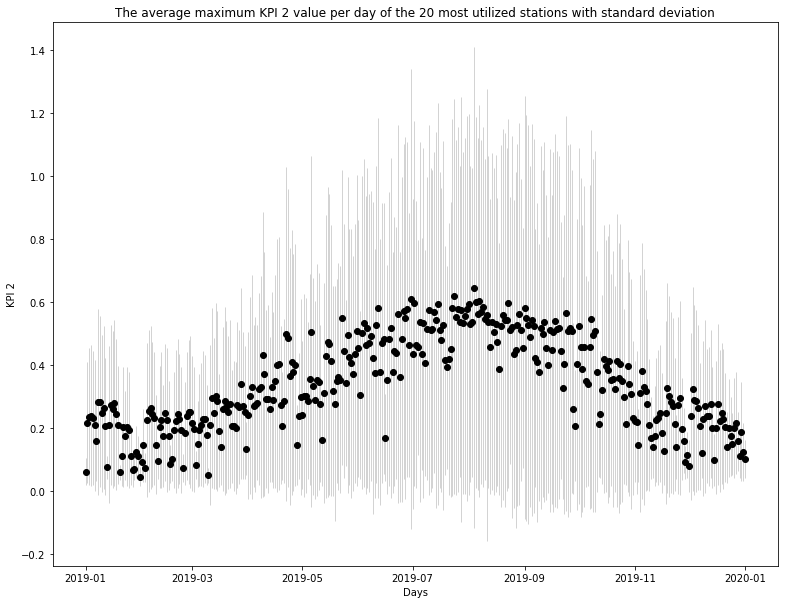

In [127]:
#We now plot the values of KPI 2 for the problematic stations with their respective standard deviation
fig = plt.figure(figsize=(13,10))
plt.errorbar(kpi2_dangerous_day_mean_std["Day_round"], kpi2_dangerous_day_mean_std["Demand_Capacity"], yerr=kpi2_dangerous_day_mean_std["Demand_Capacity_std"], fmt='o', color='black', ecolor='lightgray', elinewidth=1.0, capsize=0)
plt.title("The average maximum KPI 2 value per day of the 20 most utilized stations with standard deviation")
plt.xlabel("Days")
plt.ylabel("KPI 2")
plt.show()

<h3> Plotting KPI 2 for the problematic stations for the weekdays for each month </h3>
In order to investigate which KPI 2 values the problematic stations exhibit throughout the year and additionally throughout the week, we depict them for each month and each weekday, accordingly. In order to do so we create individual dataframes for each month, group them by weekday and reset the indices, to be able to plot the data. 


In [128]:
#Now, we create monthly dataframes for the dangerous stations 
kpi2_dangerous_jan = kpi2_dangerous[kpi2_dangerous["Month"] == 1]
kpi2_dangerous_feb = kpi2_dangerous[kpi2_dangerous["Month"] == 2]
kpi2_dangerous_mar = kpi2_dangerous[kpi2_dangerous["Month"] == 3]
kpi2_dangerous_apr = kpi2_dangerous[kpi2_dangerous["Month"] == 4]
kpi2_dangerous_may = kpi2_dangerous[kpi2_dangerous["Month"] == 5]
kpi2_dangerous_jun = kpi2_dangerous[kpi2_dangerous["Month"] == 6]
kpi2_dangerous_jul = kpi2_dangerous[kpi2_dangerous["Month"] == 7]
kpi2_dangerous_aug = kpi2_dangerous[kpi2_dangerous["Month"] == 8]
kpi2_dangerous_sep = kpi2_dangerous[kpi2_dangerous["Month"] == 9]
kpi2_dangerous_oct = kpi2_dangerous[kpi2_dangerous["Month"] == 10]
kpi2_dangerous_nov = kpi2_dangerous[kpi2_dangerous["Month"] == 11]
kpi2_dangerous_dec = kpi2_dangerous[kpi2_dangerous["Month"] == 12]

In [129]:
#We group them my mean values and reset the index, to be able to plot them
kpi2_dangerous_jan_g = kpi2_dangerous_jan.groupby("Day").mean()
kpi2_dangerous_feb_g = kpi2_dangerous_feb.groupby("Day").mean()
kpi2_dangerous_mar_g = kpi2_dangerous_mar.groupby("Day").mean()
kpi2_dangerous_apr_g = kpi2_dangerous_apr.groupby("Day").mean()
kpi2_dangerous_may_g = kpi2_dangerous_may.groupby("Day").mean()
kpi2_dangerous_jun_g = kpi2_dangerous_jun.groupby("Day").mean()
kpi2_dangerous_jul_g = kpi2_dangerous_jul.groupby("Day").mean()
kpi2_dangerous_aug_g = kpi2_dangerous_aug.groupby("Day").mean()
kpi2_dangerous_sep_g = kpi2_dangerous_sep.groupby("Day").mean()
kpi2_dangerous_oct_g = kpi2_dangerous_oct.groupby("Day").mean()
kpi2_dangerous_nov_g = kpi2_dangerous_nov.groupby("Day").mean()
kpi2_dangerous_dec_g = kpi2_dangerous_dec.groupby("Day").mean()
kpi2_dangerous_jan_g.reset_index(inplace = True) 
kpi2_dangerous_feb_g.reset_index(inplace = True)
kpi2_dangerous_mar_g.reset_index(inplace = True)
kpi2_dangerous_apr_g.reset_index(inplace = True) 
kpi2_dangerous_may_g.reset_index(inplace = True)  
kpi2_dangerous_jun_g.reset_index(inplace = True) 
kpi2_dangerous_jul_g.reset_index(inplace = True)
kpi2_dangerous_aug_g.reset_index(inplace = True)  
kpi2_dangerous_sep_g.reset_index(inplace = True)  
kpi2_dangerous_oct_g.reset_index(inplace = True) 
kpi2_dangerous_nov_g.reset_index(inplace = True) 
kpi2_dangerous_dec_g.reset_index(inplace = True)

<h3>  Plot of the KPI 2 for problematic stations for the weekdays for each month </h3>
Three main results can be derived from the plot below. Firstly, as to expect, the summer months exhibit the highest demand/capacity, with August being the most "problematic" month. Secondly, even in the summer months, the 20 most utilized stations, on average, do not exceed a value of 0.6, meaning that, on average, those station's capacity is not entirely made use of, but only around 60% of the docks/stationed bikes are requested. Thirdly, the weekends usually exhibit lower KPI 2 values than the weekdays, especially in winter, spring and autumn. This is most likely again due to the fact that on weekends, there is no commuting activity. 


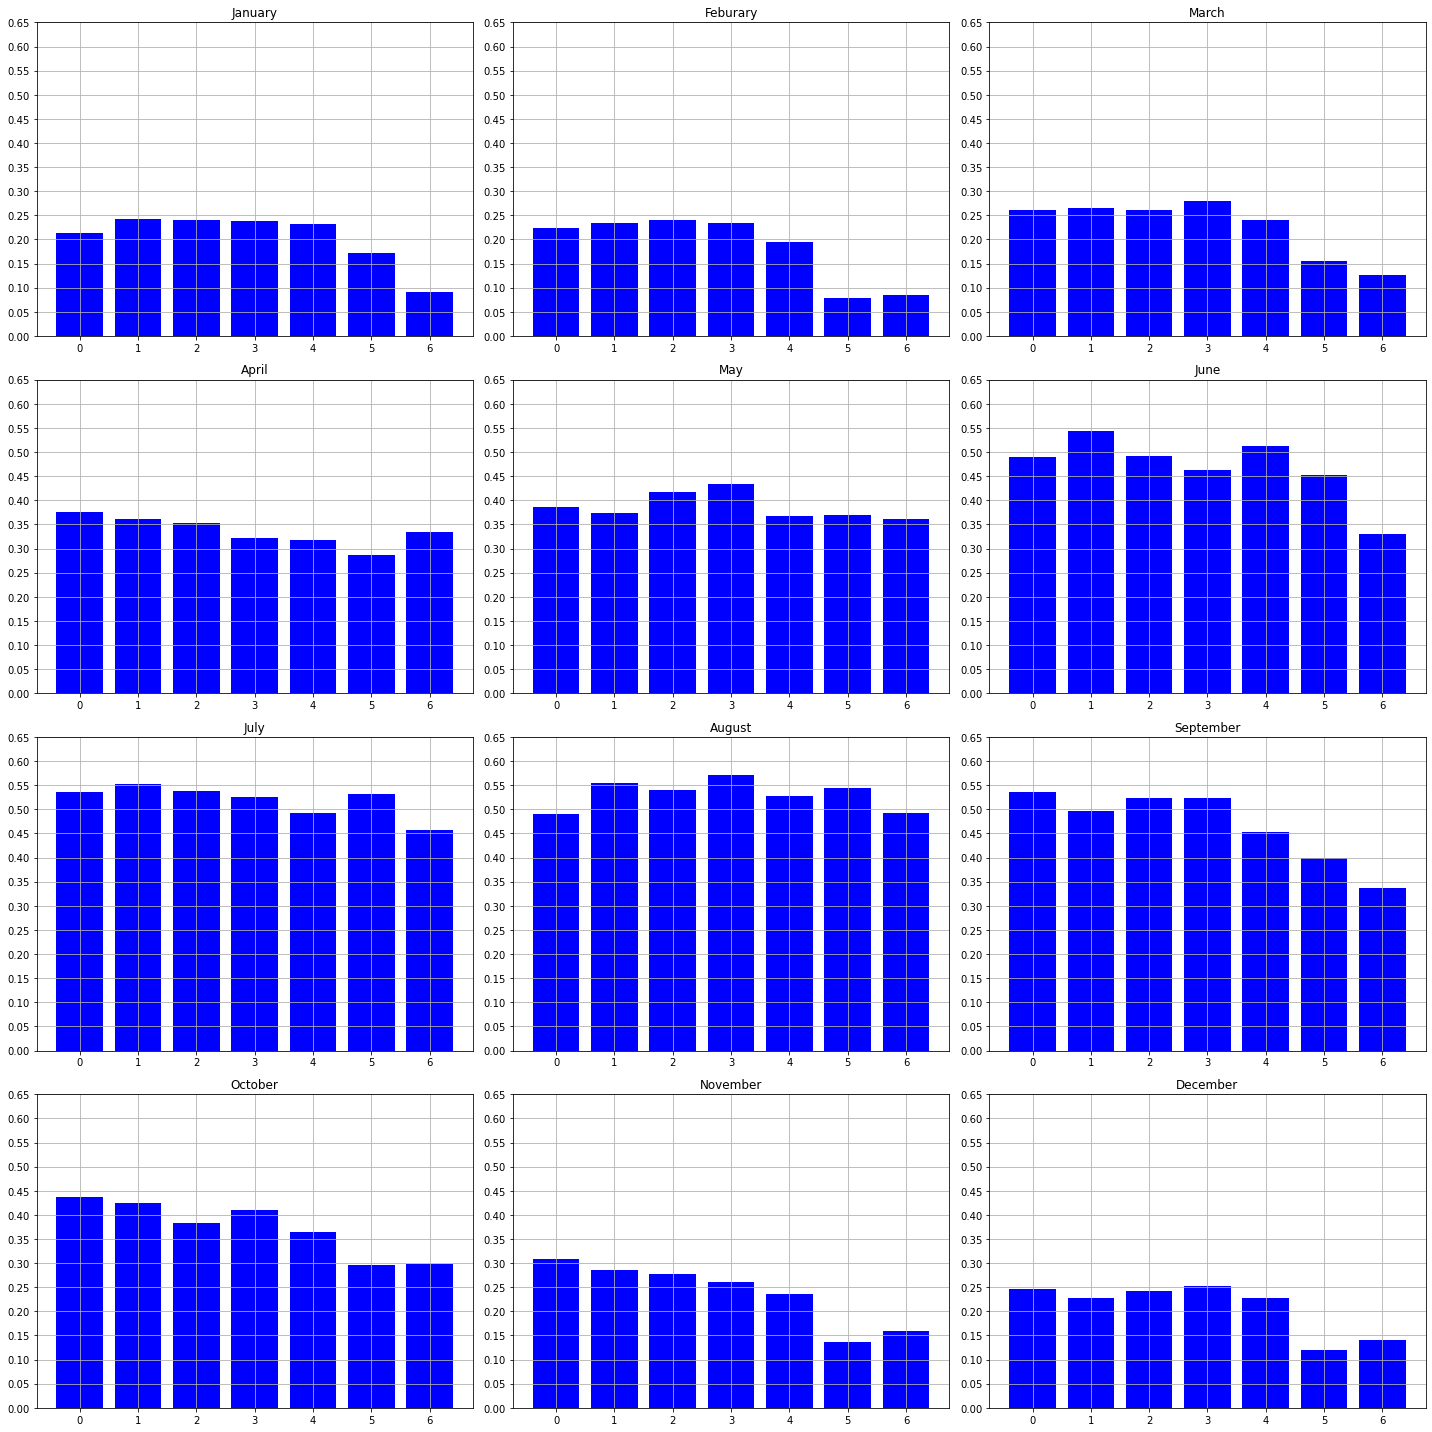

In [130]:
#For each month, we now plot the weekdays and the KPI 2 to depict the development over the week and over the year 
fig, axs = plt.subplots(4, 3, figsize = (20,20))

#Create a subplot for each month, use the weekdays as x axis indicator, the Demand_Capacity as values  
axs[0,0].bar(kpi2_dangerous_jan_g["Day"], kpi2_dangerous_jan_g["Demand_Capacity"], color = "blue",)
axs[0,0].set_title("January")
#axs[0,0].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
#The y axis is set to 0.05 steps and is limited below 0.7 as values do not exceed 0.6
axs[0,0].set_yticks(np.arange(0,0.7,0.05))
axs[0,0].grid(True)



axs[0,1].bar(kpi2_dangerous_feb_g["Day"], kpi2_dangerous_feb_g["Demand_Capacity"], color = "blue")
axs[0,1].set_title("Feburary")
#axs[0,1].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[0,1].set_yticks(np.arange(0,0.7,0.05))
axs[0,1].grid(True)


axs[0,2].bar(kpi2_dangerous_mar_g["Day"], kpi2_dangerous_mar_g["Demand_Capacity"], color = "blue")
axs[0,2].set_title("March")
#axs[0,2].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[0,2].set_yticks(np.arange(0,0.7,0.05))
axs[0,2].grid(True)


axs[1,0].bar(kpi2_dangerous_apr_g["Day"], kpi2_dangerous_apr_g["Demand_Capacity"], color = "blue")
axs[1,0].set_title("April")
#axs[1,0].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[1,0].set_yticks(np.arange(0,0.7,0.05))
axs[1,0].grid(True)
 
axs[1,1].bar(kpi2_dangerous_may_g["Day"], kpi2_dangerous_may_g["Demand_Capacity"], color = "blue")
axs[1,1].set_title("May")
#axs[1,1].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[1,1].set_yticks(np.arange(0,0.7,0.05))
axs[1,1].grid(True)


axs[1,2].bar(kpi2_dangerous_jun_g["Day"], kpi2_dangerous_jun_g["Demand_Capacity"], color = "blue")
axs[1,2].set_title("June")
#axs[1,2].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[1,2].set_yticks(np.arange(0,0.7,0.05))
axs[1,2].grid(True)

 
axs[2,0].bar(kpi2_dangerous_jul_g["Day"], kpi2_dangerous_jul_g["Demand_Capacity"], color = "blue")
axs[2,0].set_title("July")
#axs[2,0].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[2,0].set_yticks(np.arange(0,0.7,0.05))
axs[2,0].grid(True)

 
axs[2,1].bar(kpi2_dangerous_aug_g["Day"], kpi2_dangerous_aug_g["Demand_Capacity"], color = "blue")
axs[2,1].set_title("August")
#axs[2,1].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[2,1].set_yticks(np.arange(0,0.7,0.05))
axs[2,1].grid(True)


axs[2,2].bar(kpi2_dangerous_sep_g["Day"], kpi2_dangerous_sep_g["Demand_Capacity"], color = "blue")
axs[2,2].set_title("September")
#axs[2,2].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[2,2].set_yticks(np.arange(0,0.7,0.05))
axs[2,2].grid(True)

 
axs[3,0].bar(kpi2_dangerous_oct_g["Day"], kpi2_dangerous_oct_g["Demand_Capacity"], color = "blue")
axs[3,0].set_title("October")
#axs[3,0].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[3,0].set_yticks(np.arange(0,0.7,0.05))
axs[3,0].grid(True)


axs[3,1].bar(kpi2_dangerous_nov_g["Day"], kpi2_dangerous_nov_g["Demand_Capacity"], color = "blue")
axs[3,1].set_title("November")
#axs[3,1].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[3,1].set_yticks(np.arange(0,0.7,0.05))
axs[3,1].grid(True)


axs[3,2].bar(kpi2_dangerous_dec_g["Day"], kpi2_dangerous_dec_g["Demand_Capacity"], color = "blue")
axs[3,2].set_title("December")
#axs[3,2].set_xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axs[3,2].set_yticks(np.arange(0,0.7,0.05))
axs[3,2].grid(True)

fig.tight_layout()
plt.show()

<h3> Plotting the location of problematic stations in terms of KPI 2 </h3>
In the following section, the above determined "problematic" stations will be plotted. In order to do so, the KPI 2 table measuring the Demand-Capacity relation (i.e., KPI 2) is merged with the location data. 


In [131]:
#We now want to illustrate stations that exhibit problematic utilization in terms of their capacity as 
#illustrated in KPI2
kpi2_prob.head()

Hour  Station_id  Incoming  Outgoing  Docks in Service  \
304 2019-03-23 16:00:00          35        31        51                47   
436 2019-04-06 12:00:00          35        22        51                47   
438 2019-04-06 14:00:00          35        43        62                47   
439 2019-04-06 15:00:00          35        43        55                47   
440 2019-04-06 16:00:00          35        54        46                47   

     maximum  Demand_Capacity  Demand_cat  Day  Month  Hour_num  
304       51         1.085106           2    5      3        16  
436       51         1.085106           2    5      4        12  
438       62         1.319149           2    5      4        14  
439       55         1.170213           2    5      4        15  
440       54         1.148936           2    5      4        16

In [132]:
#We merge the KPI 2 table with location data 
loc = pd.read_csv("../Data/Divvy_Bicycle_Stations-2.csv")
loc.rename(columns = {"ID": "Station_id"}, inplace = True)
loc.head()

Station_id                  Station Name  Total Docks  Docks in Service  \
0         373      Kedzie Ave & Chicago Ave           11                11   
1         186          Ogden Ave & Race Ave           15                15   
2         102    Stony Island Ave & 67th St           11                11   
3         438  Central Park Ave & Ogden Ave           15                15   
4         656  Damen Ave & Walnut (Lake) St           15                15   

       Status   Latitude  Longitude                                  Location  
0  In Service  41.895465 -87.706128          (41.89546530305, -87.7061278837)  
1  In Service  41.891795 -87.658751                   (41.891795, -87.658751)  
2  In Service  41.773458 -87.585340          (41.77345849948, -87.5853397391)  
3  In Service  41.854064 -87.715117  (41.854063503874464, -87.71511733531952)  
4  In Service  41.885951 -87.677009                   (41.885951, -87.677009)

In [133]:
#Merge the frames
kpi2_loc = loc.merge(kpi2_prob, on = "Station_id")
kpi2_loc.head()

Station_id                  Station Name  Total Docks  Docks in Service_x  \
0         186          Ogden Ave & Race Ave           15                  15   
1         186          Ogden Ave & Race Ave           15                  15   
2         656  Damen Ave & Walnut (Lake) St           15                  15   
3          35       Streeter Dr & Grand Ave           47                  47   
4          35       Streeter Dr & Grand Ave           47                  47   

       Status   Latitude  Longitude                 Location  \
0  In Service  41.891795 -87.658751  (41.891795, -87.658751)   
1  In Service  41.891795 -87.658751  (41.891795, -87.658751)   
2  In Service  41.885951 -87.677009  (41.885951, -87.677009)   
3  In Service  41.892278 -87.612043  (41.892278, -87.612043)   
4  In Service  41.892278 -87.612043  (41.892278, -87.612043)   

                 Hour  Incoming  Outgoing  Docks in Service_y  maximum  \
0 2019-06-26 18:00:00         5        16                  15       16   
1 2019-07-24 17:00:00         3        16                  15       16   
2 2019-07-13 22:00:00        15         4                  15       15   
3 2019-03-23 16:00:00        31        51                  47       51   
4 2019-04-06 12:00:00        22        51                  47       51   

   Demand_Capacity  Demand_cat  Day  Month  Hour_num  
0         1.066667           2    2      6        18  
1         1.066667           2    2      7        17  
2         1.000000           2    5      7        22  
3         1.085106           2    5      3        16  
4         1.085106           2    5      4        12

<h3> Plotting the geospatial distribution of the problematic stations in terms of KPI 2 </h3>
Plotting the 20 most problematic stations in terms of KPI 2, it becomes clear that they are all located in the centre of Chicago, except for two stations. Thus, it could be advisable to increase the number of stations or station capacity in those areas. 


In [134]:
#Create the geometry points to use the in the geopanda plot function
geometry = [Point(xy) for xy  in zip(kpi2_loc["Longitude"], kpi2_loc["Latitude"])]

#Set the coordinates to standard 
crs = {'init':'EPSG:4326'}

#create a geopanda dataframe with defined coordinates and geometry
geo_df_kpi2 = geopandas.GeoDataFrame(kpi2_loc, crs = crs, geometry = geometry)

/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


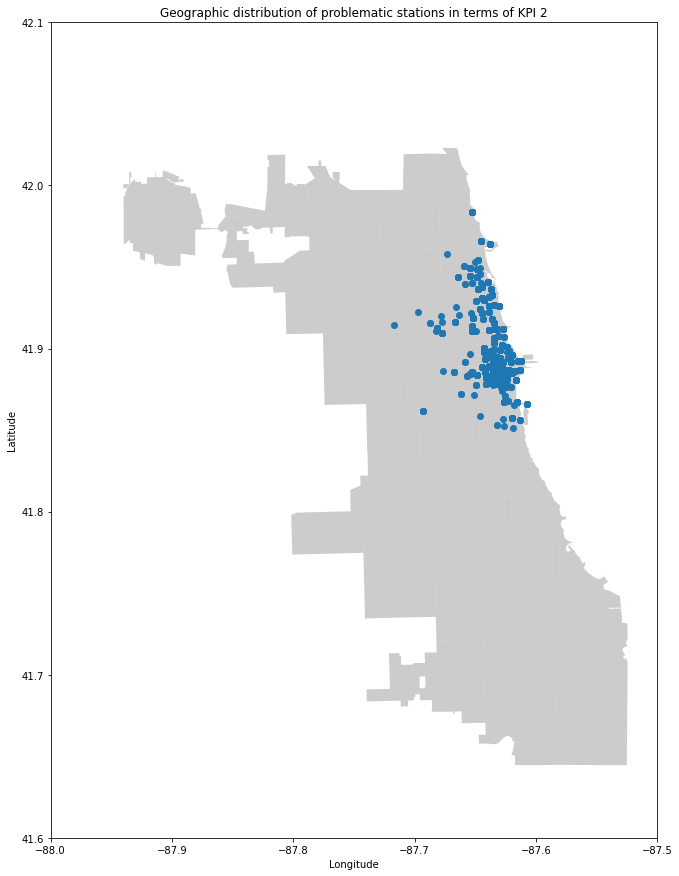

In [135]:
#scatter the problematic stations
fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
geo_df_kpi2.plot(ax=ax)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
plt.title("Geographic distribution of problematic stations in terms of KPI 2")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h3> Geospatial plotting of the KPI 2 values of the problematic stations  </h3>
In the next section, the KPI 2 for the problematic stations is plotted together with the respective station. However, the KPI 2 will only be plotted for August and averaged for the time between 6 am and 10 pm, to yield a time frame that exhibits high rental activity.


In [136]:
#We also want to plot kpi2 in its entirety (except for that we sample)tation 
#Therefore, we repeat the steps above, now for the entire kpi2 table
#However, we only depict August and reasonable times that will yield the most "problematic situations"
#Merge the frames
#We group the frame by station id to only have one representation of each station
kpi2_loc_entire = loc.merge(kpi2[(kpi2["Month"] == 8) & (kpi2["Hour_num"] >= 6) & (kpi2["Hour_num"] <= 22)], on = "Station_id")
kpi2_loc_entire = kpi2_loc_entire.groupby("Station_id").mean()
kpi2_loc_entire.head()

Total Docks  Docks in Service_x   Latitude  Longitude   Incoming  \
Station_id                                                                     
2                  39.0                38.0  41.876535 -87.620473   4.238095   
3                  55.0                55.0  41.867226 -87.615355  11.132832   
4                  23.0                23.0  41.856268 -87.613348   4.364162   
5                  23.0                23.0  41.874053 -87.627716   3.000000   
6                  39.0                39.0  41.886976 -87.612813   8.350746   

            Outgoing  Docks in Service_y    maximum  Demand_Capacity  \
Station_id                                                             
2           3.695238                38.0   5.517460         0.145196   
3           9.641604                55.0  13.711779         0.249305   
4           4.924855                23.0   5.745665         0.249812   
5           2.781646                23.0   3.816456         0.165933   
6           7.480100                39.0  10.034826         0.257303   

            Demand_cat       Day  Month   Hour_num  
Station_id                                          
2             0.123810  3.301587    8.0  14.907937  
3             0.468672  3.160401    8.0  14.208020  
4             0.413295  3.280347    8.0  14.046243  
5             0.174051  3.003165    8.0  14.313291  
6             0.497512  3.293532    8.0  14.407960

In [137]:
#Create the geometry points to use the in the geopanda plot function
geometry = [Point(xy) for xy  in zip(kpi2_loc_entire["Longitude"], kpi2_loc_entire["Latitude"])]

#Set the coordinates to standard 
crs = {'init':'EPSG:4326'}

#create a geopanda dataframe with defined coordinates and geometry
geo_df_kpi2_entire = geopandas.GeoDataFrame(kpi2_loc_entire, crs = crs, geometry = geometry)

/Users/Bjorn/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<h3> Plotting KPI 2 for the described stations </h3>
The same pattern as with the plotted usage above can be obeserved. There are a few red stations in the center of Chicago, meaning they exhibit a KPI 2 close to 1 and thus, a problematic demand in terms of capacity. The outer ring and the outskirts do not exhibit such red points. Overall, the vast majority of stations is not fully utilized, even in August and excluding the night. 


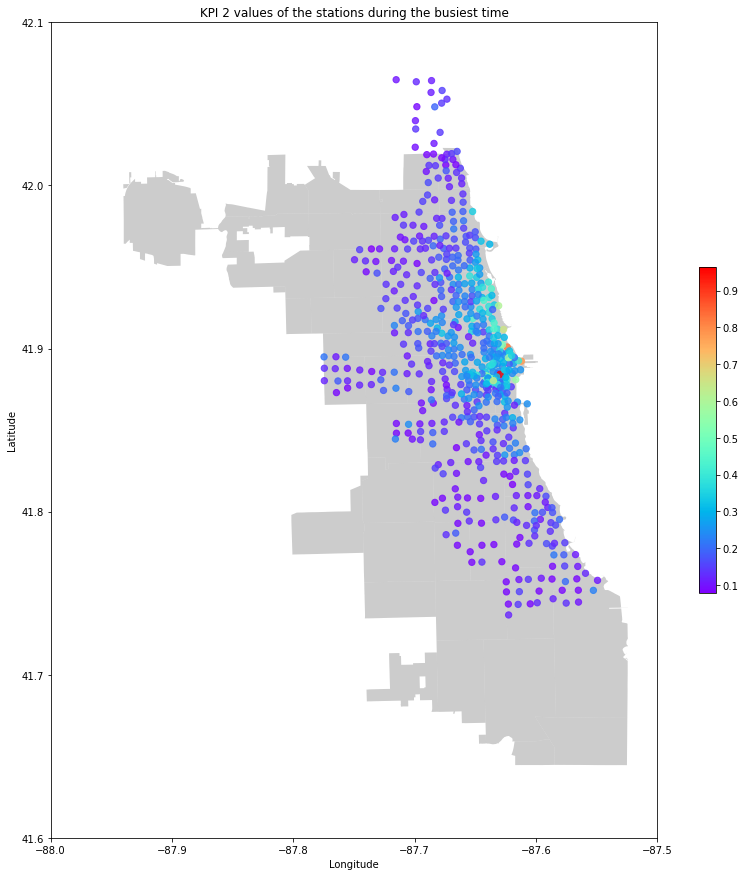

In [181]:
#Now, plot the data

fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
#geo_df.plot(ax=ax, alpha = .1)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
geo_df_kpi2_entire.plot(column = 'Demand_Capacity', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.4}, alpha = 0.8, 
            markersize = 40)
plt.title("KPI 2 values of the stations during the busiest time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h2> 2.3.7 Main Conclusions Based on KPI1 (RPUB) and KPI2 (Demand-Capacity) </h2>

<br>
<li> A clear seasonality can be exhibited. Both KPIs are significantly higher during the summer. </li>

<li> Averaging over all yearly bikes does not meet the target number of rides of 4-6  defined by Boor (2019) </li>

<li> Averaging over all unique daily bikes does meet the target by Boor (2019), at least in the summer months, however it only peaks at around 5. This allows the conclusion that there might be too many bikes or that their distribution is uneven or unsuitable. </li>

<li> The number of rides per unique bike varies significantly more on occasions when it is not rainy, probably due to a higher influence of temperature/other (weather) parameters when it is not raining.  </li>

<li> All KPIs exhibit a commuter pattern, i.e., they peak (on weekdays) at around 8-9 o' clock and at around 17 o' clock.  </li>

<li> The vast majority of stations is properly equipped in terms of capacity. Even the most heavily utilized/requested stations peak in August at an average of 60% ratio of demand to capacity.  </li>

<li> Plotting the distribution of the number of rides and the distribution of the KPIs shows a clear three-ring-structure-pattern. Most of the riding activity measured by number of rides and the KPIs takes place in the very centre of Chicago. A second "ring" around the centre exhibits relatively equal values, however they are lower then in the core or centre "ring". The outskirts of Chicago comprise the third ring, where activity is the lowest.  </li>

<li> Nearly all stations that exhibit the highest demand/capacity KPI values are located in the centre of Chicago.  </li>




<h2> 2.3.8. KPI3: Duration </h2>

In the following part we are looking at the KPI for **average hourly rental durations over different aggregated time slots**.
We have selected this KPI to get an detailed insight on different patterns for the average hourly duration on different time scales. This KPI can then be used to compare the actual average hourly rental duration to those on different time intervals in order to see if the KPI is higher or lower. In a business scenario, the duration of the bike rides is also correlated to the generating of revenue and should be monitored carefully. One could also think of a real-time tariff pricing adjustment, regarding the trip times, in which the prices are increased if the duration KPI is comparably high, e.g. during the rush hour.

We will first start with the distribution over the whole year 2019, then we continue while comparing durations between summer & winter and weekends & weekdays. To conclude we also take the weather data into account. During this section several patterns are explored.

<h3> 2.3.8.1 Average Hourly Rental Durations: Year 2019 </h3>

In [139]:
# Preparation for caculating average hourly rental duration
# Add a new column which only has the full hour of a bike trips (measured on the start time)
divvy_bike_set_avg_hrl_dur = divvy_bike_set.reset_index().set_index('full_hour_start')
divvy_bike_set_avg_hrl_dur["full_hour"] = divvy_bike_set_avg_hrl_dur.index.hour
divvy_bike_set_avg_hrl_dur.head(5)

index          start_time            end_time  \
full_hour_start                                                  
2019-01-01           0 2019-01-01 00:04:37 2019-01-01 00:11:07   
2019-01-01           1 2019-01-01 00:08:13 2019-01-01 00:15:34   
2019-01-01           2 2019-01-01 00:13:23 2019-01-01 00:27:12   
2019-01-01           3 2019-01-01 00:13:45 2019-01-01 00:43:28   
2019-01-01           4 2019-01-01 00:14:52 2019-01-01 00:20:56   

                 start_station_id  end_station_id  \
full_hour_start                                     
2019-01-01                    199              84   
2019-01-01                     44             624   
2019-01-01                     15             644   
2019-01-01                    123             176   
2019-01-01                    173              35   

                                  start_station_name  \
full_hour_start                                        
2019-01-01                    Wabash Ave & Grand Ave   
2019-01-01                    State St & Randolph St   
2019-01-01                      Racine Ave & 18th St   
2019-01-01            California Ave & Milwaukee Ave   
2019-01-01       Mies van der Rohe Way & Chicago Ave   

                               end_station_name  bike_id   user_type  \
full_hour_start                                                        
2019-01-01            Milwaukee Ave & Grand Ave     2167  Subscriber   
2019-01-01       Dearborn St & Van Buren St (*)     4386  Subscriber   
2019-01-01        Western Ave & Fillmore St (*)     1524  Subscriber   
2019-01-01                    Clark St & Elm St      252  Subscriber   
2019-01-01              Streeter Dr & Grand Ave     1170  Subscriber   

                   duration_time  ...  duration_min  duration_hour  \
full_hour_start                   ...                                
2019-01-01       0 days 00:06:30  ...      6.500000       0.108333   
2019-01-01       0 days 00:07:21  ...      7.350000       0.122500   
2019-01-01       0 days 00:13:49  ...     13.816667       0.230278   
2019-01-01       0 days 00:29:43  ...     29.716667       0.495278   
2019-01-01       0 days 00:06:04  ...      6.066667       0.101111   

                 weekday_start       full_hour_end max_temp  precip  hour  \
full_hour_start                                                             
2019-01-01                True 2019-01-01 00:00:00      1.1     1.0     0   
2019-01-01                True 2019-01-01 00:00:00      1.1     1.0     0   
2019-01-01                True 2019-01-01 00:00:00      1.1     1.0     0   
2019-01-01                True 2019-01-01 01:00:00      1.1     1.0     0   
2019-01-01                True 2019-01-01 00:00:00      1.1     1.0     0   

                 interpol  Quarter  full_hour  
full_hour_start                                
2019-01-01          False        1          0  
2019-01-01          False        1          0  
2019-01-01          False        1          0  
2019-01-01          False        1          0  
2019-01-01          False        1          0  

[5 rows x 21 columns]

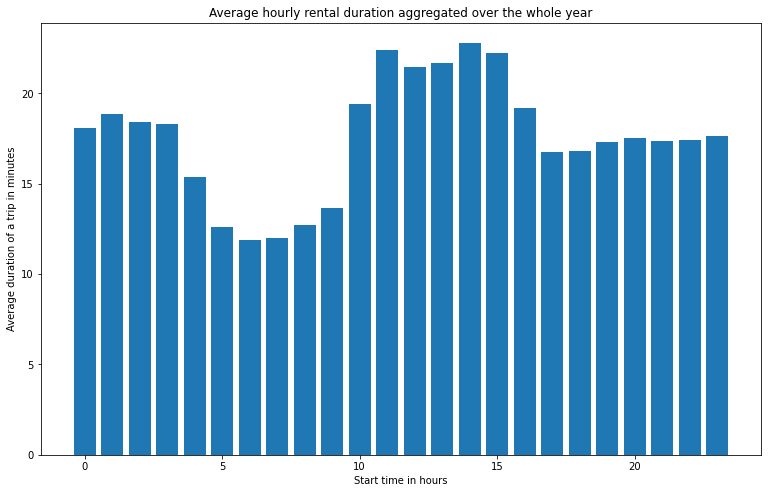

In [140]:
# Average hourly rental duration (based on the start time) of a trip aggregated over the whole year

# Group by the hour
divvy_bike_set_hourly_grouped =  divvy_bike_set_avg_hrl_dur.groupby("full_hour").mean()

# Create a figure
Fig_avg_hrl_rd_1 = plt.figure(figsize=(10,6))

# Add axes to the figure
ax_1 = Fig_avg_hrl_rd_1.add_axes([0, 0, 1, 1]) #The dimensions [left, bottom, width, height] of the axes

# Onto these axes we can now plot and add labels
ax_1.bar(divvy_bike_set_hourly_grouped.index, divvy_bike_set_hourly_grouped["duration_min"])
ax_1.set_xlabel('Start time in hours')
ax_1.set_ylabel('Average duration of a trip in minutes')
ax_1.set_title('Average hourly rental duration aggregated over the whole year')

plt.show()

In the distribution over the year 2019, it can be seen that between 10 and 15 o'clock  the hourly duration has its highest peak. So during the midday the average duration is highest. There could be several reasons for this observation, one could be that people take a divvy bike during lunch to reach restaurants. Between 0 and 4 o'clock the average hourly duration is at its second highest peak. One theory could be that late at night other public transport possibilities do not operate and the divvy bikes are then used as a replacement by people. Between 5 and 9 o'clock the average duration is lowest during the day, meaning that those bike rides are more often used for short trips.

<h3> 2.3.8.2 Comparison of Average Hourly Duration: Summer/Winter & Weekdays/Weekends </h3>
    
Now we want to look at the same KPI but on a different time scale. We are now comparing the average duration of a trip
between summer and winter and weekdays and weekends.

For the summer aggregation, we take data from June, July and August. <br>
For the winter aggregation, we take data from December, January and February.

In [141]:
# Average hourly rental duration (based on the start time) of a trip aggregated over the whole year on weekends in summer
# Select only data on weekends and in summer and group by the full hour attribute
divvy_bike_set_hourly_summer_we = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["weekday_start"] == False) & (divvy_bike_set_avg_hrl_dur["start_time"] > "2019-06-01") & (divvy_bike_set_avg_hrl_dur["start_time"] < "2019-09-01")]
divvy_bike_set_hourly_summer_we_grouped = divvy_bike_set_hourly_summer_we.groupby("full_hour").mean()

In [142]:
# Average hourly rental duration (based on the start time) of a trip aggregated over the whole year on weekends in winter
# Only use data from beginning of december to february
divvy_bike_set_hourly_winter_we = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["weekday_start"] == False) & (divvy_bike_set_avg_hrl_dur["start_time"] > "2019-12-01") | (divvy_bike_set_avg_hrl_dur["start_time"] < "2019-03-01")]
divvy_bike_set_hourly_winter_we_grouped = divvy_bike_set_hourly_winter_we.groupby("full_hour").mean()

In [143]:
# Average hourly rental duration (based on the start time) of a trip aggregated over the whole year on weekdays in summer
# Select only data on weekdays and in summer and group by the full hour attribute
divvy_bike_set_hourly_summer_wd = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["weekday_start"] == True) & (divvy_bike_set_avg_hrl_dur["start_time"] > "2019-06-01") & (divvy_bike_set_avg_hrl_dur["start_time"] < "2019-09-01")]
divvy_bike_set_hourly_summer_wd_grouped = divvy_bike_set_hourly_summer_wd.groupby("full_hour").mean()

In [144]:
# Average hourly rental duration (based on the start time) of a trip aggregated over the whole year on weekdays in winter

# Only use data from beginning of december to end of february
divvy_bike_set_hourly_winter_wd = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["weekday_start"] == True) & (divvy_bike_set_avg_hrl_dur["start_time"] > "2019-12-01") | (divvy_bike_set_avg_hrl_dur["start_time"] < "2019-03-01")]
divvy_bike_set_hourly_winter_wd_grouped = divvy_bike_set_hourly_winter_wd.groupby("full_hour").mean()

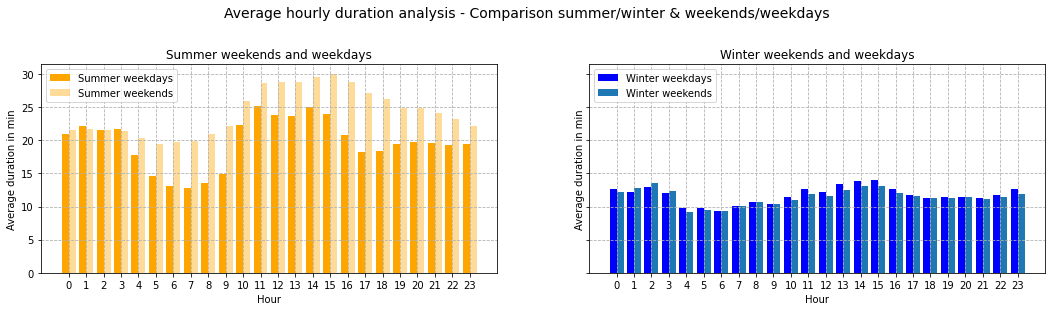

In [145]:
#Plot the four aforementioned data sets
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots(1, 2, figsize=(18,4), sharex=True, sharey = True)

ax1[0].bar(x+width/2, divvy_bike_set_hourly_summer_wd_grouped["duration_min"], width, label='Summer weekdays',align="center", color="orange")
ax1[0].bar(x+3*width/2, divvy_bike_set_hourly_summer_we_grouped["duration_min"], width, label='Summer weekends',align="center",color="orange",alpha=0.4)
ax1[0].set_title("Summer weekends and weekdays")
ax1[0].set_xlabel("Hour")
ax1[0].set_ylabel("Average duration in min")
ax1[0].legend()
ax1[0].grid(linestyle='--')

ax1[1].bar(x+width/2, divvy_bike_set_hourly_winter_wd_grouped["duration_min"], width, label='Winter weekdays',align="center", color="blue")
ax1[1].bar(x+3*width/2, divvy_bike_set_hourly_winter_we_grouped["duration_min"], width, label='Winter weekends',align="center")
ax1[1].set_title("Winter weekends and weekdays")
ax1[1].set_xlabel("Hour")
ax1[1].set_ylabel("Average duration in min")
ax1[1].legend(loc="upper left")
ax1[1].grid(linestyle='--')


# Give all subplots a legend and move it up a bit
heading = plt.suptitle("Average hourly duration analysis - Comparison summer/winter & weekends/weekdays",fontsize=14)
heading.set_y(1.05)
fig.subplots_adjust(top=0.85)
plt.xticks(x + width,x)
        
plt.show()

**Summer** 

In summer the average duration of a trip varies during the day and the same pattern as described in section 1 can be seen. Only on summer weekends between 5 and 9 o'clock the average duration is higher compared to it during the whole year. This pattern could be explained by the fact that people tend to stay awake longer and party or meet with friends during the weekend. In these late hours the same explanation as mentioned before concerning the substituion of other mobile transport methods could hold. <br>

Really interesting is that the average duration on weekends in summer is nearly on all hours higher than on weekdays. This could be interpreted so that in summer, if the weather is warm, and people have more free time on weekends, they use this opportunity to take a bike ride, not necessarily to get to work or a store but also just for a relaxed bike trip. <br>
It can also be seen that the highest average duration time at 15 o'clock is still below 30 minutes which is probably caused by the shorter bike routes in the city and the density of stations. Furthermore, 45 minutes is the threshold for customers to pay additional fees and it could be possible that they want to make sure not to exceed this limit. An economic intrinsic for the Divvy Bike company could be to set the threshold lower, e.g. at 15 or 20 minutes, to have higher paying trips. <br>

**Winter**

In winter the distribution of the average duration, both on weekends and on weekdays, is very similar and has no severe ups and downs. This means that regardless of whether it is a weekday or a weekend, people do not take long bike trips. One possible cause could be the colder weather. Consequently, seasonality also plays a role in the duration of the trips.

**Comparison**

In comparison of the summer and winter average durations the already analysed seasonal trend is also appliable. To make the difference between summer and winter even clearer, this is computed and plotted next.

In [146]:
# Computing the difference of average hourly duration between summer and winter weekends/weekdays

diff_we = round(divvy_bike_set_hourly_summer_we_grouped["duration_min"]-divvy_bike_set_hourly_winter_we_grouped["duration_min"],2)
diff_wd = round(divvy_bike_set_hourly_summer_wd_grouped["duration_min"]-divvy_bike_set_hourly_winter_wd_grouped["duration_min"],2)

diff = pd.DataFrame({'Average duration difference weekdays': diff_wd,
                       'Average duration difference weekends': diff_we})
diff.columns

Index(['Average duration difference weekdays', 'Average duration difference weekends'], dtype='object')

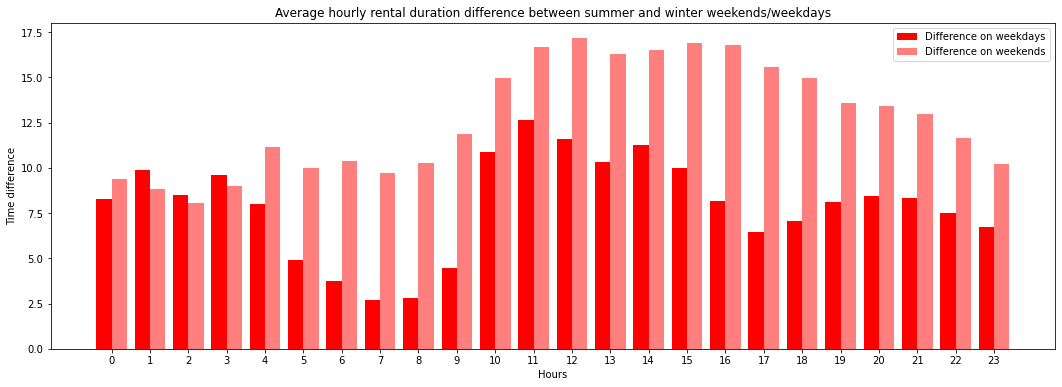

In [147]:
x = np.arange(24)
width = 0.4

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(6)

ax.bar(x+width/2, diff["Average duration difference weekdays"], width, label="Difference on weekdays",align="center",color="red")
ax.bar(x+3*width/2, diff["Average duration difference weekends"], width, label="Difference on weekends",align="center",color="red",alpha=0.5)
ax.set_xlabel('Hours')
ax.set_ylabel('Time difference')
ax.set_title('Average hourly rental duration difference between summer and winter weekends/weekdays')

plt.xticks(x + width,x)
plt.legend()

plt.show()

Comparing the summer and winter data, it can be easily seen that in summer the average duration is higher on all hours. As also described above the average duration on summer weekends is even higher than on weekdays and thus, the difference on weekends between summer and winter is even more distinct.

<h3> 2.3.8.3 Average Duration Combined with Weather Data </h3>

To also take the weather data into account, next the average duration is analysed combined with the temperature and precip. Therefore, we calculate the KPI for the average hourly distribution of rides while it was raining (on the start time) and average hourly distribution if the temperature is above 15°C (on the start time). Then we compare these two with the distribution over the whole year (plot 1 of this KPI).

In [148]:
# Calculating average hourly rental duration with precip
divvy_bike_set_avg_hrl_dur_precip = divvy_bike_set.reset_index().set_index('full_hour_start')
divvy_bike_set_avg_hrl_dur_precip["full_hour"] = divvy_bike_set_avg_hrl_dur.index.hour

# Only focus on data with given precip
divvy_bike_set_avg_hrl_dur_precip = divvy_bike_set_avg_hrl_dur_precip[divvy_bike_set_avg_hrl_dur_precip["precip"] == 1]
# Group by the full hour and apply mean to retrieve the duration for each hour with given precip
divvy_bike_set_avg_hrl_grouped_precip =  divvy_bike_set_avg_hrl_dur_precip.groupby("full_hour").mean()
divvy_bike_set_avg_hrl_grouped_precip.head()

index  start_station_id  end_station_id      bike_id  \
full_hour                                                                
0          1.587344e+06        218.618738      235.540664  3378.385166   
1          1.938114e+06        214.648676      229.629328  3399.184318   
2          2.284881e+06        221.744422      239.778905  3423.277890   
3          1.463985e+06        208.577273      230.418182  3369.695455   
4          2.147539e+06        247.570064      231.923567  3561.936306   

           duration_sec  duration_min  duration_hour  weekday_start  \
full_hour                                                             
0            830.571893     13.842865       0.230714       0.745608   
1            909.941955     15.165699       0.252762       0.902240   
2            818.545639     13.642427       0.227374       0.823529   
3            976.688636     16.278144       0.271302       0.722727   
4            699.003185     11.650053       0.194168       0.914013   

            max_temp  precip  hour  interpol   Quarter  
full_hour                                               
0          13.142470     1.0   0.0  0.173715  2.296682  
1          12.569203     1.0   1.0  0.351324  2.522403  
2           8.551978     1.0   2.0  0.141988  2.738337  
3          13.689242     1.0   3.0  0.206818  2.181818  
4          10.207590     1.0   4.0  0.238854  2.850318

In [149]:
# Caculating average hourly rental duration with temperature above 15°C
divvy_bike_set_avg_hrl_dur_temp = divvy_bike_set.reset_index().set_index('full_hour_start')
divvy_bike_set_avg_hrl_dur_temp["full_hour"] = divvy_bike_set_avg_hrl_dur.index.hour

# Only focus on data with temp above 15
divvy_bike_set_avg_hrl_dur_temp = divvy_bike_set_avg_hrl_dur_temp[divvy_bike_set_avg_hrl_dur_temp["max_temp"] >= 15]
# Group by the full hour and apply mean to retrieve the duration for each hour with temperature above 15°C
divvy_bike_set_avg_hrl_dur_grouped_temp =  divvy_bike_set_avg_hrl_dur_temp.groupby("full_hour").mean()
divvy_bike_set_avg_hrl_dur_grouped_temp.head()

index  start_station_id  end_station_id      bike_id  \
full_hour                                                                
0          2.002960e+06        209.864384      228.652309  3360.178548   
1          1.996787e+06        216.500386      228.008577  3365.704263   
2          2.013476e+06        219.305514      232.613738  3382.322585   
3          2.027474e+06        218.140637      242.802739  3374.719252   
4          2.031627e+06        230.556796      230.749840  3295.005424   

           duration_sec  duration_min  duration_hour  weekday_start  \
full_hour                                                             
0           1214.670037     20.244501       0.337408       0.765024   
1           1288.505446     21.475091       0.357918       0.743117   
2           1256.944723     20.949079       0.349151       0.690692   
3           1240.107980     20.668466       0.344474       0.726890   
4           1063.753669     17.729228       0.295487       0.761646   

            max_temp    precip  hour  interpol   Quarter  
full_hour                                                 
0          21.355029  0.040487   0.0  0.022618  2.783504  
1          20.957245  0.044086   1.0  0.072991  2.790634  
2          20.465729  0.025335   2.0  0.084406  2.787563  
3          20.396276  0.072162   3.0  0.107190  2.786410  
4          19.546767  0.045310   4.0  0.061902  2.784301

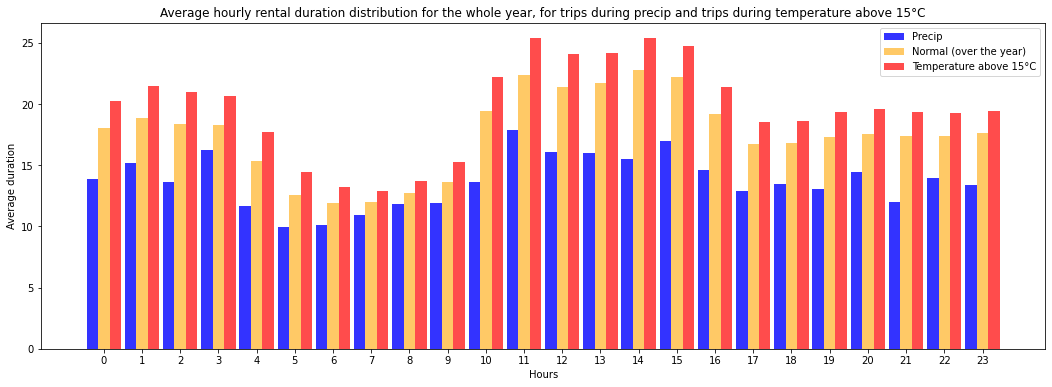

In [150]:
# Plot of three data sets

x = np.arange(24)
width = 0.3

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(6)

ax.bar(x, divvy_bike_set_avg_hrl_grouped_precip["duration_min"], width, label="Precip",align="center",color="blue",alpha=0.8)
ax.bar(x+width, divvy_bike_set_hourly_grouped["duration_min"], width, label="Normal (over the year)",align="center",color="orange",alpha=0.6)
ax.bar(x+2*width, divvy_bike_set_avg_hrl_dur_grouped_temp["duration_min"], width, label="Temperature above 15°C",align="center",color="red",alpha=0.7)

ax.set_xlabel('Hours')
ax.set_ylabel('Average duration')
ax.set_title('Average hourly rental duration distribution for the whole year, for trips during precip and trips during temperature above 15°C')

plt.xticks(x + width,x)
plt.legend()

plt.show()

As expected, the duration of trips during a temperature above 15°C are longer than the average over the year and even longer than during precip. So, if it is raining or not and the temperature have an influence on the bike trip duration.

In [151]:
precip_temp_diff = divvy_bike_set_avg_hrl_dur_grouped_temp["duration_min"] - divvy_bike_set_avg_hrl_grouped_precip["duration_min"]
precip_temp_diff.mean()

5.950690780177449

To be precise, **the average duration with warm temperature is 5,08 minutes longer than with precip**.

To come to an end, we now compare the average duration when it is raining versus when it is not raining.

In [152]:
divvy_bike_set_hourly_rain = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["precip"] == 1)]
divvy_bike_set_hourly_rain_grouped = divvy_bike_set_hourly_rain.groupby("full_hour").mean()

divvy_bike_set_hourly_dry = divvy_bike_set_avg_hrl_dur[(divvy_bike_set_avg_hrl_dur["precip"] == 0)]
divvy_bike_set_hourly_dry_grouped = divvy_bike_set_hourly_dry.groupby("full_hour").mean()

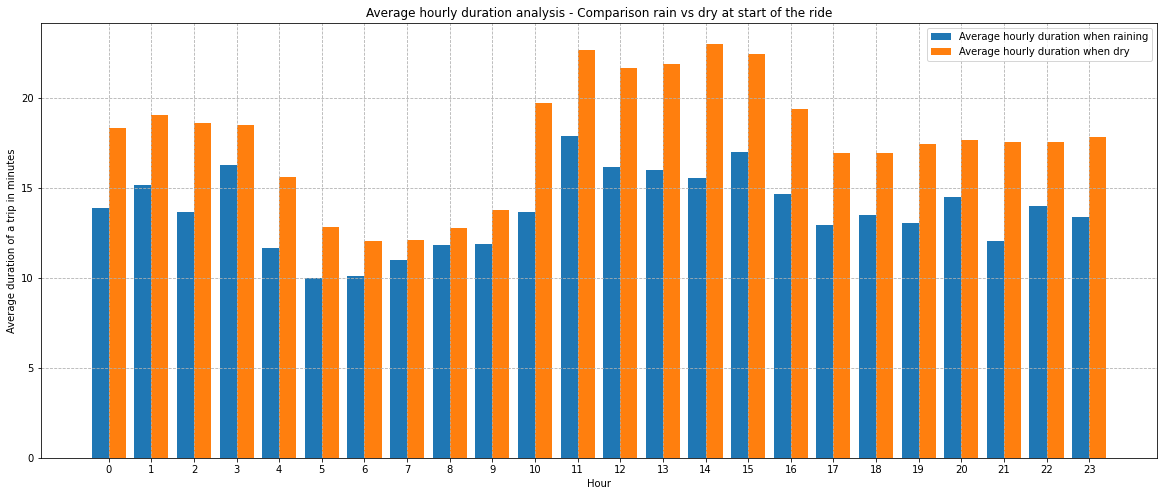

In [153]:
x = np.arange(24)
width = 0.4

fig, ax1 = plt.subplots()

av_dur_rain = ax1.bar(x+width/2, divvy_bike_set_hourly_rain_grouped["duration_min"], width, label='Average hourly duration when raining',align="center")
av_dur_dry = ax1.bar(x+3*width/2, divvy_bike_set_hourly_dry_grouped["duration_min"], width, label='Average hourly duration when dry',align="center")


fig.set_figwidth(20)
fig.set_figheight(8)
plt.xlabel("Hour")
plt.ylabel("Average duration of a trip in minutes")
plt.title("Average hourly duration analysis - Comparison rain vs dry at start of the ride")
plt.grid(linestyle='--')
plt.xticks(x + width,x)
plt.legend()
        
plt.show()

This chart shows, that the average hourly durations are longer when it is dry outside, ranging from about 12 to 23 minutes, while rides when it is raining last between 11 and 18 minutes.

In [154]:
# Average yearly duration
rain_drives = sum(list(map(lambda z: z == 1.0, divvy_bike_set["precip"])))
rain_durations =  divvy_bike_set.loc[divvy_bike_set['precip'] == 1.0, 'duration_min'].sum()

dry_drives = sum(list(map(lambda z: z == 0.0, divvy_bike_set["precip"])))
dry_durations =  divvy_bike_set.loc[divvy_bike_set['precip'] == 0.0, 'duration_min'].sum()

rain_drives, rain_durations, dry_drives, dry_durations 
average_rain_duration = rain_durations / rain_drives
average_dry_duration = dry_durations / dry_drives

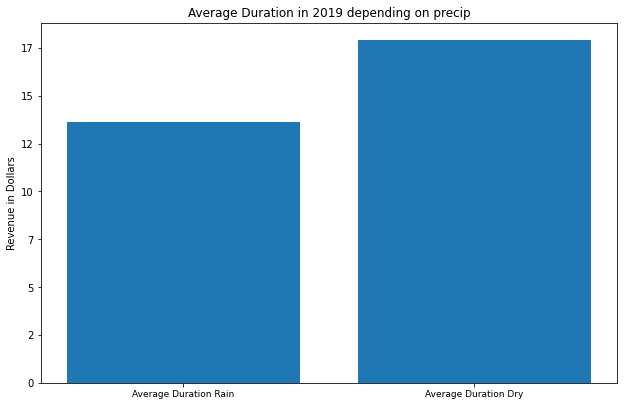

(13.624873233323031, 17.922121159959893)

In [155]:
# plot duration
durations = [average_rain_duration, average_dry_duration]
label_text=["Average Duration Rain", "Average Duration Dry"]
figure_annual = plt.figure(figsize=(8,5))
ax = figure_annual.add_axes([0,0,1,1])

ax.bar(label_text, durations)
ax.set_ylabel("Revenue in Dollars")
ax.set_title("Average Duration in 2019 depending on precip")
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()
average_rain_duration, average_dry_duration

You can see that the average duration over the year is slightly higher (17.94 minutes) when it is dry than when it is raining (14.78 minutes)

<h3> 2.3.8.4 Plotting the Logarithmic Duration of Rides </h3>


In the subsequent plot, each dot represents one ride, however the color indicates the duration of the respective ride that started there. The duration was logged in order to be able to better distinguish the durations. 
Generally, no clear geographical pattern in terms of the ride duration can be derived. Whilst the majority of rides is of mediocre length, some points stand out in red color. However, the latter are distributed rather evenly over the map. The duration does not seem to be related to geographical aspects.


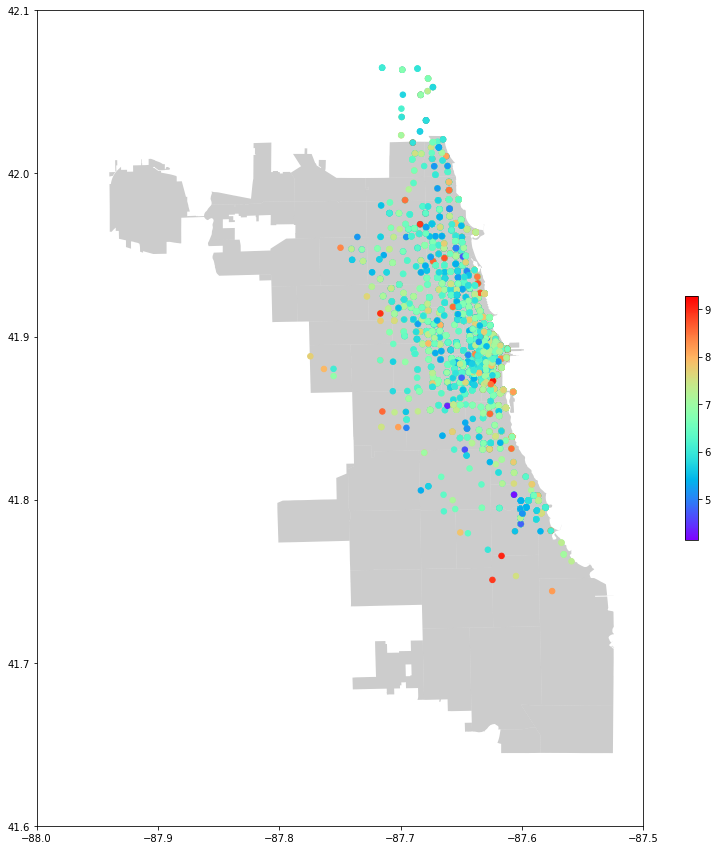

In [156]:
#In this plot, we investigate the usages according to their logarithmic duration

geo_df["log_duration_sec"] = np.log(geo_df["duration_sec"])

fig, ax = plt.subplots(figsize=(15, 15))
chic.to_crs(epsg=4326).plot(ax=ax, color="grey", alpha=0.4)
#geo_df.plot(ax=ax, alpha = .1)
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)
geo_df.plot(column = 'log_duration_sec', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 30)
plt.show()

<h3> 2.3.8.5 Conclusion on KPI Duration </h3>

In [157]:
whole_year = divvy_bike_set_hourly_grouped["duration_min"].describe()['mean']
summer_weekends = divvy_bike_set_hourly_summer_we_grouped["duration_min"].describe()['mean']
winter_weekends = divvy_bike_set_hourly_winter_we_grouped["duration_min"].describe()['mean']
summer_weekdays = divvy_bike_set_hourly_summer_wd_grouped["duration_min"].describe()['mean']
winter_weekdays = divvy_bike_set_hourly_winter_wd_grouped["duration_min"].describe()['mean']
precip = divvy_bike_set_avg_hrl_grouped_precip["duration_min"].describe()['mean']
temp = divvy_bike_set_avg_hrl_dur_grouped_temp["duration_min"].describe()['mean']

data = [['Whole Year', whole_year], ['Summer Weekends', summer_weekends],['Summer Weekdays', summer_weekdays],['Winter Weekends', winter_weekends],['Winter Weekdays', winter_weekdays],['Precip', precip],['Temp above 15°C', temp]]
df = pd.DataFrame(data, columns = ['Time Scale', 'KPI: Average duration'])
df

Time Scale  KPI: Average duration
0       Whole Year              17.574653
1  Summer Weekends              24.249130
2  Summer Weekdays              19.667574
3  Winter Weekends              11.477111
4  Winter Weekdays              11.733988
5           Precip              13.723743
6  Temp above 15°C              19.674434

**Before moving on to the next KPI, we conclude by listing up the main observations which can also be seen in the above table**:
- Longest average durations during midday
- Lowest durations between 5 and 9 o'clock
- Seasonality pattern: 
	- In summer longer durations, durations on weekends in summer > durations on weekdays in summer
	- In winter overall shorter durations during the whole day regardless of weekend or weekday
- Weather pattern: 
    - During precip average durations are nearly 6 minutes shorter than on temperatures above 15°C  
    - During precip average duration are 3,2 minutes shorter than without precip
- The duration of the rides does not seem to be linked to the geographical starting point of a ride


## 2.3.9 KPI 4: Revenue

Next, we concentrate on the **revenue over the year**. We selected this KPI as it is a key factor for the company to measure their performance. We start with distribution over the whole year 2019, then we continue comparing the revenue between summer & winter and between the weekdays.





The revenue is calculated differently for customers and for subscribers. Divvy bikes offers the option of a daily pass for 15\\$  unlimited rides in a 24-hour period up to 3 hours for each ride. This option was not considered as it is unclear to which user types it belongs and what proportion of the user type it has. For customers, the first 30 minutes cost 3.30\\$ and every minute afterwards costs additional 0.15\\$. For subscribers, trips up to 45 minutes are free and after that every minute costs 0.15\\$. The membership costs 108\\$ a year.

###  2.3.9.1 Yearly Revenue for 2019

In [158]:
#calculate Revenue 

#round duration up to calculate minutes that have to be paid
divvy_bike_set["duration_min_rounded"] = np.ceil(divvy_bike_set["duration_min"])
divvy_bike_set.head()

start_time            end_time  start_station_id  end_station_id  \
0 2019-01-01 00:04:37 2019-01-01 00:11:07               199              84   
1 2019-01-01 00:08:13 2019-01-01 00:15:34                44             624   
2 2019-01-01 00:13:23 2019-01-01 00:27:12                15             644   
3 2019-01-01 00:13:45 2019-01-01 00:43:28               123             176   
4 2019-01-01 00:14:52 2019-01-01 00:20:56               173              35   

                    start_station_name                end_station_name  \
0               Wabash Ave & Grand Ave       Milwaukee Ave & Grand Ave   
1               State St & Randolph St  Dearborn St & Van Buren St (*)   
2                 Racine Ave & 18th St   Western Ave & Fillmore St (*)   
3       California Ave & Milwaukee Ave               Clark St & Elm St   
4  Mies van der Rohe Way & Chicago Ave         Streeter Dr & Grand Ave   

   bike_id   user_type    duration_time  duration_sec  ...  duration_hour  \
0     2167  Subscriber  0 days 00:06:30         390.0  ...       0.108333   
1     4386  Subscriber  0 days 00:07:21         441.0  ...       0.122500   
2     1524  Subscriber  0 days 00:13:49         829.0  ...       0.230278   
3      252  Subscriber  0 days 00:29:43        1783.0  ...       0.495278   
4     1170  Subscriber  0 days 00:06:04         364.0  ...       0.101111   

   weekday_start  full_hour_start       full_hour_end max_temp  precip  hour  \
0           True       2019-01-01 2019-01-01 00:00:00      1.1     1.0     0   
1           True       2019-01-01 2019-01-01 00:00:00      1.1     1.0     0   
2           True       2019-01-01 2019-01-01 00:00:00      1.1     1.0     0   
3           True       2019-01-01 2019-01-01 01:00:00      1.1     1.0     0   
4           True       2019-01-01 2019-01-01 00:00:00      1.1     1.0     0   

   interpol  Quarter  duration_min_rounded  
0     False        1                   7.0  
1     False        1                   8.0  
2     False        1                  14.0  
3     False        1                  30.0  
4     False        1                   7.0  

[5 rows x 21 columns]

In [159]:
#function to calculate the revenue from customers
def calc_revenue_cus(z):
    if (z<30):
        a=3.3
    else: 
        a=3.3+0.15*(z-30)
       
    return a

calc_revenue_cus(15)

3.3

In [160]:
#function to calculate the revenue from subscribers without their membership costs
def calc_revenue_sub(z):
    if z<45:
        a=0
    else: 
        a=0.15*(z-45)
        
    return a

calc_revenue_sub(40)

0

In [161]:
#calcultate price per use for costumers and additional costs for subscribers per use 

divvy_bike_set["revenue"] = np.where(divvy_bike_set["user_type"]== "Subscriber", list(map(lambda z: calc_revenue_sub(z) , divvy_bike_set["duration_min_rounded"])), list(map(lambda z: calc_revenue_cus(z), divvy_bike_set["duration_min_rounded"]))) 
pd.set_option('display.max_rows', 100)
divvy_bike_set.tail(100)

start_time            end_time  start_station_id  \
3800307 2019-12-31 20:21:42 2019-12-31 20:28:49               326   
3800308 2019-12-31 20:21:43 2019-12-31 20:57:43               296   
3800309 2019-12-31 20:21:44 2019-12-31 20:29:41                38   
3800310 2019-12-31 20:22:07 2019-12-31 20:26:21               117   
3800311 2019-12-31 20:23:46 2019-12-31 20:30:03               282   
3800312 2019-12-31 20:30:01 2019-12-31 20:45:03                56   
3800313 2019-12-31 20:30:07 2019-12-31 20:45:06                56   
3800314 2019-12-31 20:31:30 2019-12-31 20:58:24               627   
3800315 2019-12-31 20:32:30 2019-12-31 20:36:00               226   
3800316 2019-12-31 20:33:54 2019-12-31 20:38:07                67   
3800317 2019-12-31 20:34:29 2019-12-31 21:08:33                57   
3800318 2019-12-31 20:35:38 2019-12-31 21:08:57                57   
3800319 2019-12-31 20:36:16 2019-12-31 21:04:23               471   
3800320 2019-12-31 20:38:09 2019-12-31 20:49:23               173   
3800321 2019-12-31 20:38:25 2019-12-31 20:45:51               460   
3800322 2019-12-31 20:38:30 2019-12-31 20:45:48               460   
3800323 2019-12-31 20:41:38 2019-12-31 21:01:53                52   
3800324 2019-12-31 20:43:04 2019-12-31 20:55:36                57   
3800325 2019-12-31 20:46:55 2019-12-31 21:01:17               103   
3800326 2019-12-31 20:48:29 2019-12-31 20:51:55               112   
3800327 2019-12-31 20:49:19 2019-12-31 20:53:15               520   
3800328 2019-12-31 20:49:49 2019-12-31 20:53:24               359   
3800329 2019-12-31 20:50:07 2019-12-31 21:06:10               225   
3800330 2019-12-31 20:51:30 2019-12-31 21:04:25                47   
3800331 2019-12-31 20:55:55 2019-12-31 21:14:00                72   
3800332 2019-12-31 20:56:21 2019-12-31 21:03:23               153   
3800333 2019-12-31 20:56:40 2019-12-31 21:03:13                59   
3800334 2019-12-31 20:58:37 2019-12-31 21:19:43                53   
3800335 2019-12-31 21:00:55 2019-12-31 21:08:38               154   
3800336 2019-12-31 21:03:21 2019-12-31 21:12:10               325   
3800337 2019-12-31 21:04:05 2019-12-31 21:17:03               134   
3800338 2019-12-31 21:04:18 2019-12-31 21:10:33               120   
3800339 2019-12-31 21:05:41 2019-12-31 21:17:04                 5   
3800340 2019-12-31 21:08:39 2019-12-31 21:11:19               320   
3800341 2019-12-31 21:19:55 2019-12-31 21:27:13               627   
3800342 2019-12-31 21:20:28 2019-12-31 21:29:34                48   
3800343 2019-12-31 21:21:13 2019-12-31 21:34:01               300   
3800344 2019-12-31 21:22:16 2019-12-31 21:28:08               143   
3800345 2019-12-31 21:22:24 2019-12-31 21:28:08               143   
3800346 2019-12-31 21:22:34 2019-12-31 21:28:10               143   
3800347 2019-12-31 21:24:56 2019-12-31 21:28:09               300   
3800348 2019-12-31 21:26:13 2019-12-31 21:45:57               191   
3800349 2019-12-31 21:27:23 2019-12-31 21:29:37               627   
3800350 2019-12-31 21:27:52 2019-12-31 21:49:09                89   
3800351 2019-12-31 21:29:00 2019-12-31 21:34:20               316   
3800352 2019-12-31 21:29:49 2019-12-31 21:42:04               110   
3800353 2019-12-31 21:29:48 2019-12-31 21:32:34                19   
3800354 2019-12-31 21:33:47 2019-12-31 21:46:06               517   
3800355 2019-12-31 21:34:06 2019-12-31 21:39:04               106   
3800356 2019-12-31 21:34:06 2019-12-31 21:48:56               326   
3800357 2019-12-31 21:34:22 2019-12-31 21:46:01               517   
3800358 2019-12-31 21:34:36 2019-12-31 21:49:01                59   
3800359 2019-12-31 21:42:00 2019-12-31 21:47:48               293   
3800360 2019-12-31 21:42:27 2019-12-31 22:08:02               199   
3800361 2019-12-31 21:43:38 2019-12-31 22:31:33               463   
3800362 2019-12-31 21:44:50 2019-12-31 22:02:25               299   
3800363 2019-12-31 21:47:02 2019-12-31 22:14:39               192   
3800364 2019-12

In [162]:
#calculate yearly revenue 
rev_yearly= divvy_bike_set["revenue"].sum()
rev_yearly


4656803.099999998

In [163]:
# calculate yearly revenue per customer
divvy_bike_set_cus=divvy_bike_set[divvy_bike_set["user_type"]== "Customer"]
rev_cus=divvy_bike_set_cus["revenue"].sum()

rev_cus

4581983.55

In [164]:
# calculate yearly revenue per subscriber
divvy_bike_set_sub=divvy_bike_set[divvy_bike_set["user_type"]== "Subscriber"]
rev_sub=divvy_bike_set_sub["revenue"].sum()

rev_sub

74819.55000000002

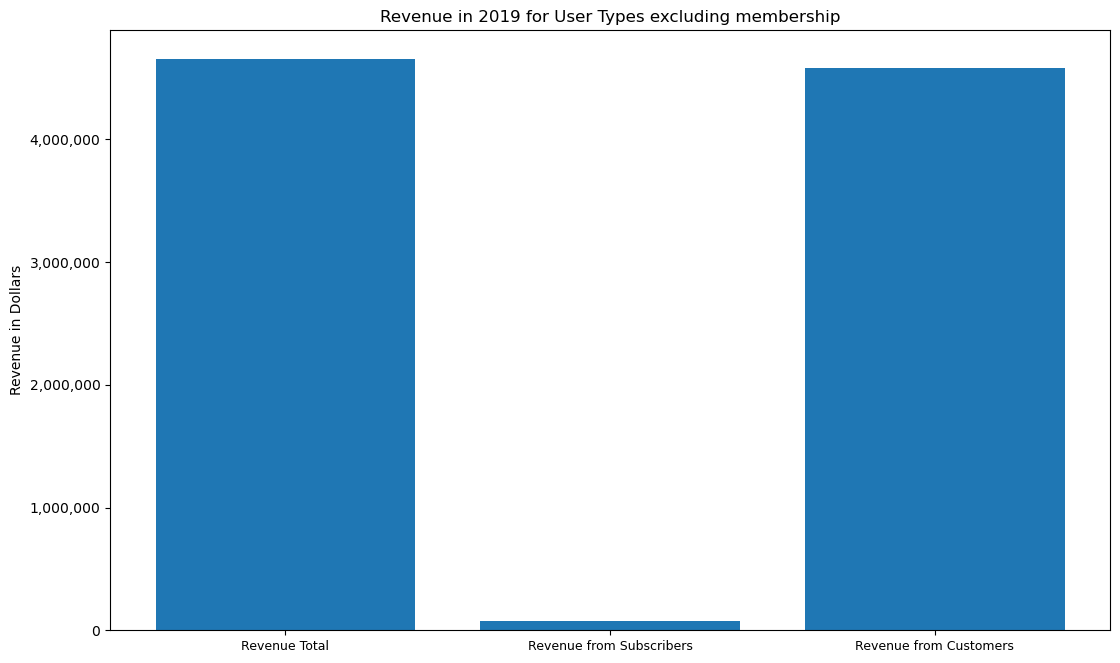

In [165]:
#plot yearly revenue 

rev_yearly_total=[rev_yearly, rev_sub, rev_cus]
label_text=["Revenue Total", "Revenue from Subscribers", "Revenue from Customers"]
figure_annual = plt.figure(figsize=(10,6),dpi = 100)
ax = figure_annual.add_axes([0,0,1,1])

ax.bar(label_text, rev_yearly_total)
ax.set_ylabel("Revenue in Dollars")
ax.set_title("Revenue in 2019 for User Types excluding membership")
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

The total revenue is 4656803\\$ not considering the revenue from the membership subscriptions. That is why it is mainly composed of the customers revenue, which is 4581983 \\$. The revenue of 74819 \\$ of the subscribers consist only of the additional costs they had to pay for trips longer than 45 minutes.

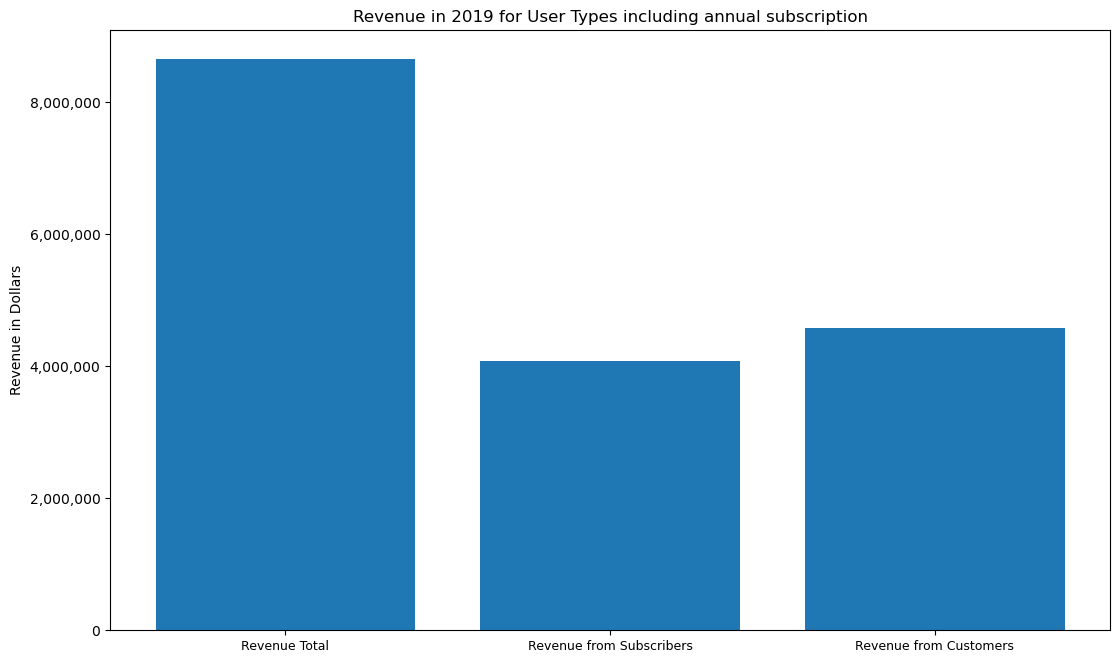

In [166]:
# yearly revenue with estimated subscription fees

#estimated revenue for subscribers including their subscription
rev_sub_total=37000*108+rev_sub


#plot yearly revenue 

rev_yearly_total=[rev_yearly+37000*108, rev_sub_total, rev_cus]
label_text=["Revenue Total", "Revenue from Subscribers", "Revenue from Customers"]
figure_annual = plt.figure(figsize=(10,6),dpi = 100)
ax = figure_annual.add_axes([0,0,1,1])

ax.bar(label_text, rev_yearly_total)
ax.set_ylabel("Revenue in Dollars")
ax.set_title("Revenue in 2019 for User Types including annual subscription")
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

Looking at the <b>revenue including estimated subscribtions</b> you can see the proportion of revenue from customers and subscribers is more balanced. But still customers have a slightly larger proportion. The number of subscriptions is estimated, because there are no numbers available for 2019. The estimation is conservative and based on the number of more than 37000 members in 2018 (https://www.chicagotribune.com/news/breaking/ct-met-divvy-prices-20180124-story.html). The number of subscriptions may be higher as Divvy Bikes grew within that time period, but we dicided to choose a number of subscribers which they achieved with a high probabiltiy. So, it has to be considered that these are not the exact numbers. But in order to depict a more realistic view it is better to estimate the subscriptions than ignoring them as they are an important part of the revenue.

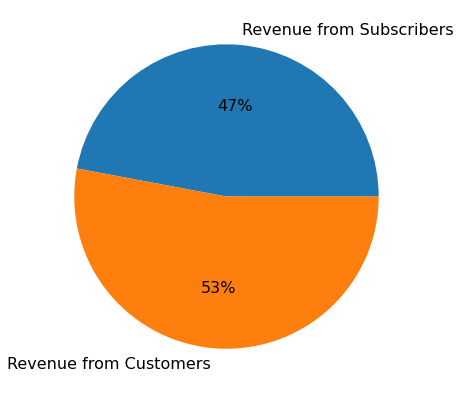

In [167]:
#plot revenue for user types including membership as pie chart

rev_yearly_type=[rev_sub_total, rev_cus]
label_type=[ "Revenue from Subscribers", "Revenue from Customers"]
fig = plt.figure(figsize =(10, 7)) 
plt.pie(rev_yearly_type, labels = label_type, autopct='%1.0f%%', textprops={'fontsize': 16}) 
  
plt.show() 

The pie chart illustrates well the proportion of the revenue comparing the user types. It has to be kept in mind, that the subscriptions are estimated, so the revenue from subscribers may be higher. But in general it shows that it is nearly balanced.

##### Revenue after included ride time
Now we will take a look at the revenue that is created only by the time where a bycicle was ridden longer than the included time in the tariff (30 minutes for customers and 45 minutes for subscribers).
It is calculated by subtracting the included ride time (per user type) and multiplying those minutes left over by 0.15 (15 cents per minute). 

Why do we look at this? There are two options for the customers, when they already reached the included driving time: they continue riding and pay per minute, or they end the ride session and start a new one. Last option is especially interesting for subscribers paying a fixed amount of money. For the company, it could be interesting to see which user type generates more money in order to adapt prices and included riding time. 

In [168]:
def calc_additional_rev_cus(z):
    if z > 30:
        a = 0.15 * (z-30)
    else:
        a = 0
    return a

In [169]:
divvy_bike_set["addi_revenue"] = np.where(divvy_bike_set["user_type"]== "Subscriber", list(map(lambda z: calc_revenue_sub(z) , divvy_bike_set["duration_min_rounded"])), list(map(lambda z: calc_additional_rev_cus(z), divvy_bike_set["duration_min_rounded"])))
addi_rev_yearly= divvy_bike_set["addi_revenue"].sum()

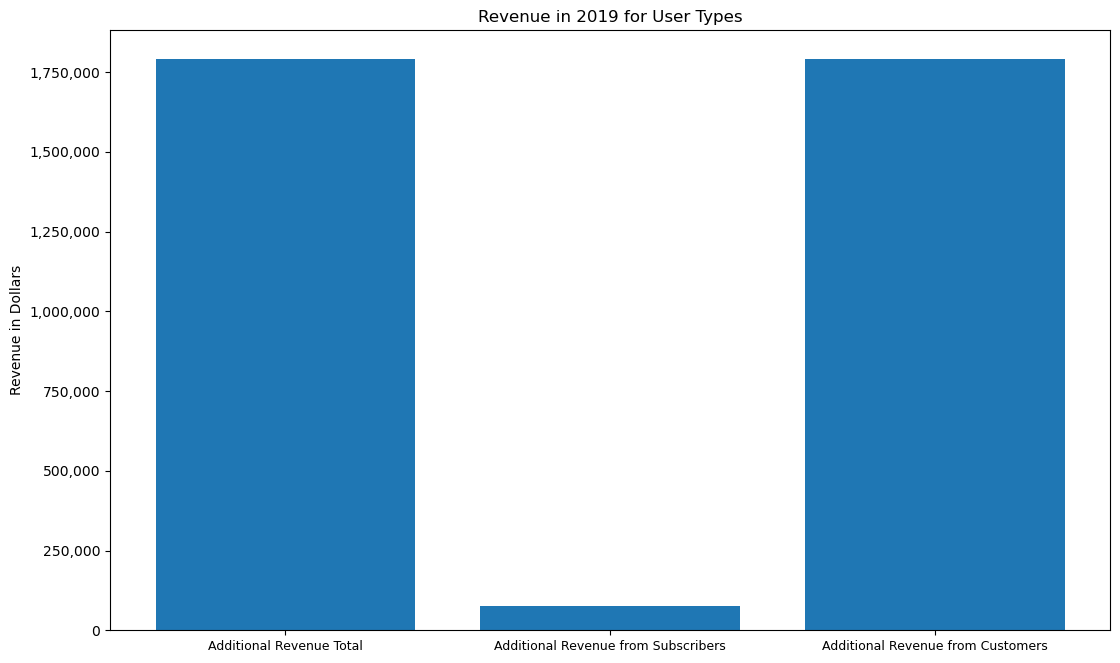

In [170]:
rev_yearly_total=[addi_rev_yearly, rev_sub, addi_rev_yearly]
label_text=["Additional Revenue Total", "Additional Revenue from Subscribers", "Additional Revenue from Customers"]
figure_annual = plt.figure(figsize=(10,6),dpi = 100)
ax = figure_annual.add_axes([0,0,1,1])

ax.bar(label_text, rev_yearly_total)
ax.set_ylabel("Revenue in Dollars")
ax.set_title("Revenue in 2019 for User Types")
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

We see that this "additional revenue" is much higher for customers. This indicates that most subscribers only take rides under 45 minutes while customers undertake longer rides, or that subscribers lock and unlock their bikes within the included 45 minutes in order to not pay any additional fees. Last assumptions depends on the ease of lock- and unlocking the bike.

###  2.3.9.2 Monthly Revenue for 2019

Now we want to have a look at the same KPI, but on a monthly level. Again we distinct between the revenue including and excluding the estimated subscriptions.

In [171]:
#add weekday to dataframe
divvy_bike_set["weekday"]=pd.DatetimeIndex(divvy_bike_set["start_time"]).weekday

# Slice data in months 
divvy_bike_set_jan = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-01").month]
divvy_bike_set_feb = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-02").month]
divvy_bike_set_mar = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-03").month]
divvy_bike_set_apr = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-04").month]
divvy_bike_set_may = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-05").month]
divvy_bike_set_jun = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-06").month]
divvy_bike_set_jul = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-07").month]
divvy_bike_set_aug = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-08").month]
divvy_bike_set_sep = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-09").month]
divvy_bike_set_oct = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-10").month]
divvy_bike_set_nov = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-11").month]
divvy_bike_set_dec = divvy_bike_set[divvy_bike_set["start_time"].dt.month == pd.to_datetime("2019-12").month]


In [172]:
# calculate monthly revenue
rev_jan=divvy_bike_set_jan["revenue"].sum()
rev_feb=divvy_bike_set_feb["revenue"].sum()
rev_mar=divvy_bike_set_mar["revenue"].sum()
rev_apr=divvy_bike_set_apr["revenue"].sum()
rev_may=divvy_bike_set_may["revenue"].sum()
rev_jun=divvy_bike_set_jun["revenue"].sum()
rev_jul=divvy_bike_set_jul["revenue"].sum()
rev_aug=divvy_bike_set_aug["revenue"].sum()
rev_sep=divvy_bike_set_sep["revenue"].sum()
rev_oct=divvy_bike_set_oct["revenue"].sum()
rev_nov=divvy_bike_set_nov["revenue"].sum()
rev_dec=divvy_bike_set_dec["revenue"].sum()

rev_monthly= [rev_jan, rev_feb, rev_mar, rev_apr, rev_may, rev_jun, rev_jul, rev_aug, rev_sep, rev_oct, rev_nov, rev_dec]
rev_monthly

[24161.399999999998,
 13688.549999999997,
 79524.30000000002,
 264121.35000000003,
 452366.2499999999,
 704857.1999999998,
 958089.15,
 1000450.2000000002,
 663816.1499999999,
 340623.44999999995,
 80406.29999999999,
 74698.79999999999]

In [173]:
# calculate monthly revenue including subscription

#price for subscription monthly
mem_monthly=37000*9

rev_jan_mem=divvy_bike_set_jan["revenue"].sum()+mem_monthly
rev_feb_mem=divvy_bike_set_feb["revenue"].sum()+mem_monthly
rev_mar_mem=divvy_bike_set_mar["revenue"].sum()+mem_monthly
rev_apr_mem=divvy_bike_set_apr["revenue"].sum()+mem_monthly
rev_may_mem=divvy_bike_set_may["revenue"].sum()+mem_monthly
rev_jun_mem=divvy_bike_set_jun["revenue"].sum()+mem_monthly
rev_jul_mem=divvy_bike_set_jul["revenue"].sum()+mem_monthly
rev_aug_mem=divvy_bike_set_aug["revenue"].sum()+mem_monthly
rev_sep_mem=divvy_bike_set_sep["revenue"].sum()+mem_monthly
rev_oct_mem=divvy_bike_set_oct["revenue"].sum()+mem_monthly
rev_nov_mem=divvy_bike_set_nov["revenue"].sum()+mem_monthly
rev_dec_mem=divvy_bike_set_dec["revenue"].sum()+mem_monthly

rev_monthly_mem= [rev_jan_mem, rev_feb_mem, rev_mar_mem, rev_apr_mem, rev_may_mem, rev_jun_mem, rev_jul_mem, rev_aug_mem, rev_sep_mem, rev_oct_mem, rev_nov_mem, rev_dec_mem]
rev_monthly_mem

[357161.4,
 346688.55,
 412524.30000000005,
 597121.3500000001,
 785366.2499999999,
 1037857.1999999998,
 1291089.15,
 1333450.2000000002,
 996816.1499999999,
 673623.45,
 413406.3,
 407698.8]

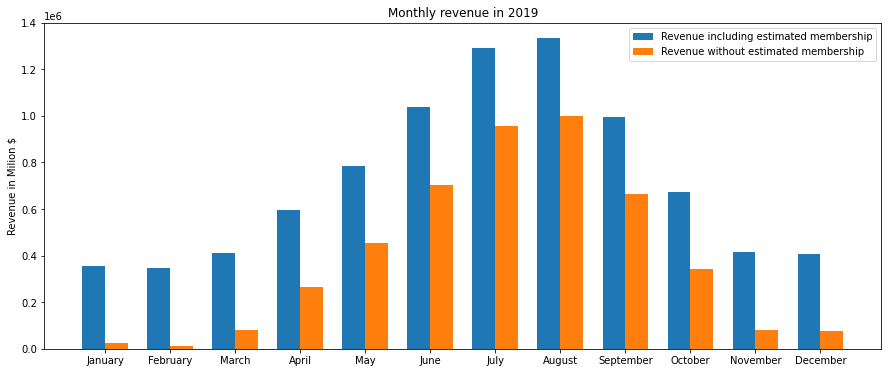

In [174]:
# Plot the monthly revenue over the year 
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rev_m_m= ax.bar(x - width/2, rev_monthly_mem, width, label='Revenue including estimated membership')
rev_m = ax.bar(x + width/2, rev_monthly, width, label='Revenue without estimated membership')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Revenue in Milion $')
ax.set_title('Monthly revenue in 2019')
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.legend()
fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()

One can see a big difference of the revenues with respect to the season. So, in <b>August the revenue is maximal</b> with 1333450\\$ including subscription and excluding the subscription with 1000450\\$. This is extremly higer than in Feburary where it is minimal with  346688\\$ including subscription and excluding the subscription with 13688\\$. The three month with </b>the highest revenue are in summer</b> (June,July and August) while the month with <b>the lowest revenue are in winter</b> (December, January and Feburary). This observation matches the fleet usage over the year as it is derives from it.

The **monthly revenue per user type (customer or subscriber)** is now calculated. 

In [175]:
#calculate revenue monthly per user type excluding membership
# calculate monthly revenue from subscribers
divvy_bike_set_jan_sub=divvy_bike_set_jan[divvy_bike_set_jan["user_type"]== "Subscriber"]
rev_jan_sub=divvy_bike_set_jan_sub["revenue"].sum()

divvy_bike_set_feb_sub=divvy_bike_set_feb[divvy_bike_set_feb["user_type"]== "Subscriber"]
rev_feb_sub=divvy_bike_set_feb_sub["revenue"].sum()

divvy_bike_set_mar_sub=divvy_bike_set_mar[divvy_bike_set_mar["user_type"]== "Subscriber"]
rev_mar_sub=divvy_bike_set_mar_sub["revenue"].sum()

divvy_bike_set_apr_sub=divvy_bike_set_apr[divvy_bike_set_apr["user_type"]== "Subscriber"]
rev_apr_sub=divvy_bike_set_apr_sub["revenue"].sum()

divvy_bike_set_may_sub=divvy_bike_set_may[divvy_bike_set_may["user_type"]== "Subscriber"]
rev_may_sub=divvy_bike_set_may_sub["revenue"].sum()

divvy_bike_set_jun_sub=divvy_bike_set_jun[divvy_bike_set_jun["user_type"]== "Subscriber"]
rev_jun_sub=divvy_bike_set_jun_sub["revenue"].sum()

divvy_bike_set_jul_sub=divvy_bike_set_jul[divvy_bike_set_jul["user_type"]== "Subscriber"]
rev_jul_sub=divvy_bike_set_jul_sub["revenue"].sum()

divvy_bike_set_aug_sub=divvy_bike_set_aug[divvy_bike_set_aug["user_type"]== "Subscriber"]
rev_aug_sub=divvy_bike_set_aug_sub["revenue"].sum()

divvy_bike_set_sep_sub=divvy_bike_set_sep[divvy_bike_set_sep["user_type"]== "Subscriber"]
rev_sep_sub=divvy_bike_set_sep_sub["revenue"].sum()

divvy_bike_set_oct_sub=divvy_bike_set_oct[divvy_bike_set_oct["user_type"]== "Subscriber"]
rev_oct_sub=divvy_bike_set_oct_sub["revenue"].sum()

divvy_bike_set_nov_sub=divvy_bike_set_nov[divvy_bike_set_nov["user_type"]== "Subscriber"]
rev_nov_sub=divvy_bike_set_nov_sub["revenue"].sum()

divvy_bike_set_dec_sub=divvy_bike_set_dec[divvy_bike_set_dec["user_type"]== "Subscriber"]
rev_dec_sub=divvy_bike_set_dec_sub["revenue"].sum()

rev_monthly_sub=[rev_jan_sub, rev_feb_sub, rev_mar_sub, rev_apr_sub,rev_may_sub,rev_jun_sub, rev_jul_sub, rev_aug_sub, rev_sep_sub, rev_oct_sub, rev_nov_sub, rev_dec_sub]
rev_monthly_sub_mem=[rev_jan_sub+mem_monthly, rev_feb_sub+mem_monthly, rev_mar_sub+mem_monthly, rev_apr_sub+mem_monthly,rev_may_sub+mem_monthly,rev_jun_sub+mem_monthly, rev_jul_sub+mem_monthly, rev_aug_sub+mem_monthly, rev_sep_sub+mem_monthly, rev_oct_sub+mem_monthly, rev_nov_sub+mem_monthly, rev_dec_sub+mem_monthly]

# calculate monthly revenue from customers 
divvy_bike_set_jan_cus=divvy_bike_set_jan[divvy_bike_set_jan["user_type"]== "Customer"]
rev_jan_cus=divvy_bike_set_jan_cus["revenue"].sum()

divvy_bike_set_feb_cus=divvy_bike_set_feb[divvy_bike_set_feb["user_type"]== "Customer"]
rev_feb_cus=divvy_bike_set_feb_cus["revenue"].sum()

divvy_bike_set_mar_cus=divvy_bike_set_mar[divvy_bike_set_mar["user_type"]== "Customer"]
rev_mar_cus=divvy_bike_set_mar_cus["revenue"].sum()

divvy_bike_set_apr_cus=divvy_bike_set_apr[divvy_bike_set_apr["user_type"]== "Customer"]
rev_apr_cus=divvy_bike_set_apr_cus["revenue"].sum()

divvy_bike_set_may_cus=divvy_bike_set_may[divvy_bike_set_may["user_type"]== "Customer"]
rev_may_cus=divvy_bike_set_may_cus["revenue"].sum()

divvy_bike_set_jun_cus=divvy_bike_set_jun[divvy_bike_set_jun["user_type"]== "Customer"]
rev_jun_cus=divvy_bike_set_jun_cus["revenue"].sum()

divvy_bike_set_jul_cus=divvy_bike_set_jul[divvy_bike_set_jul["user_type"]== "Customer"]
rev_jul_cus=divvy_bike_set_jul_cus["revenue"].sum()

divvy_bike_set_aug_cus=divvy_bike_set_aug[divvy_bike_set_aug["user_type"]== "Customer"]
rev_aug_cus=divvy_bike_set_aug_cus["revenue"].sum()

divvy_bike_set_sep_cus=divvy_bike_set_sep[divvy_bike_set_sep["user_type"]== "Customer"]
rev_sep_cus=divvy_bike_set_sep_cus["revenue"].sum()

divvy_bike_set_oct_cus=divvy_bike_set_oct[divvy_bike_set_oct["user_type"]== "Customer"]
rev_oct_cus=divvy_bike_set_oct_cus["revenue"].sum()

divvy_bike_set_nov_cus=divvy_bike_set_nov[divvy_bike_set_nov["user_type"]== "Customer"]
rev_nov_cus=divvy_bike_set_nov_cus["revenue"].sum()

divvy_bike_set_dec_cus=divvy_bike_set_dec[divvy_bike_set_dec["user_type"]== "Customer"]
rev_dec_cus=divvy_bike_set_dec_cus["revenue"].sum()

rev_monthly_cus=[rev_jan_cus, rev_feb_cus, rev_mar_cus, rev_apr_cus,rev_may_cus,rev_jun_cus,rev_jul_cus, rev_aug_cus, rev_sep_cus, rev_oct_cus, rev_nov_cus, rev_dec_cus]
print(rev_monthly_sub, rev_monthly_sub_mem, rev_monthly_cus)

[2324.5499999999997, 2170.8, 2483.1000000000004, 5406.5999999999985, 8452.799999999997, 11865.450000000003, 14099.250000000002, 11823.750000000005, 8691.0, 4413.15, 1682.1, 1407.0000000000002] [335324.55, 335170.8, 335483.1, 338406.6, 341452.8, 344865.45, 347099.25, 344823.75, 341691.0, 337413.15, 334682.1, 334407.0] [21836.85, 11517.75, 77041.19999999998, 258714.74999999997, 443913.44999999995, 692991.7499999999, 943989.8999999997, 988626.4499999997, 655125.1499999997, 336210.29999999993, 78724.19999999998, 73291.79999999999]


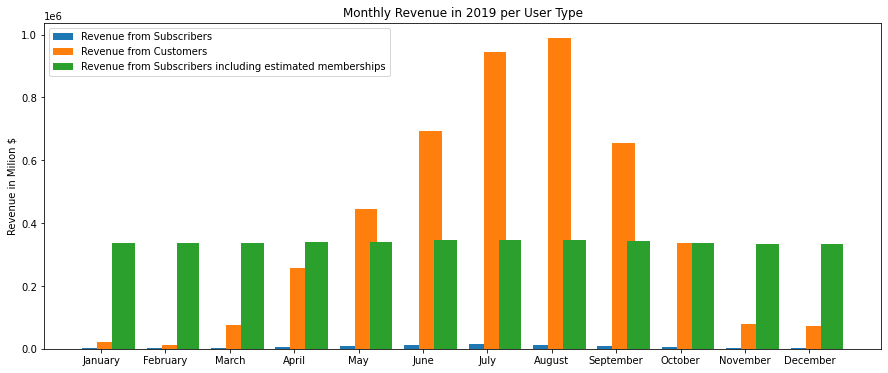

In [176]:
#Plot monthly revenue per user type excluding membership
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rev_s= ax.bar(x - width/3, rev_monthly_sub, width, label='Revenue from Subscribers')
rev_c = ax.bar(x + width/3, rev_monthly_cus, width, label='Revenue from Customers')
rev_s_m= ax.bar(x + width, rev_monthly_sub_mem, width, label='Revenue from Subscribers including estimated memberships')
# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Revenue in Milion $')
ax.set_title('Monthly Revenue in 2019 per User Type')
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.legend()
fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()

Looking at the <b>monthly revenue per user type</b> one can state that there are different revenue patterns for customers and subscribers including subscription fees. The revenue from customers and subscribers excluing the memberships follow the pattern of usage because the revenue depends on the trips made. So, in summer month it is peaking while in winter it decreases. But </b>the revenue from customers is overall multiple times higher than the revenue from subscribers excluding subscriptions</b>. In contrast to this, </b>the revenue from subscribers including the membership is way more balanced over the year</b> and nearly evenly distributed. This is due to the fact that they have to make an annual subscription and pay per month. The revenue from customers is from May to September sigificantly higher than the revenue from subscribers including estimated membership fees. The maximum is in August with nearly 1 Million \\$. In winter this changes and from October, where it is about equal, to April the revenue from Subcribers including the membership is higher than the revenue from customers. Regarding this from a business persepective, the <b> revenue from customers is volatile while the revenue from the subscriptions is quite stable</b> and thus can be used to better plan and forecast.

### 2.3.9.3 Mean Revenue per Weekday for 2019

The </b>mean revenue per trip per weekday</b> is looked at over the year and compared to the mean revenue per trip per weekday in summer and winter. This indicates how much revenue was generated in mean from a trip on the specific weekday. 

In [177]:
#mean revenue per trip per weekday  for the year

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


#calculate revenue per weekday
rev_mon= divvy_bike_set.loc[divvy_bike_set["weekday"] == 0, "revenue"].mean()
rev_tue= divvy_bike_set.loc[divvy_bike_set["weekday"] == 1, "revenue"].mean()
rev_wed= divvy_bike_set.loc[divvy_bike_set["weekday"] == 2, "revenue"].mean()
rev_thu= divvy_bike_set.loc[divvy_bike_set["weekday"] == 3, "revenue"].mean()
rev_fri= divvy_bike_set.loc[divvy_bike_set["weekday"] == 4, "revenue"].mean()
rev_sat= divvy_bike_set.loc[divvy_bike_set["weekday"] == 5, "revenue"].mean()
rev_sun= divvy_bike_set.loc[divvy_bike_set["weekday"] == 6, "revenue"].mean()

rev_daily=[rev_mon, rev_tue, rev_wed, rev_thu, rev_fri, rev_sat, rev_sun]
rev_daily

[0.9705428043362679,
 0.7763192968082666,
 0.7804204379554321,
 0.8781126701425989,
 1.093461491697812,
 2.3193556430391458,
 2.183522791743759]

In [178]:
#mean revenue per trip per weekday for summer (June, July, August)

# select oonly data in summer
divvy_bike_set_sum = divvy_bike_set[(divvy_bike_set["start_time"] > "2019-06-01") & (divvy_bike_set["start_time"] < "2019-09-01")]

#calculate mean revenue per weekday for summer
rev_mon_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 0, "revenue"].mean()
rev_tue_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 1, "revenue"].mean()
rev_wed_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 2, "revenue"].mean()
rev_thu_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 3, "revenue"].mean()
rev_fri_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 4, "revenue"].mean()
rev_sat_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 5, "revenue"].mean()
rev_sun_sum= divvy_bike_set_sum.loc[divvy_bike_set["weekday"] == 6, "revenue"].mean()

rev_daily_sum=[rev_mon_sum, rev_tue_sum, rev_wed_sum, rev_thu_sum, rev_fri_sum, rev_sat_sum, rev_sun_sum]
rev_daily_sum

[1.2142935540391846,
 1.128385239148077,
 1.094876214950265,
 1.3041956514353144,
 1.608478196104972,
 2.7861822460061516,
 2.466609647351466]

In [179]:
#mean revenue per trip per weekday for winter (November, December,)

#select only data in winter
divvy_bike_set_win= divvy_bike_set[(divvy_bike_set["start_time"] > "2019-12-01") | (divvy_bike_set["start_time"] < "2019-03-01")]

#calculate mean revenue per weekday for winter
rev_mon_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 0, "revenue"].mean()
rev_tue_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 1, "revenue"].mean()
rev_wed_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 2, "revenue"].mean()
rev_thu_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 3, "revenue"].mean()
rev_fri_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 4, "revenue"].mean()
rev_sat_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 5, "revenue"].mean()
rev_sun_win= divvy_bike_set_win.loc[divvy_bike_set["weekday"] == 6, "revenue"].mean()


rev_daily_win=[rev_mon_win, rev_tue_win, rev_wed_win, rev_thu_win, rev_fri_win, rev_sat_win, rev_sun_win]
rev_daily_win


[0.18288099103550354,
 0.17581676197715984,
 0.22170537062333556,
 0.2935930788311335,
 0.28024956745135654,
 0.7274487583759901,
 0.7488553889981288]

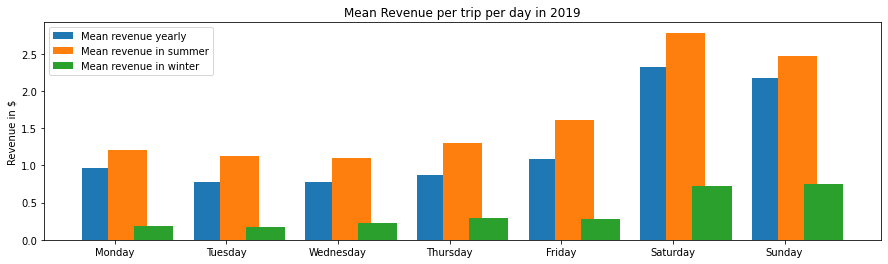

In [180]:
#plot the mean revenue per trip per day over the year, summer and winter 
x = np.arange(len(weekdays))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rev_y= ax.bar(x - width/3, rev_daily, width, label='Mean revenue yearly')
rev_a = ax.bar(x + width/3, rev_daily_sum, width, label='Mean revenue in summer')
rev_f=ax.bar(x + width, rev_daily_win, width, label='Mean revenue in winter')
# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Revenue in $')
ax.set_title('Mean Revenue per trip per day in 2019')
ax.set_xticks(x)
ax.set_xticklabels(weekdays)
ax.legend()
fig.set_figwidth(15,6)


plt.show()

The mean revenue per trip per day over the year 2019 is the <b> highest on the weekend, espacially on Saturday</b>. Comparing it to the mean revenue per trip per day for summer, the mean revenue in summer is overall higher, but the distribution over the week is similar. In contrast to that the mean revenue per trip in winter is siginficantly lower. Also, the peak of mean revenue is on the weekend, but it is nearly the same on Saturday and Sunday.

#### We finish the Revenue KPI part by summarizing the main observations:
- The revenue is direcly depending on the number of trips from customers 
- The revenue from subscribers can only be estimated
- It is also depending on the duration of the trips as trips longer than 30 (customer) /45 minutes (subscriber) are paid by minute 
- Thus, the patterns observed for the usage of bike fleet and duration of trips apply to the revenue
- The revenue is higher in summer and maximal in August:
     - Revenue from customers is volatile and peaks in summer while the revenue from the subscriptions is quite stable
     - The mean revenue per trip is higher in summer too due to the longer duration in mean
- The mean revenue per trip per day is highest on the weekend

